# Exploratory Visualization

In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats as sps
import sklearn

from google.cloud import bigquery as bq

In [2]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [3]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [4]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../service_account_key.json'

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Data in BigQuery has been pre-processed with Dataprep.

In [6]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned`
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
    else:
      # Validation
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
  else:
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(1, None)

In [22]:
client = bq.Client()
df_all = client.query(query).to_dataframe()
df_all.head()
df_all.describe()

age  concentration  musical_expertise    artistic       fault  \
count  303.000000     303.000000         303.000000  303.000000  303.000000   
mean    24.726073       3.993500           2.547224    2.344099    3.175612   
std     13.931034       0.795258           1.009324    0.988361    0.891464   
min      1.000000       1.000000           1.000000    1.000000    1.000000   
25%     16.000000       3.991266           2.000000    2.000000    3.000000   
50%     21.000000       3.991266           2.529880    2.353712    3.144737   
75%     31.000000       4.000000           3.000000    2.353712    4.000000   
max    121.000000       5.000000           5.000000    5.000000    5.000000   

       imagination        lazy     nervous    outgoing    reserved  \
count   303.000000  303.000000  303.000000  303.000000  303.000000   
mean      3.852643    3.690403    3.629726    3.213016    3.145503   
std       0.821620    0.905895    0.875898    0.961299    0.891699   
min       1.000000    1.000000    1.000000    1.000000    1.000000   
25%       3.824561    3.659389    3.596491    3.000000    3.000000   
50%       3.824561    3.659389    3.596491    3.228070    3.117904   
75%       4.000000    4.000000    4.000000    4.000000    4.000000   
max       5.000000    5.000000    5.000000    5.000000    5.000000   

                   ...               music_pref_none  music_pref_hiphop  \
count              ...                    303.000000         303.000000   
mean               ...                      0.006601           0.138614   
std                ...                      0.081110           0.346115   
min                ...                      0.000000           0.000000   
25%                ...                      0.000000           0.000000   
50%                ...                      0.000000           0.000000   
75%                ...                      0.000000           0.000000   
max                ...                      1.000000           1.000000   

       music_pref_dance  music_pref_world  music_pref_rock  music_pref_pop  \
count        303.000000        303.000000       303.000000      303.000000   
mean           0.188119          0.132013         0.432343        0.673267   
std            0.391454          0.339065         0.496221        0.469794   
min            0.000000          0.000000         0.000000        0.000000   
25%            0.000000          0.000000         0.000000        0.000000   
50%            0.000000          0.000000         0.000000        1.000000   
75%            0.000000          0.000000         1.000000        1.000000   
max            1.000000          1.000000         1.000000        1.000000   

       music_pref_classical  music_pref_jazz  music_pref_folk  \
count            303.000000       303.000000       303.000000   
mean               0.306931         0.171617         0.089109   
std                0.461983         0.377671         0.285372   
min                0.000000         0.000000         0.000000   
25%                0.000000         0.000000         0.000000   
50%                0.000000         0.000000         0.000000   
75%                1.000000         0.000000         0.000000   
max                1.000000         1.000000         1.000000   

       music_pref_traditional_irish  
count                    303.000000  
mean                       0.059406  
std                        0.236774  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000  

[8 rows x 29 columns]

In [283]:
df_reaction = df_all[df_all['hallelujah_reaction'] == True]
df_no_reaction = df_all[df_all['hallelujah_reaction'] == False]

In [21]:
df_all.columns

Index(['id', 'age', 'concentration', 'hearing_impairments',
       'musical_expertise', 'nationality', 'artistic', 'fault', 'imagination',
       'lazy', 'nervous', 'outgoing', 'reserved', 'stress', 'thorough',
       'trusting', 'activity', 'engagement', 'familiarity', 'like_dislike',
       'positivity', 'tension', 'sex', 'hallelujah_reaction', 'location',
       'language'],
      dtype='object')

In [255]:
def plot_histograms(x_label, dist_var, bins=None, normed=False, kde=True, bw='normal_reference', x_lim=None):
    f = plt.figure(figsize=(15, 4))
    sns.distplot(df_all[dist_var], bins=bins, norm_hist=normed, kde=kde, rug=True, kde_kws={'bw': bw})
    plt.xlabel('')
    if x_lim is not None:
        plt.xlim([0.5, 5.5])

    g = sns.FacetGrid(df_all, hue='hallelujah_reaction', height=4, aspect=4)
    g.map(sns.distplot, dist_var, bins=bins, norm_hist=normed, kde=kde, kde_kws={'bw': bw})
    g.set_xlabels(x_label)
    if x_lim is not None:
        g.axes[0,0].set_xlim([0.5, 5.5])
    g.add_legend(title='Hallelujah Reaction');
    
    # Student's t-test for difference in mean hallelujah reaction groups
    print('Student\'s t-test for difference in mean {} between Hallelujah Reaction groups'.format(x_label.capitalize()))
    
    mean_true = df_all[df_all['hallelujah_reaction'] == True][dist_var]
    mean_false = df_all[df_all['hallelujah_reaction'] == False][dist_var]
    
    alpha = 0.05
    _, equal_variance_p = sps.levene(mean_true, mean_false)
    
    equal_var = None
    if equal_variance_p >= alpha:
        print('Variances are equal')
        equal_var = True
    else:
        print('Variances are unequal')
        equal_var = False
    
    t_stat, p = sps.ttest_ind(mean_true, mean_false, equal_var=equal_var)

    print('Test statistic: {:.4f}'.format(t_stat))
    print('p-value: {:.4f}'.format(p))
    
    if p <= alpha:
        print('**** Significant Result ****')
    elif p <= (alpha + 0.02):
        print('** Interesting Result **')

Student's t-test for difference in mean Age [years] between Hallelujah Reaction groups
Variances are equal
Test statistic: -0.3356
p-value: 0.7374


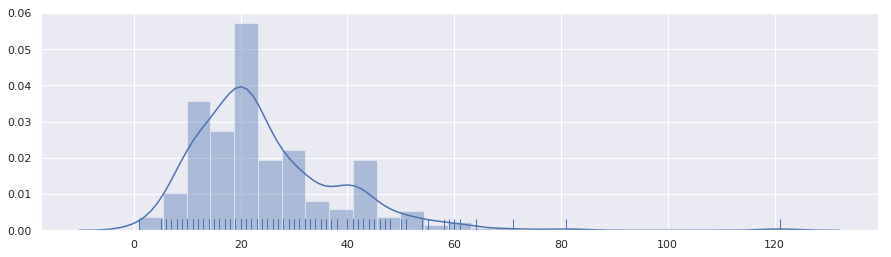

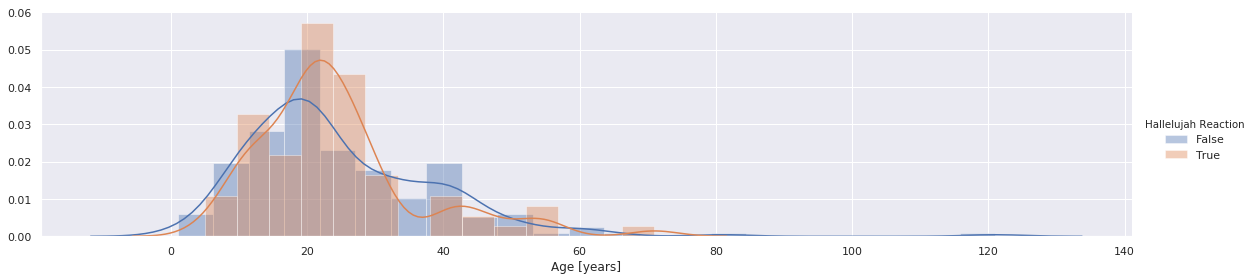

In [256]:
plot_histograms('Age [years]', 'age')

Student's t-test for difference in mean Concentration between Hallelujah Reaction groups
Variances are equal
Test statistic: -0.4416
p-value: 0.6591


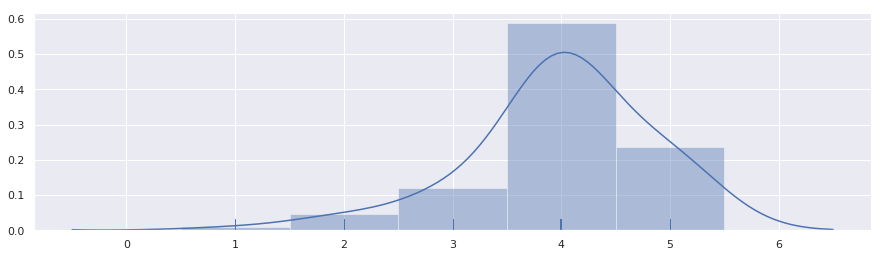

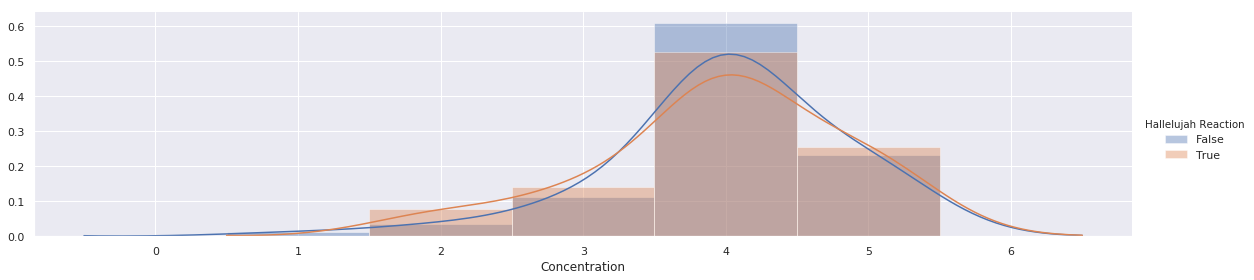

In [257]:
plot_histograms('Concentration', 'concentration', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Hearing impairments between Hallelujah Reaction groups
Variances are equal
Test statistic: 0.5994
p-value: 0.5494


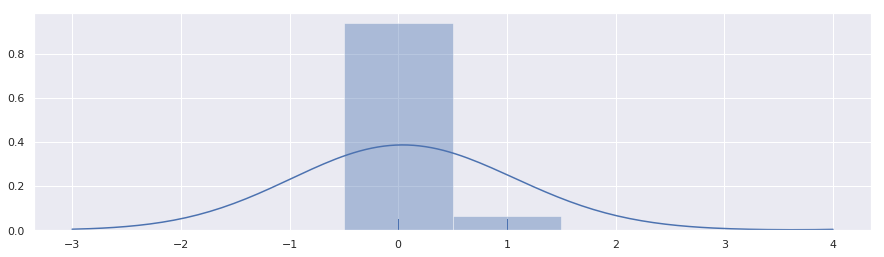

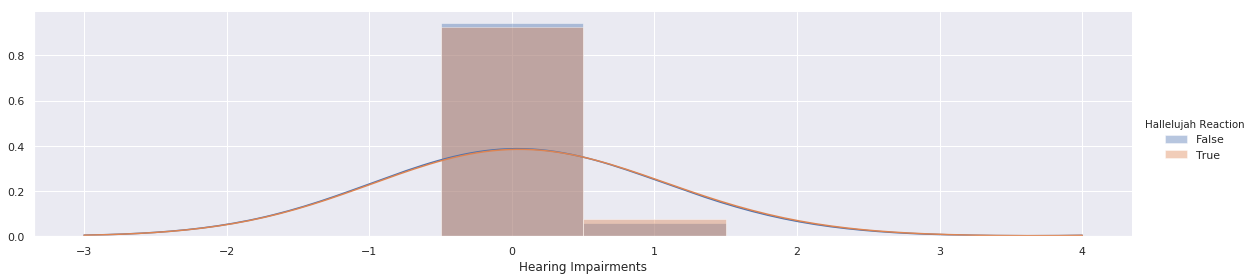

In [258]:
plot_histograms('Hearing Impairments', 'hearing_impairments', bins=[-0.5, 0.5, 1.5], normed=False, kde=True, bw=1)

Student's t-test for difference in mean Musical expertise between Hallelujah Reaction groups
Variances are equal
Test statistic: -1.4458
p-value: 0.1493


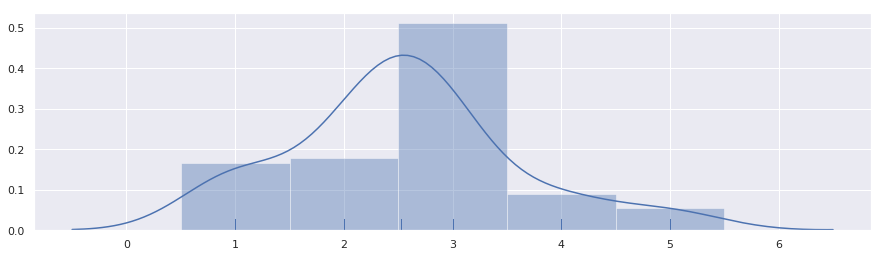

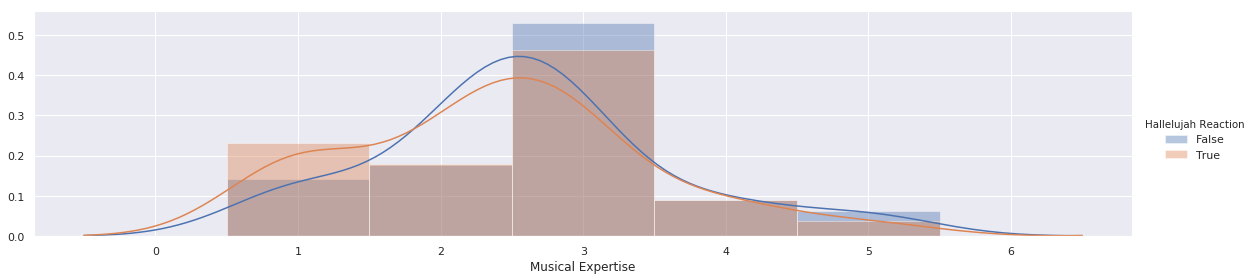

In [259]:
plot_histograms('Musical Expertise', 'musical_expertise', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Artistic between Hallelujah Reaction groups
Variances are equal
Test statistic: 0.2108
p-value: 0.8332


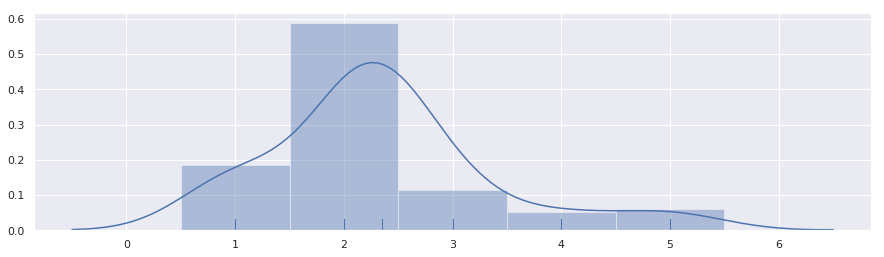

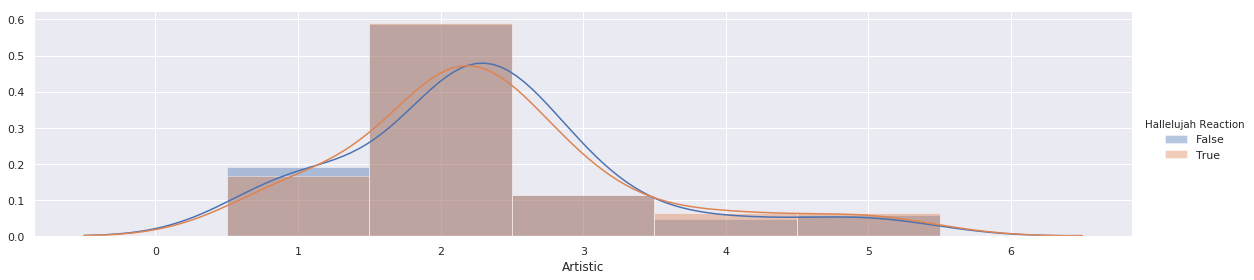

In [260]:
plot_histograms('Artistic', 'artistic', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Fault between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.8478
p-value: 0.0656
** Interesting Result **


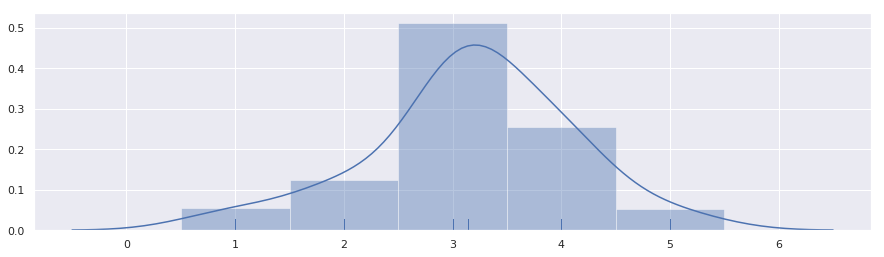

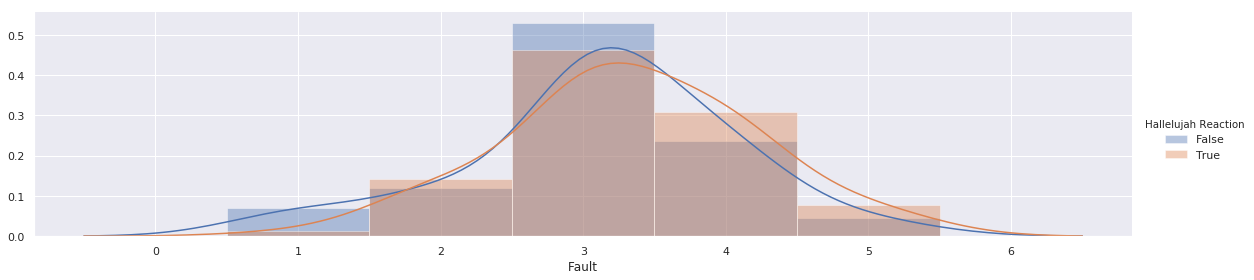

In [261]:
plot_histograms('Fault', 'fault', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Imagination between Hallelujah Reaction groups
Variances are equal
Test statistic: -0.3778
p-value: 0.7058


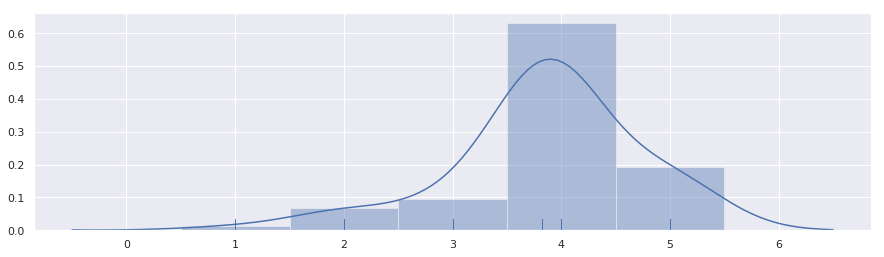

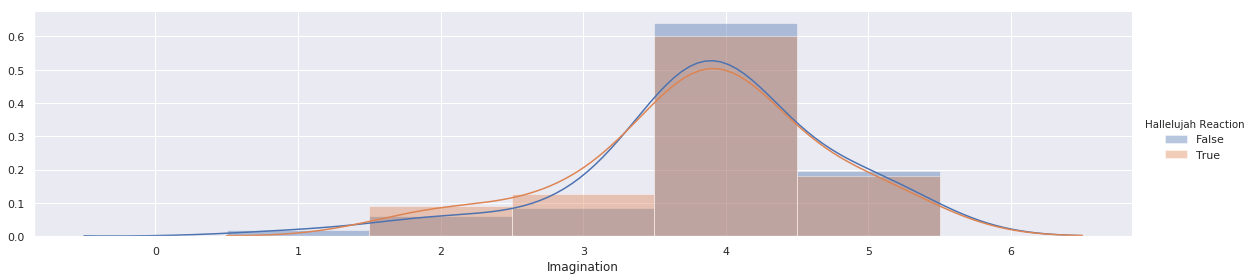

In [262]:
plot_histograms('Imagination', 'imagination', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Lazy between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.3063
p-value: 0.1924


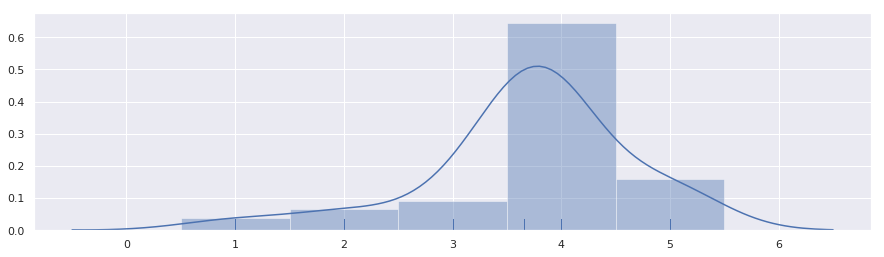

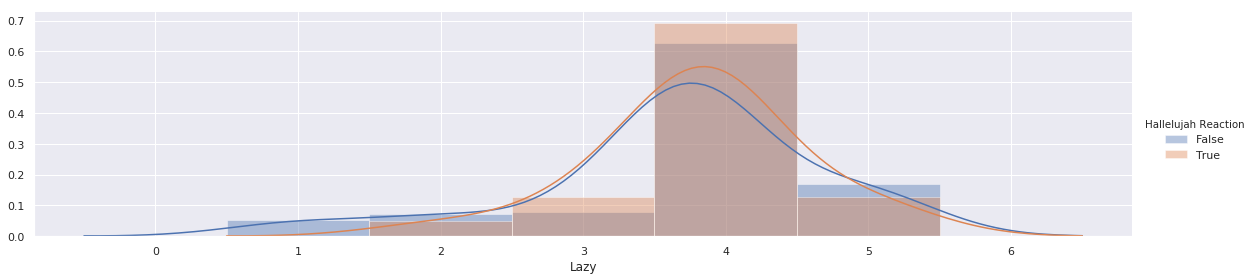

In [263]:
plot_histograms('Lazy', 'lazy', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Nervous between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.6555
p-value: 0.0989


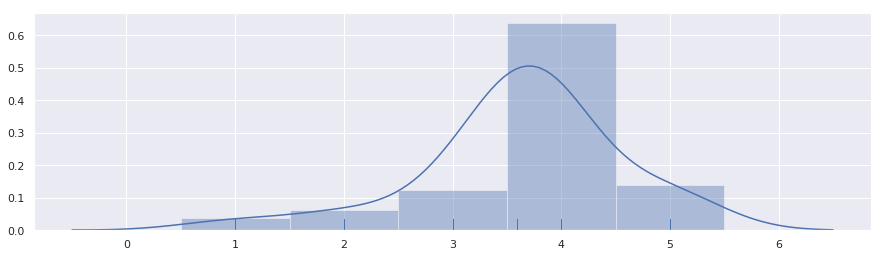

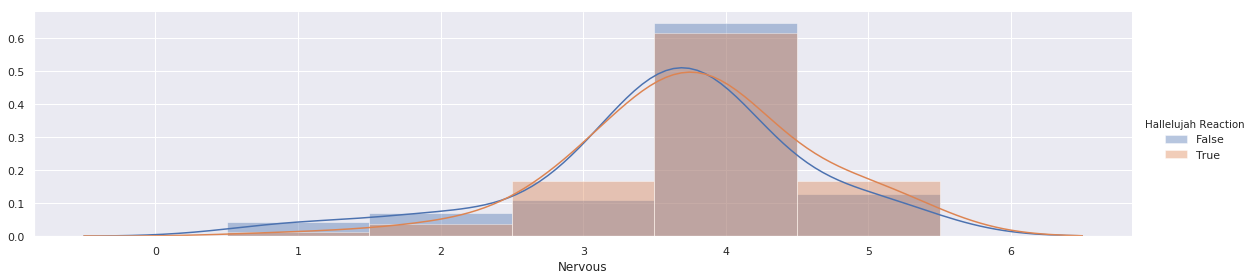

In [264]:
plot_histograms('Nervous', 'nervous', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Outgoing between Hallelujah Reaction groups
Variances are equal
Test statistic: -1.8662
p-value: 0.0630
** Interesting Result **


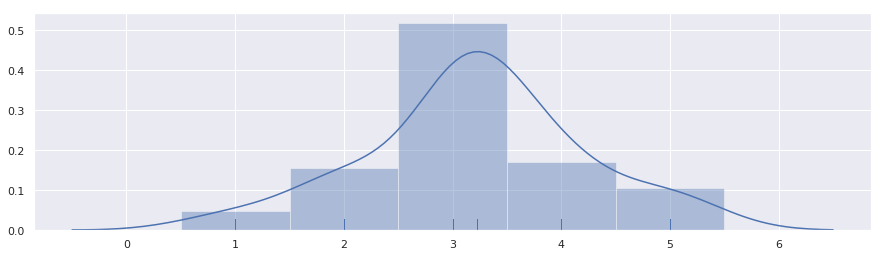

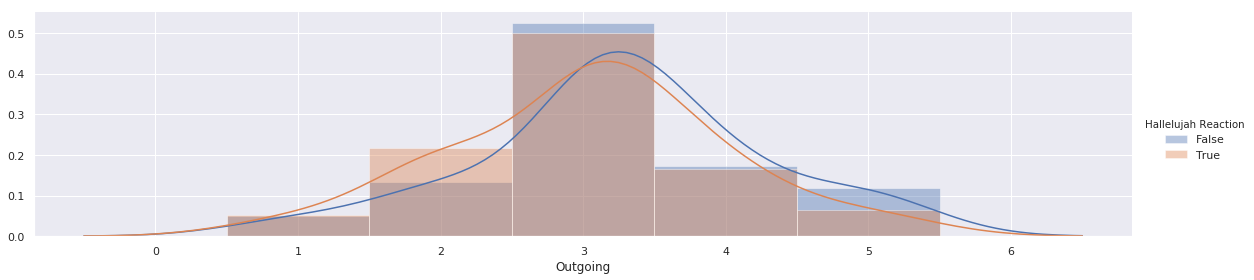

In [265]:
plot_histograms('Outgoing', 'outgoing', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Reserved between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.3467
p-value: 0.1791


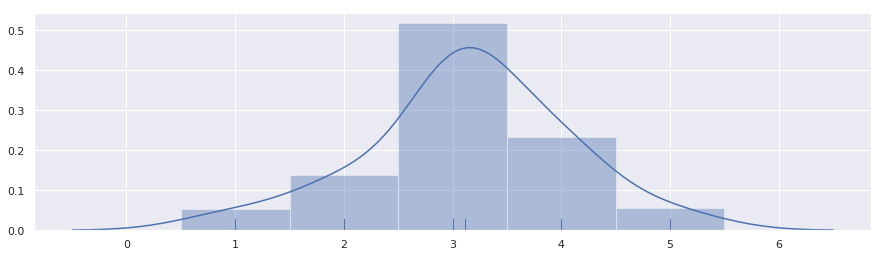

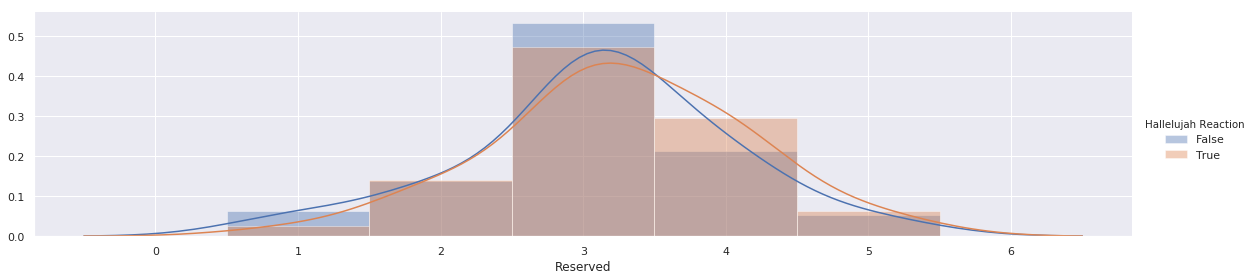

In [266]:
plot_histograms('Reserved', 'reserved', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Stress between Hallelujah Reaction groups
Variances are equal
Test statistic: -2.4133
p-value: 0.0164
**** Significant Result ****


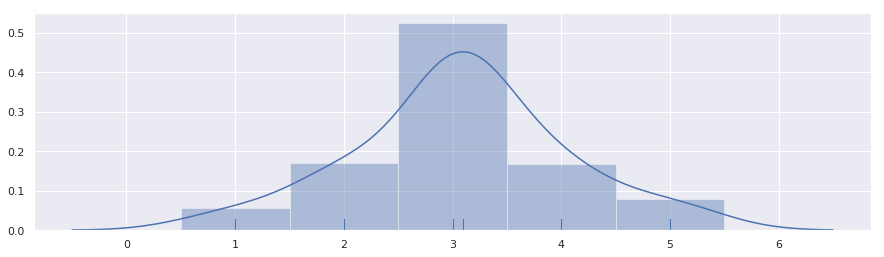

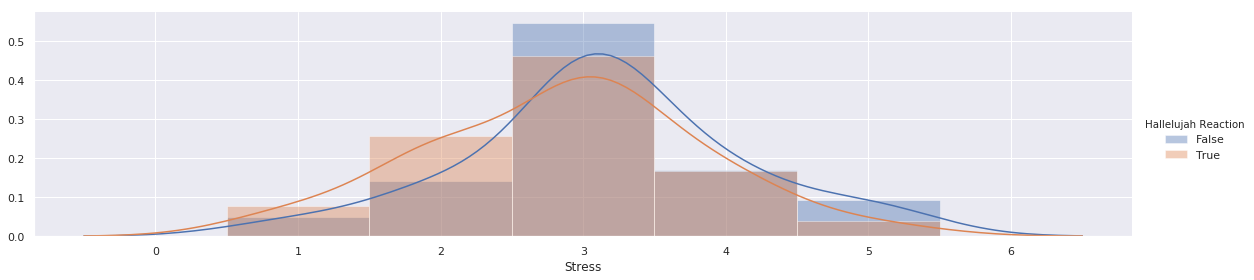

In [267]:
plot_histograms('Stress', 'stress', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Thorough between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.0970
p-value: 0.2735


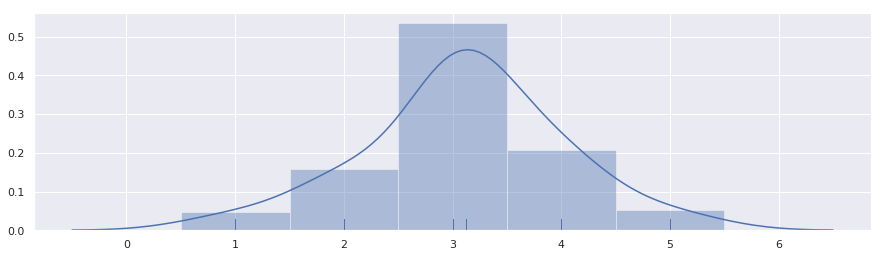

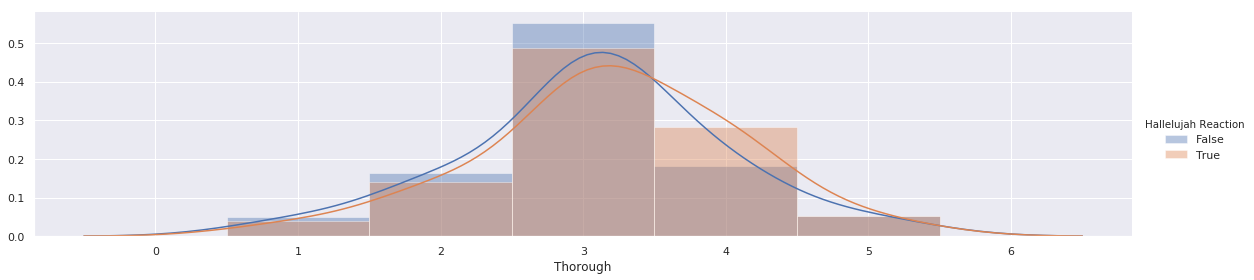

In [268]:
plot_histograms('Thorough', 'thorough', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Trusting between Hallelujah Reaction groups
Variances are unequal
Test statistic: -1.2516
p-value: 0.2133


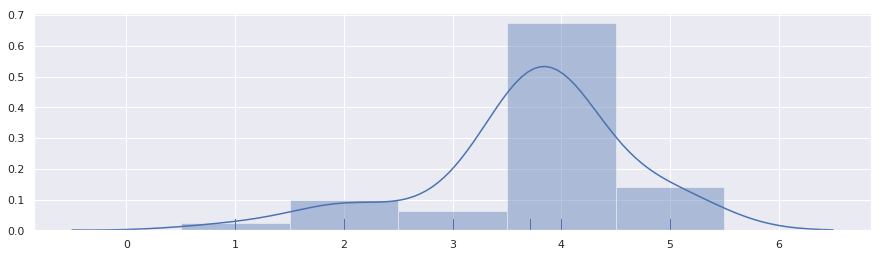

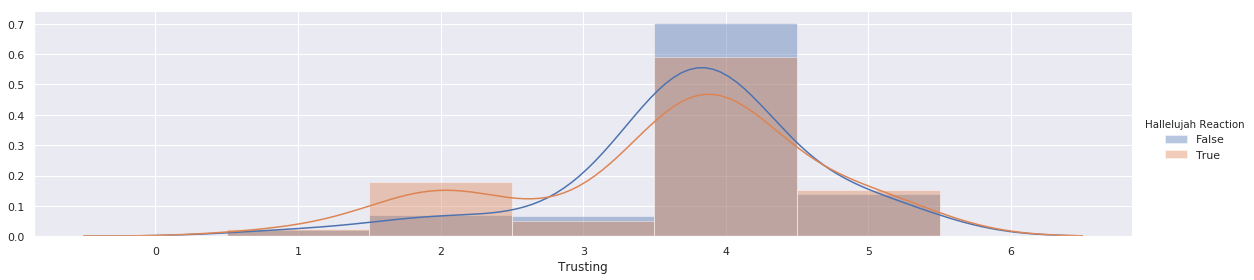

In [269]:
plot_histograms('Trusting', 'trusting', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Activity between Hallelujah Reaction groups
Variances are equal
Test statistic: -1.5890
p-value: 0.1131


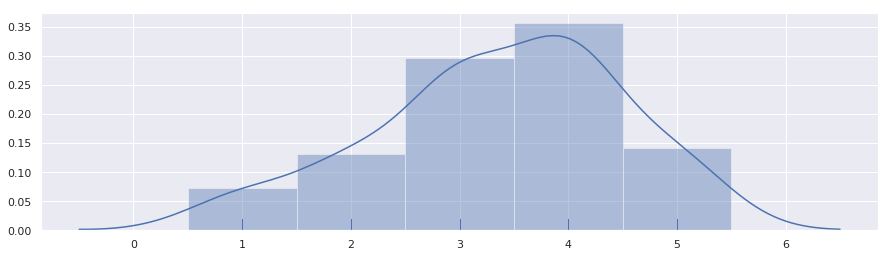

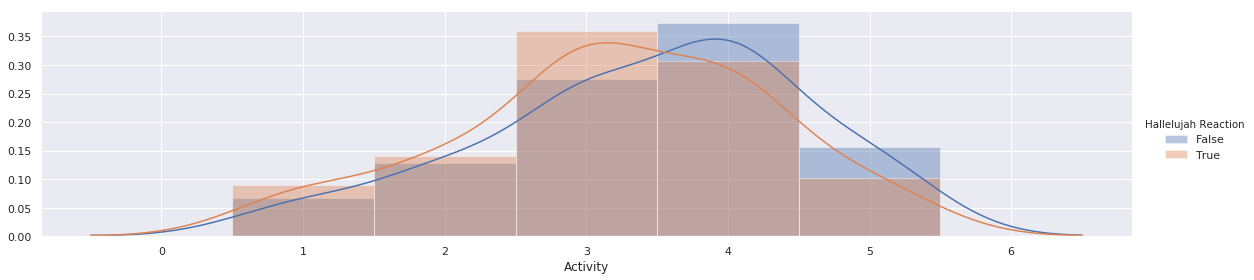

In [270]:
plot_histograms('Activity', 'activity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Engagement between Hallelujah Reaction groups
Variances are equal
Test statistic: 0.9218
p-value: 0.3574


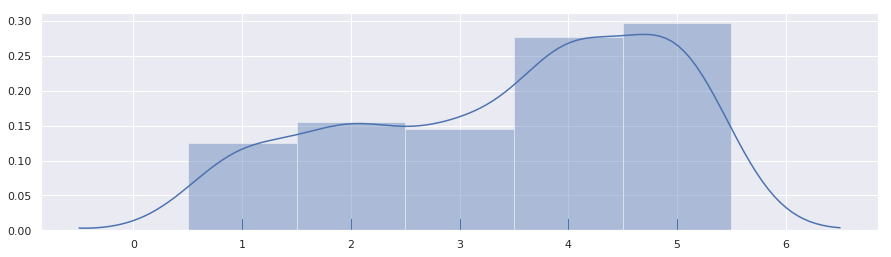

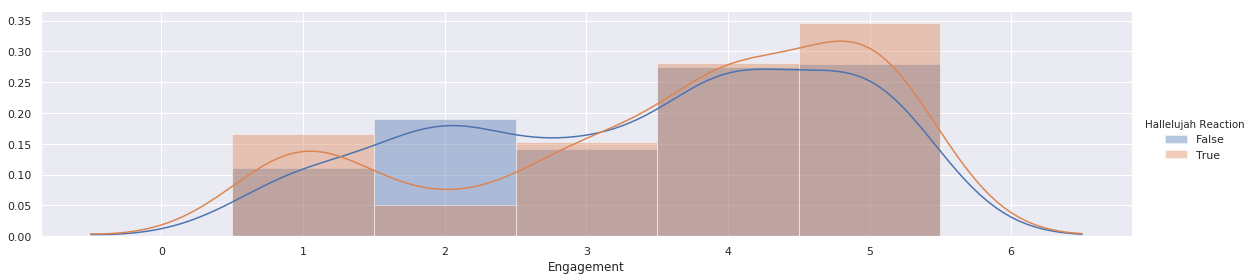

In [271]:
plot_histograms('Engagement', 'engagement', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Familiarity between Hallelujah Reaction groups
Variances are equal
Test statistic: -2.0333
p-value: 0.0429
**** Significant Result ****


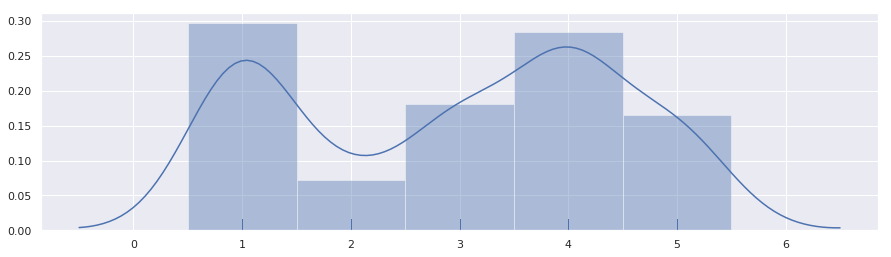

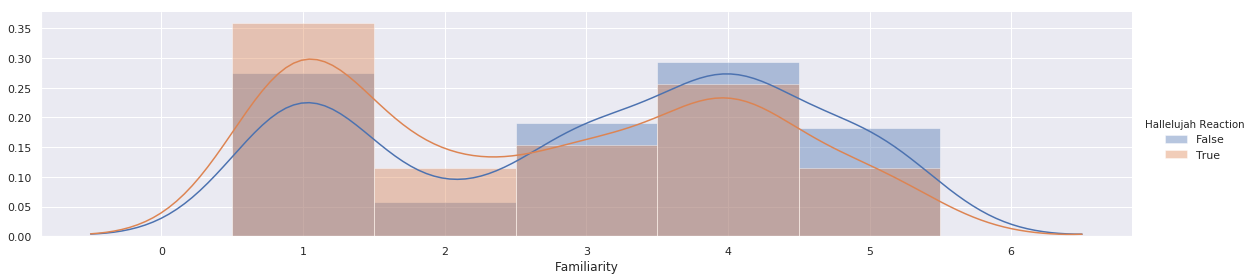

In [272]:
plot_histograms('Familiarity', 'familiarity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Like/dislike between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.0457
p-value: 0.2966


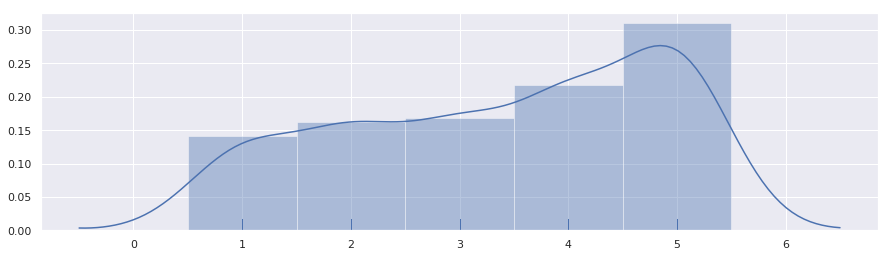

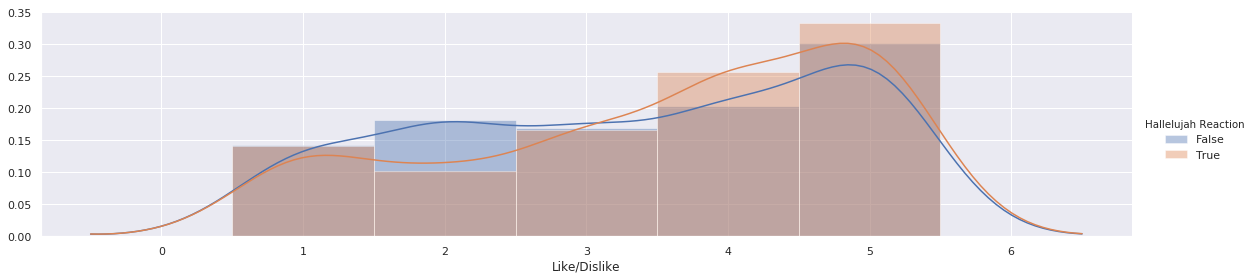

In [273]:
plot_histograms('Like/Dislike', 'like_dislike', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Positivity between Hallelujah Reaction groups
Variances are equal
Test statistic: 0.6962
p-value: 0.4868


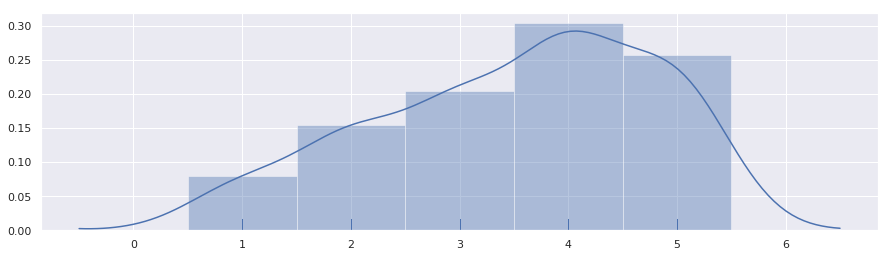

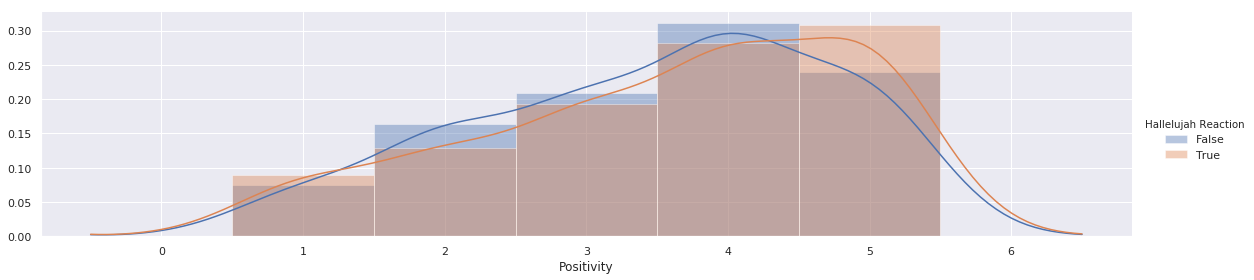

In [274]:
plot_histograms('Positivity', 'positivity', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

Student's t-test for difference in mean Tension between Hallelujah Reaction groups
Variances are equal
Test statistic: 1.2241
p-value: 0.2219


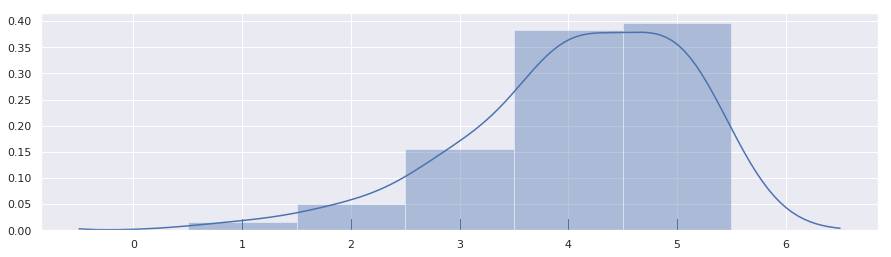

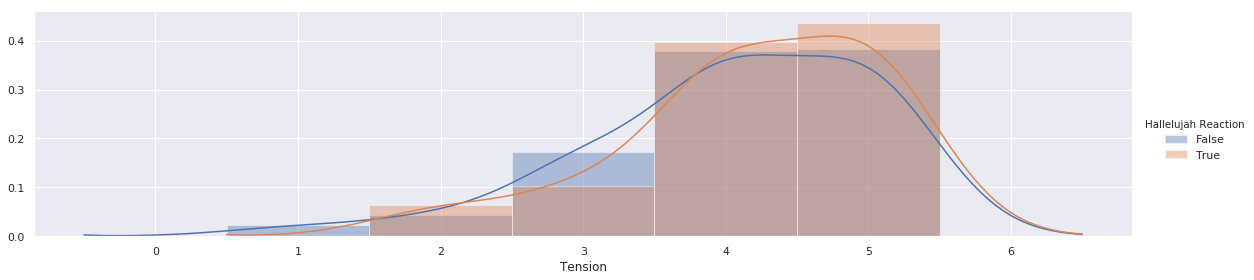

In [275]:
plot_histograms('Tension', 'tension', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], normed=False, bw=0.5)

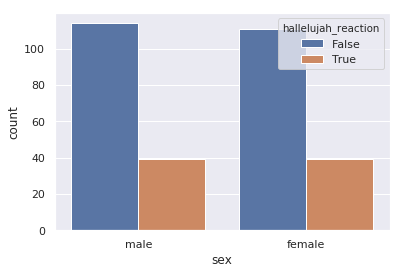

In [276]:
sns.countplot(x='sex', hue='hallelujah_reaction', data=df_all)

In [277]:
# Chi-squared test of male/female proportions

cross = pd.crosstab(df_all['sex'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of sex vs hallelujah reaction proportions')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
sex                              
female                 111     39
male                   114     39

Chi-squared test of sex vs hallelujah reaction proportions
Test statistic: 0.0009
p-value: 0.9761
Degrees of freedom: 1


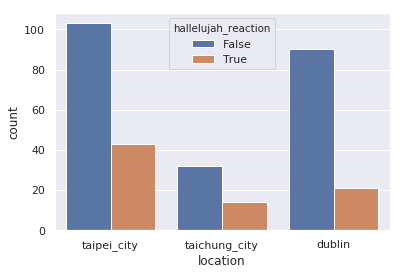

In [278]:
sns.countplot(x='location', hue='hallelujah_reaction', data=df_all)

In [279]:
# Chi-squared test of location proportions

cross = pd.crosstab(df_all['location'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of location vs hallelujah reaction proportions')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
location                         
dublin                  90     21
taichung_city           32     14
taipei_city            103     43

Chi-squared test of location vs hallelujah reaction proportions
Test statistic: 4.2845
p-value: 0.1174
Degrees of freedom: 2


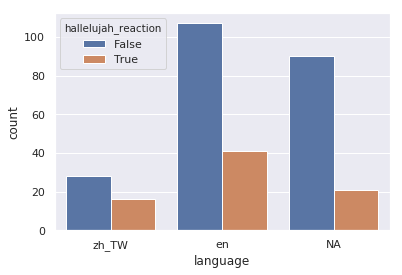

In [280]:
sns.countplot(x='language', hue='hallelujah_reaction', data=df_all)

In [281]:
# Chi-squared test of language proportions

cross = pd.crosstab(df_all['language'], df_all['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of language vs hallelujah reaction proportions (for Taiwanese, English, and NA)')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

df_no_na_lang = df_all[df_all['language'] != 'NA']
cross = pd.crosstab(df_no_na_lang['language'], df_no_na_lang['hallelujah_reaction'])
display(cross)
chi2, p, dof, table = sps.chi2_contingency(cross)
print('Chi-squared test of language vs hallelujah reaction proportions (for only Taiwanese and English)')
print('Test statistic: {:.4f}'.format(chi2))
print('p-value: {:.4f}'.format(p))
print('Degrees of freedom: {}'.format(dof))

hallelujah_reaction  False  True 
language                         
NA                      90     21
en                     107     41
zh_TW                   28     16

Chi-squared test of language vs hallelujah reaction proportions (for Taiwanese, English, and NA)
Test statistic: 5.5978
p-value: 0.0609
Degrees of freedom: 2


hallelujah_reaction  False  True 
language                         
en                     107     41
zh_TW                   28     16

Chi-squared test of language vs hallelujah reaction proportions (for only Taiwanese and English)
Test statistic: 0.8392
p-value: 0.3596
Degrees of freedom: 1


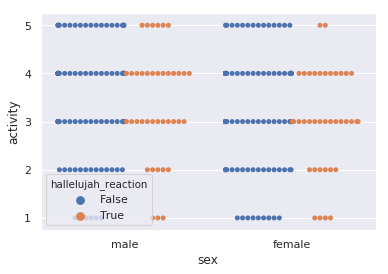

In [149]:
# sns.jointplot(x='activity', y='positivity', kind='scatter', data=df_all)

sns.swarmplot(y='activity', x='sex', hue='hallelujah_reaction', dodge=True, data=df_all)

Sources for Hotelling's $T^2$:
- https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hotellings_Two-Sample_T2.pdf
- https://onlinecourses.science.psu.edu/stat505/node/100/

In [652]:
def hotelling_t2(X_1, X_2, alpha):
    
    import scipy.stats as sps
    
    n_1 = len(X_1)
    n_2 = len(X_2)

    y_1 = X_1.mean().as_matrix()
    y_1 = y_1.reshape(len(y_1), -1)
    y_2 = X_2.mean().as_matrix()
    y_2 = y_2.reshape(len(y_2), -1)

    # Covariance matrices
    S_1 = np.cov(X_1.astype(np.float64).T)
    S_2 = np.cov(X_2.astype(np.float64).T)

    # Pooled variance
    S_pooled_num = ((n_1 - 1) * S_1) + ((n_2 - 1) * S_2)
    S_pooled_denom = n_1 + n_2 - 2
    S_pooled = S_pooled_num / S_pooled_denom
    
    T_2 = (n_1 * n_2) / (n_1 + n_2)
    T_2 = T_2 * np.matmul((y_1 - y_2).T, np.linalg.pinv(S_pooled))
    T_2 = np.matmul(T_2, (y_1 - y_2))
    T_2 = T_2.squeeze()
    
    p = len(X_1.columns)
    F_num = n_1 + n_2 - p - 1
    F_denom = p * (n_1 + n_2 - 2)
    F = (F_num / F_denom) * T_2
    F = F.squeeze()
    
    df_1 = p
    df_2 = n_1 + n_2 - p - 1
    F_dist = sps.f(df_1, df_2)
    p_value = f_dist.cdf(F)
    
    return({
        'T2': T_2,
        'F': F,
        'df': (df_1, df_2),
        'p': p_value
    })

/jet/var/python/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


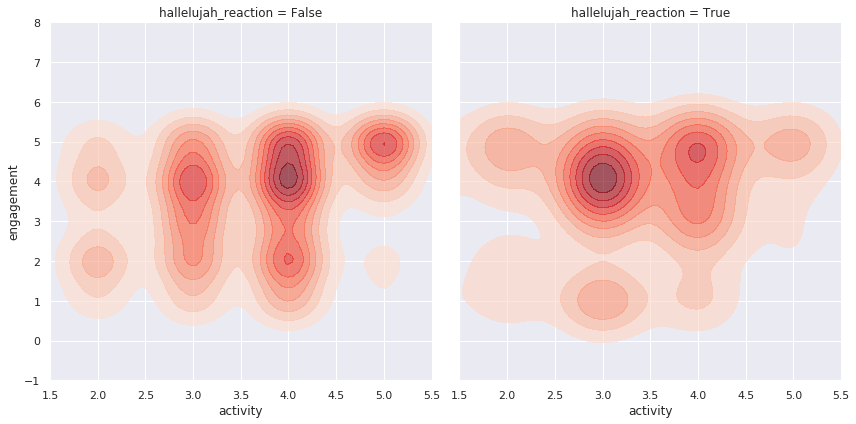

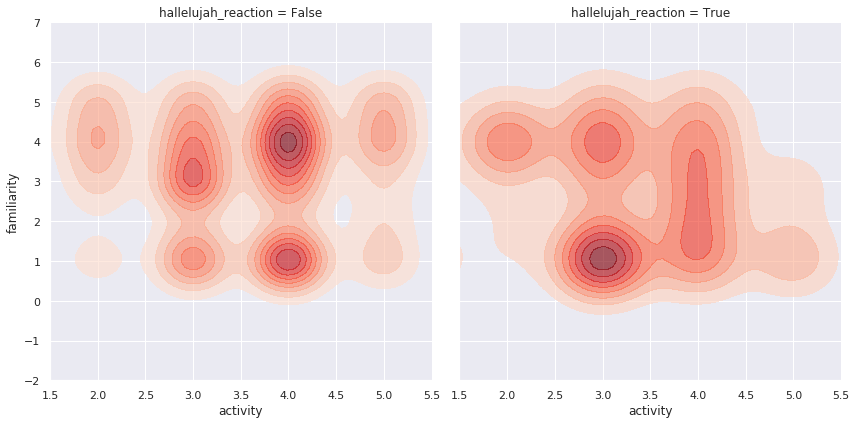

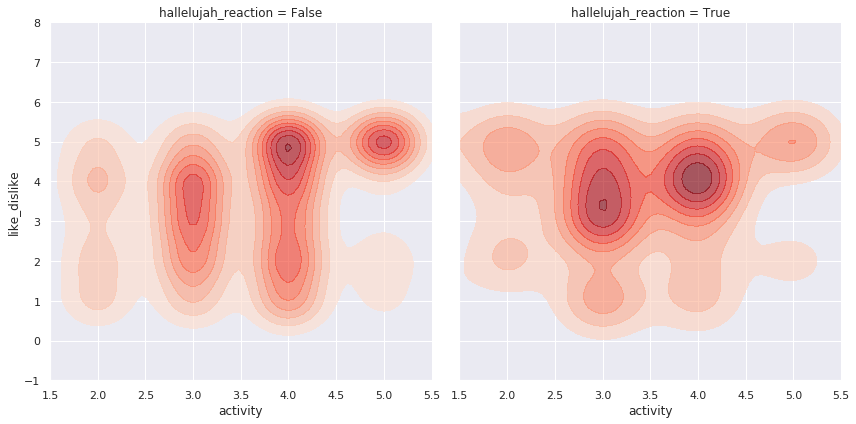

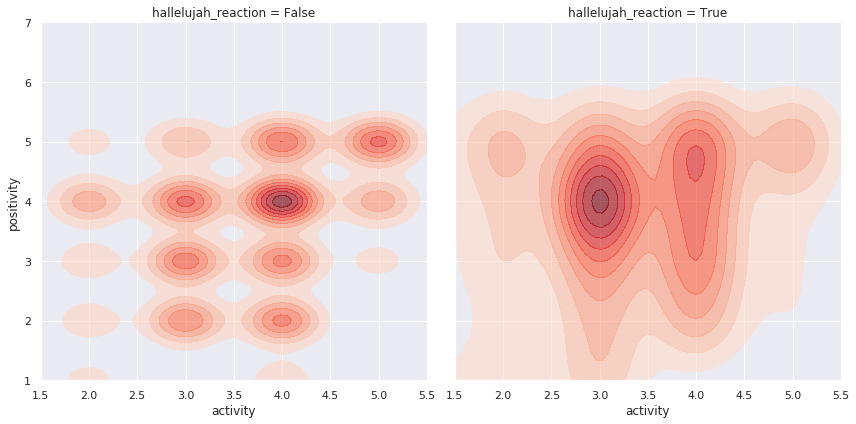

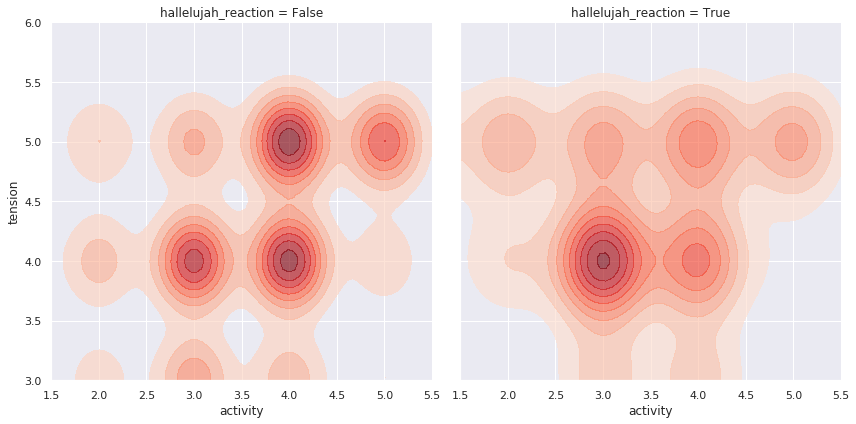

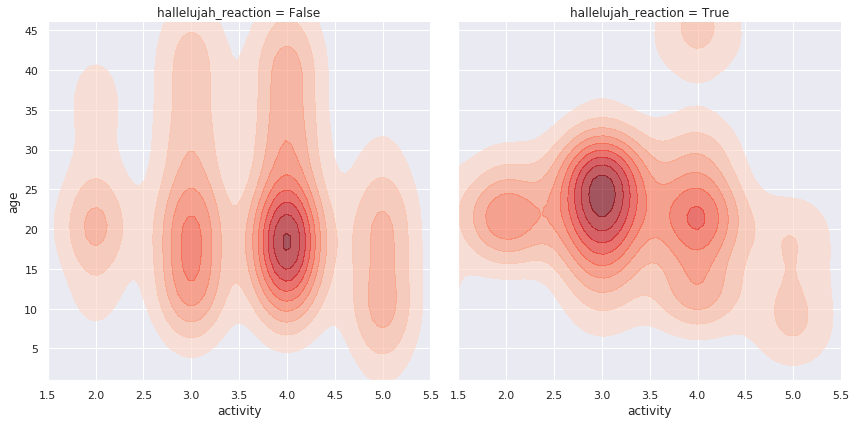

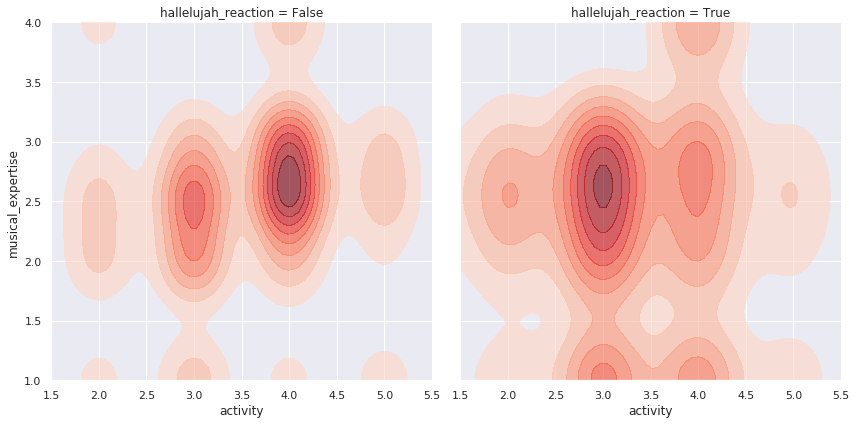

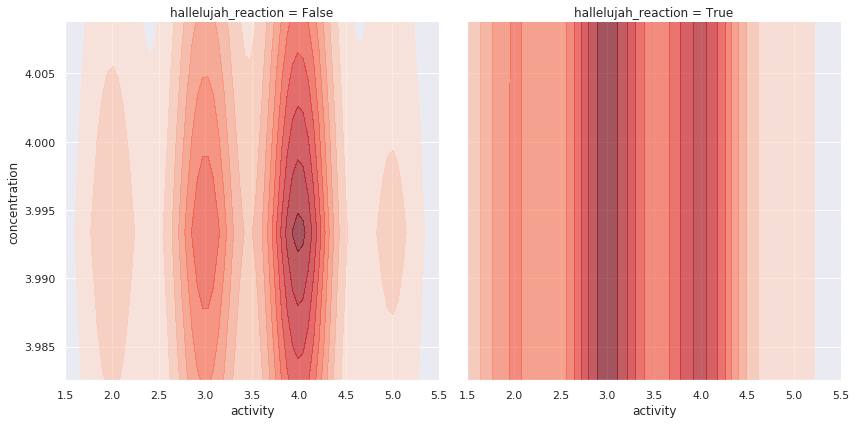

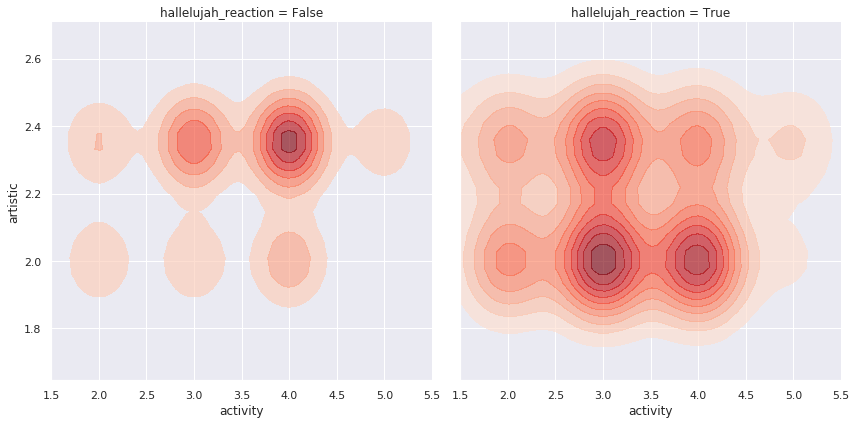

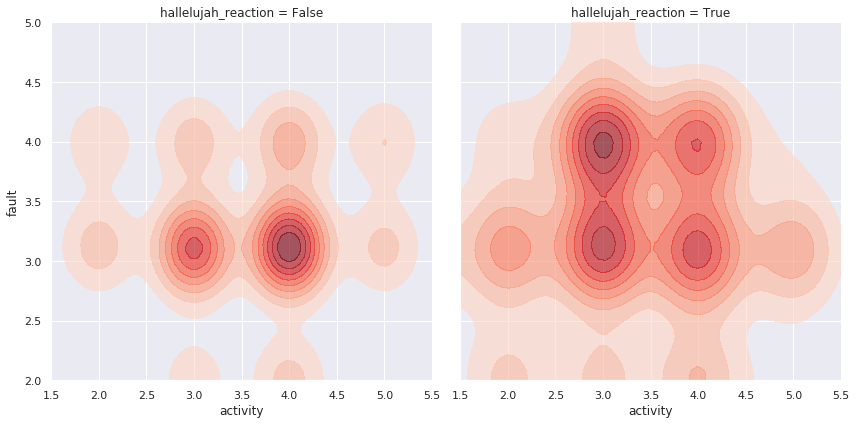

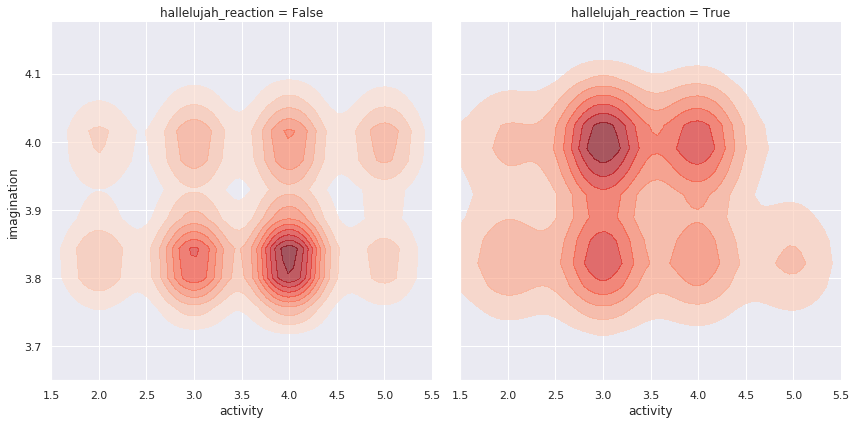

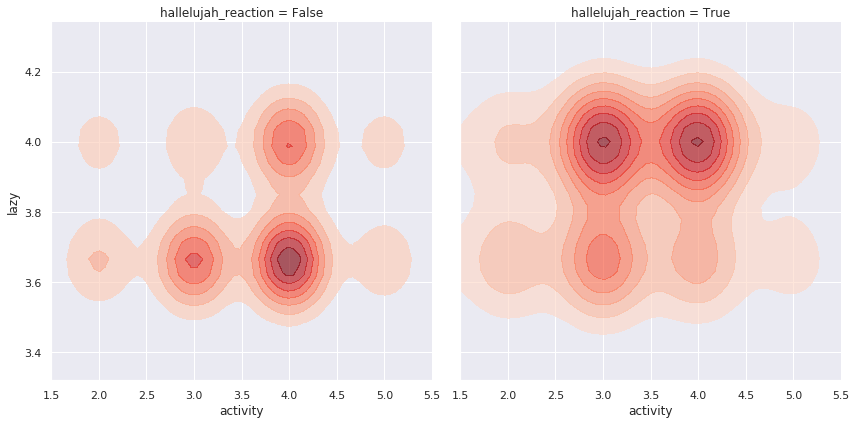

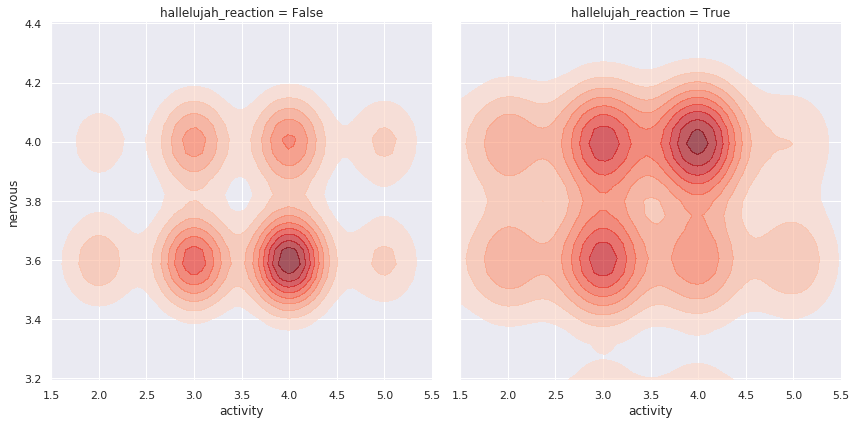

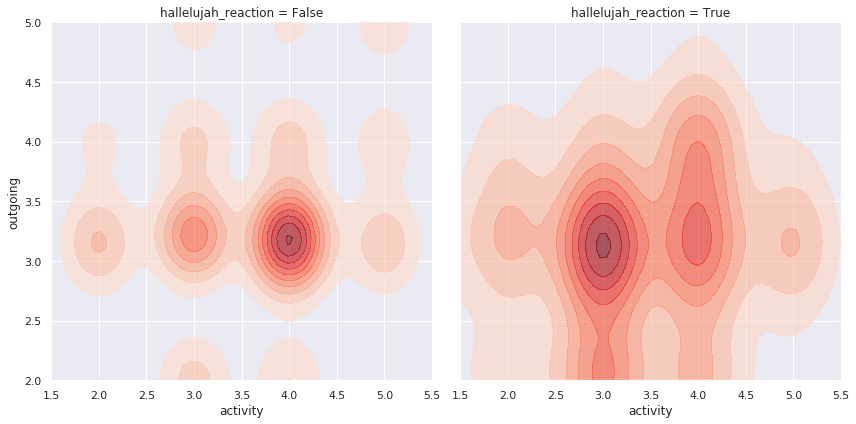

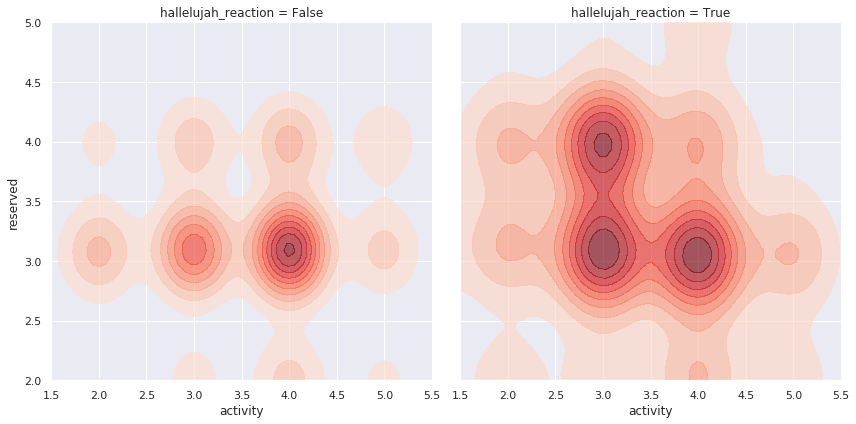

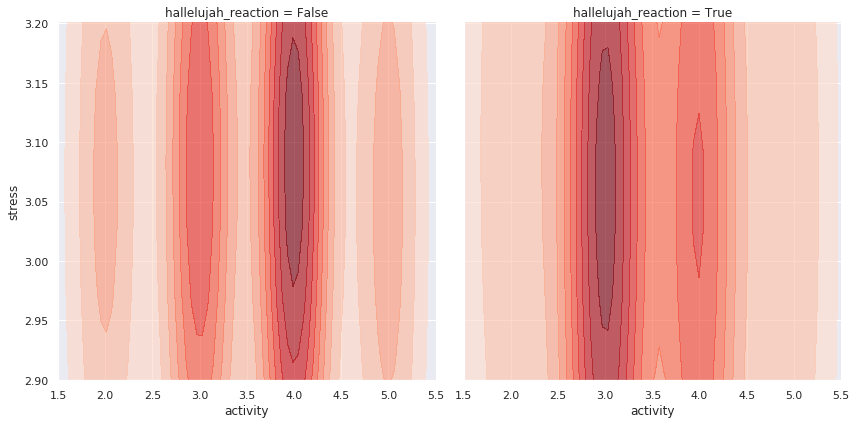

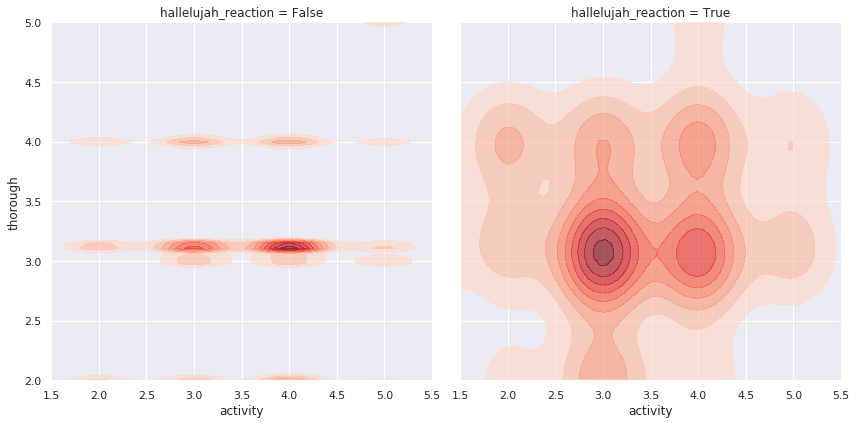

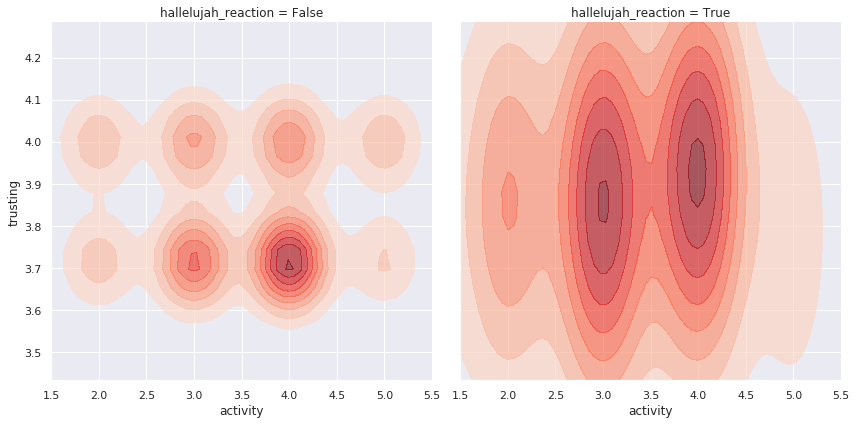

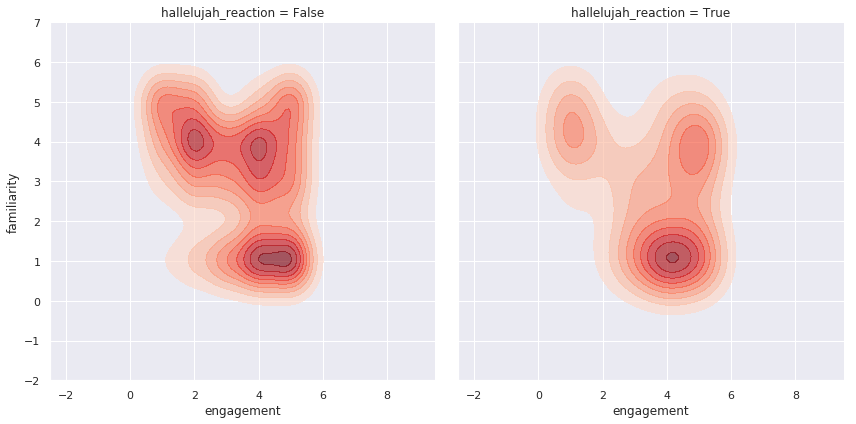

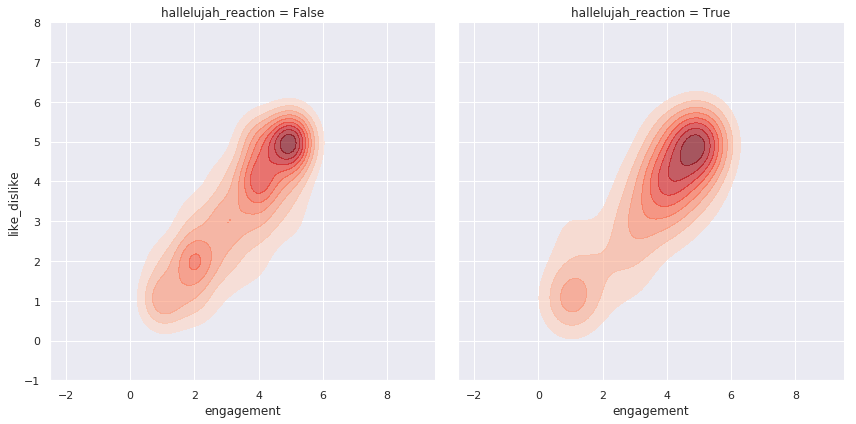

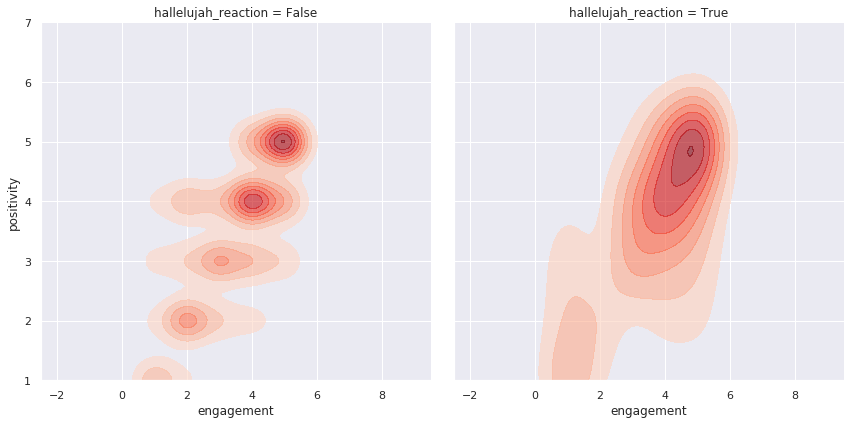

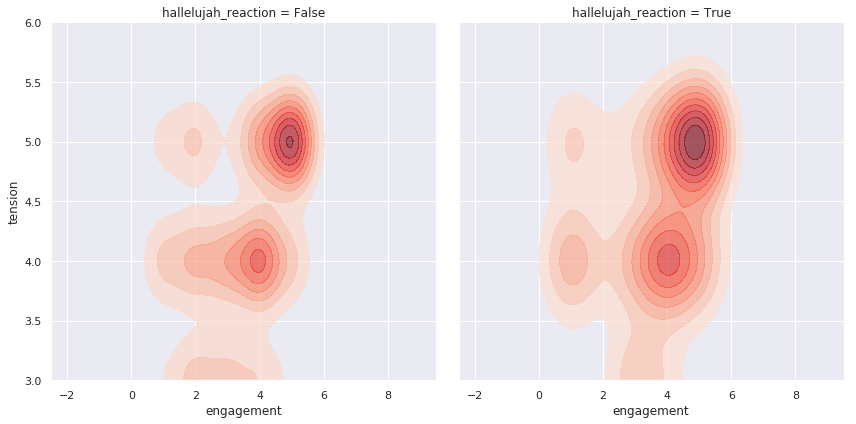

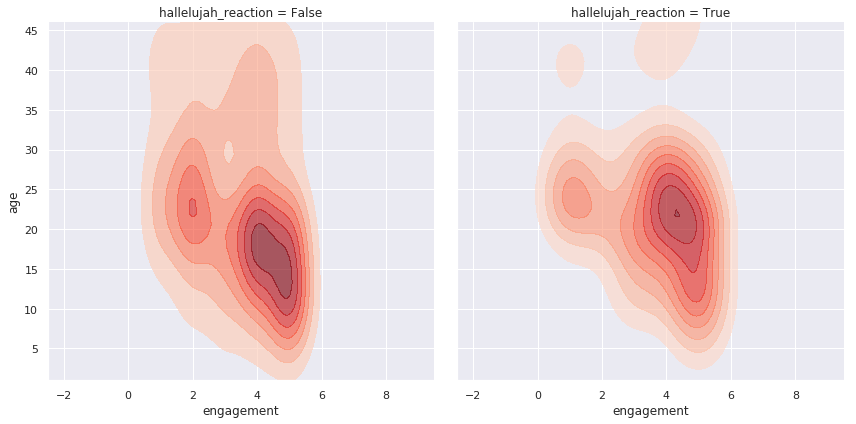

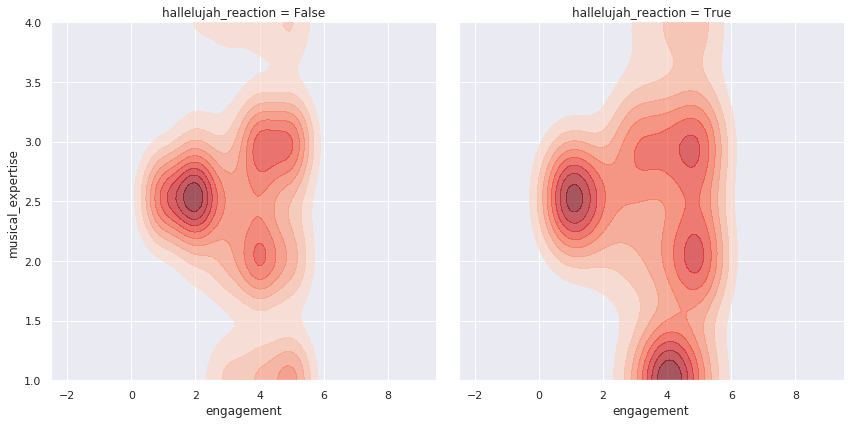

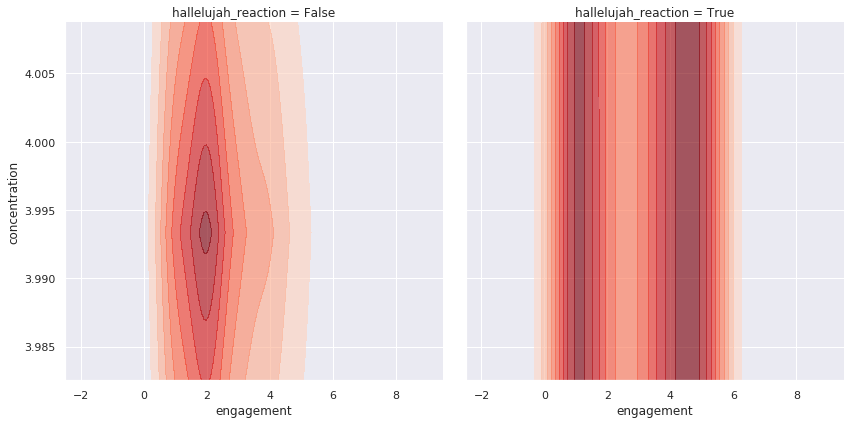

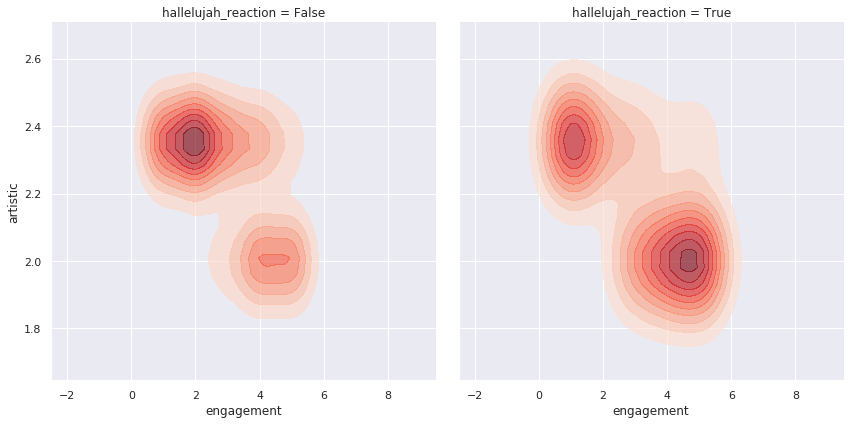

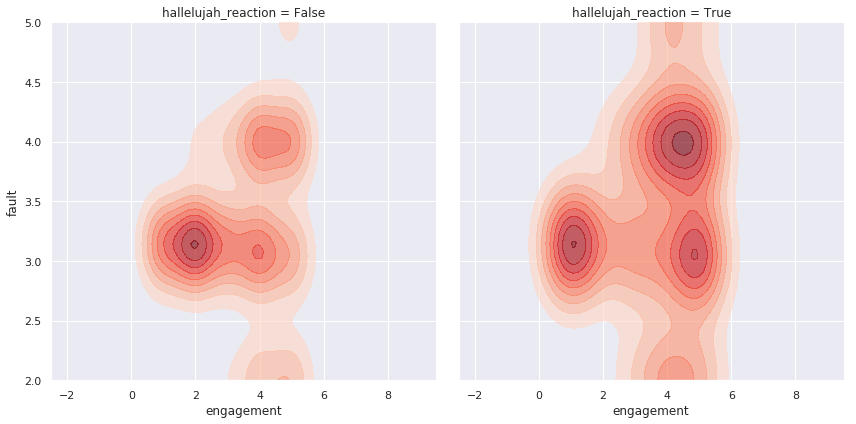

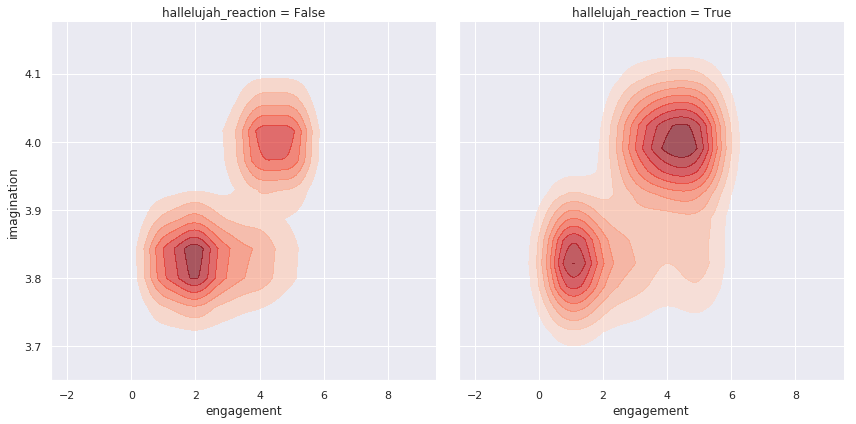

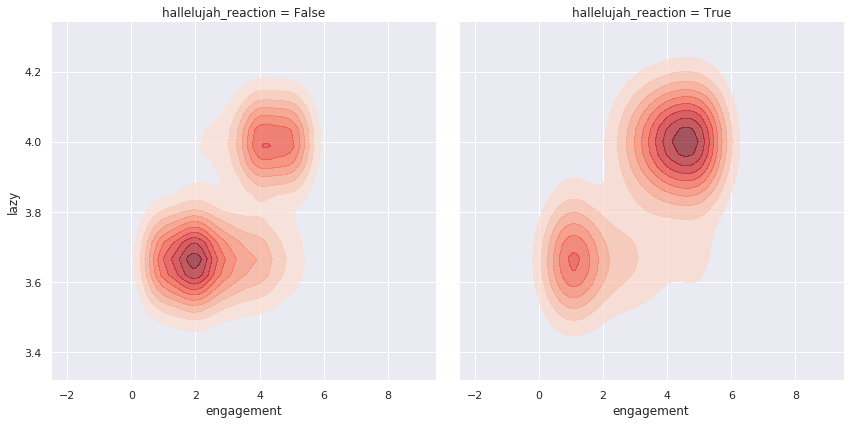

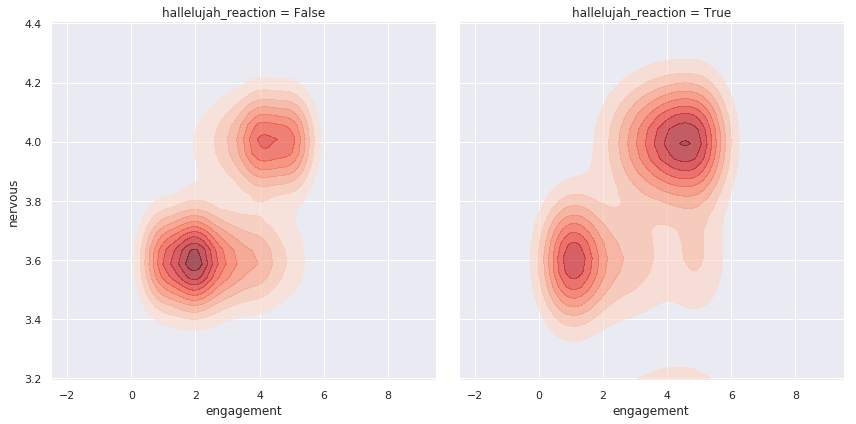

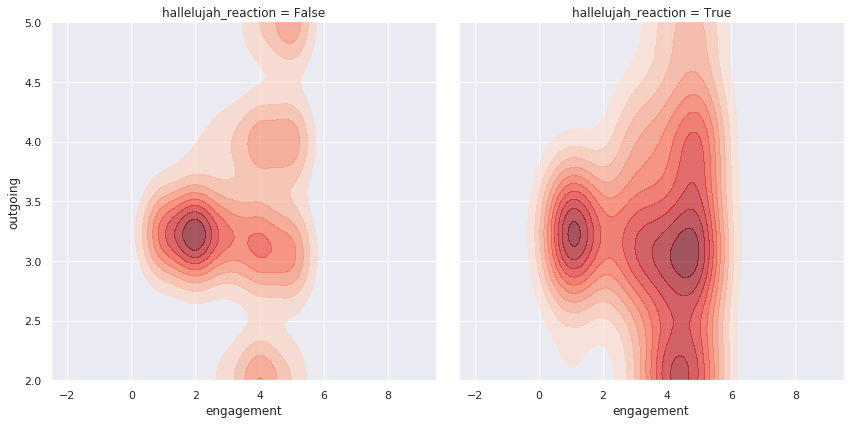

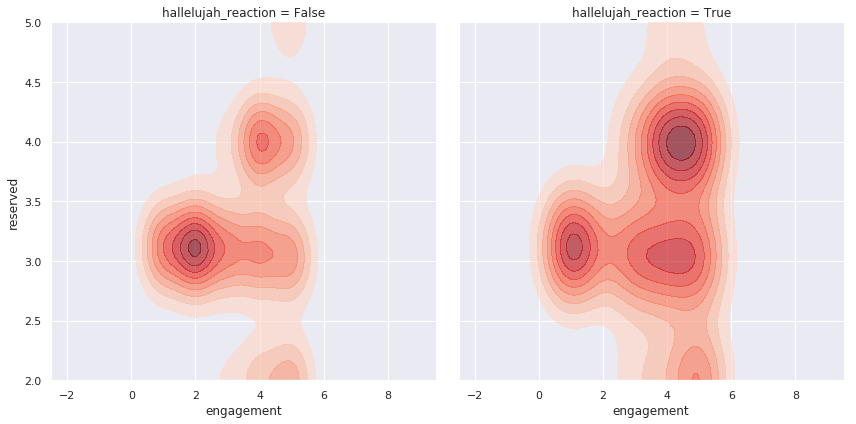

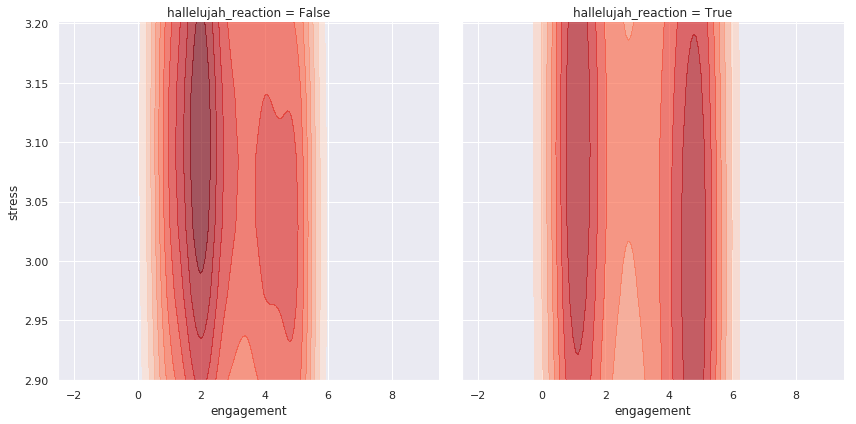

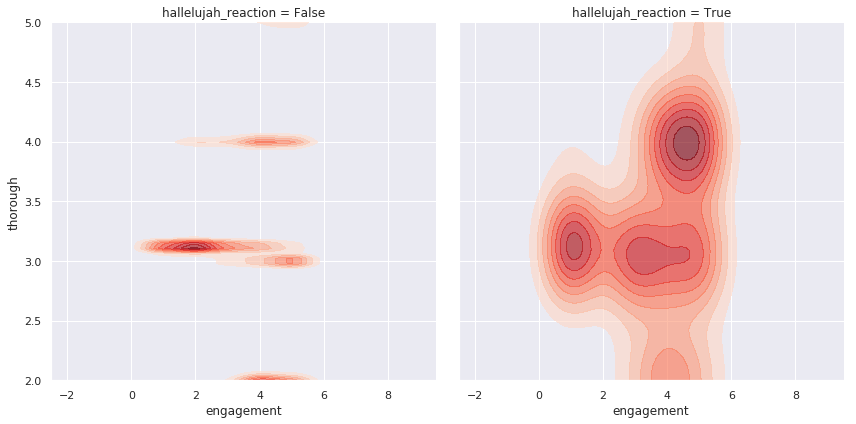

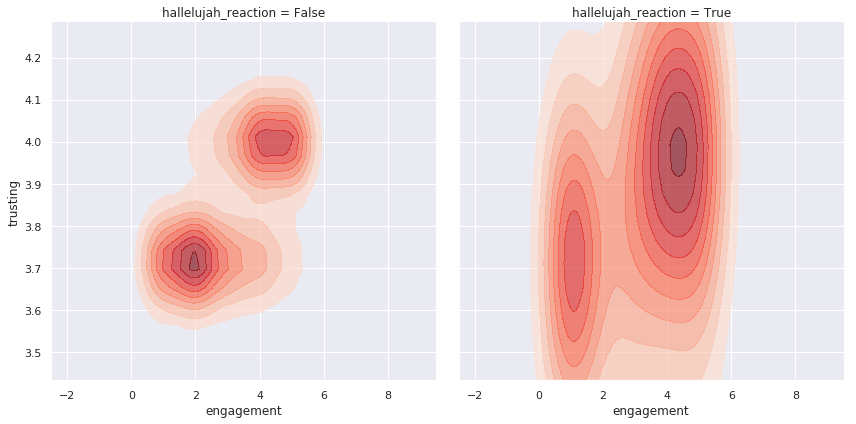

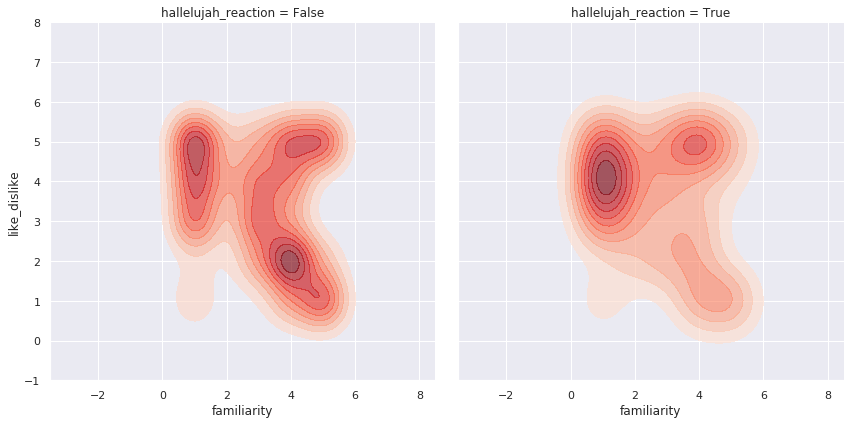

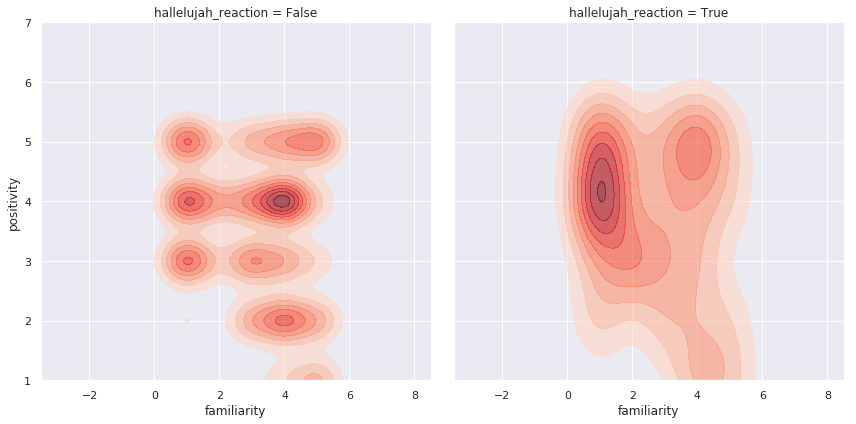

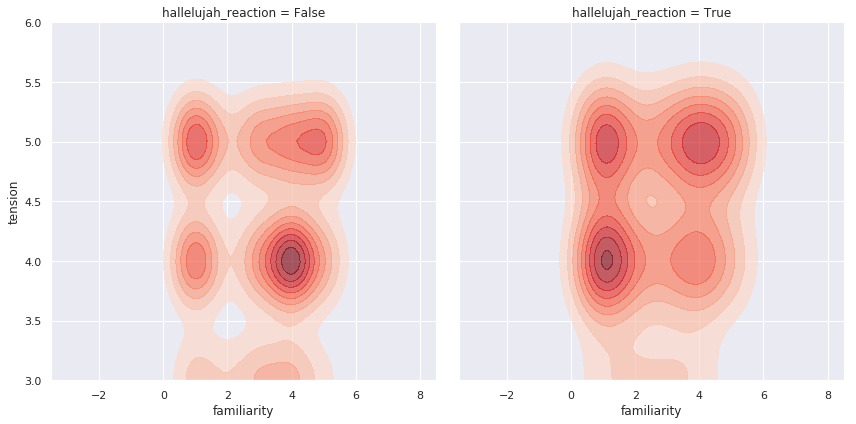

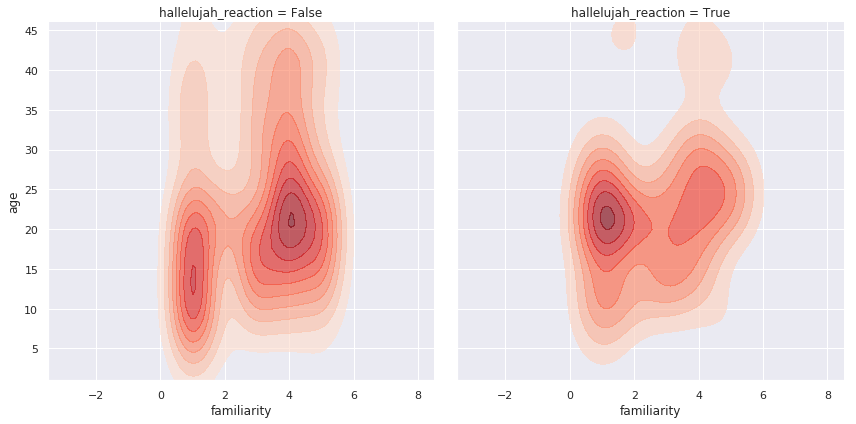

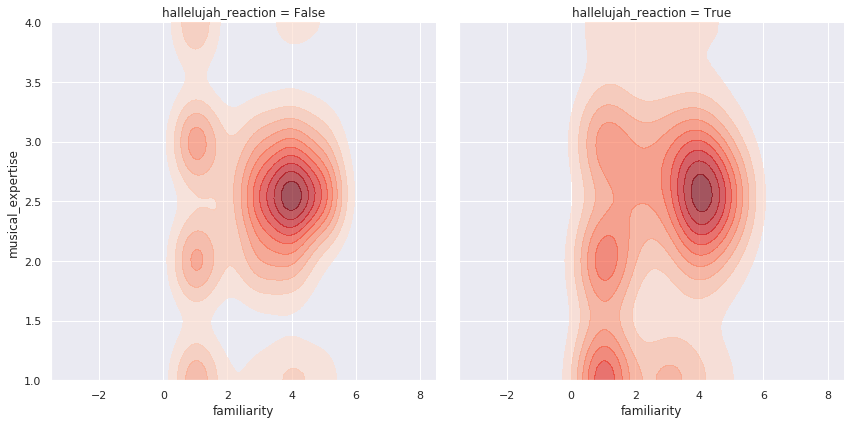

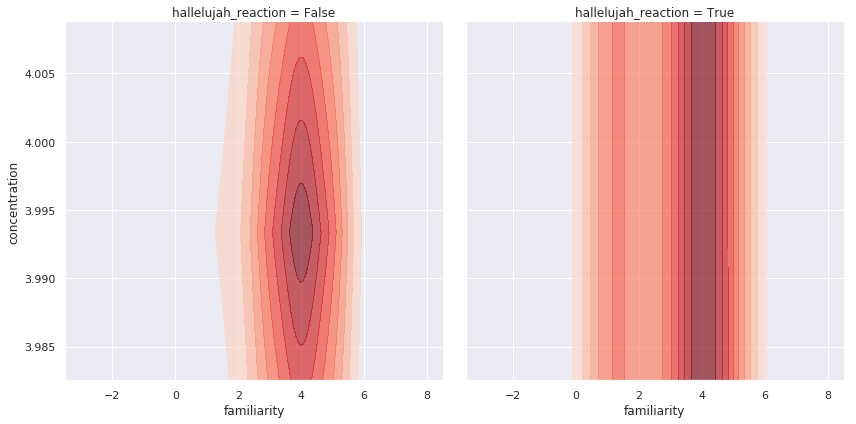

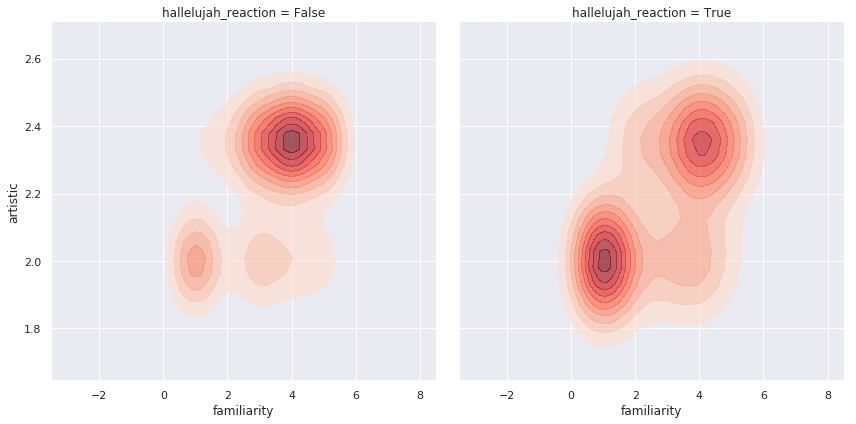

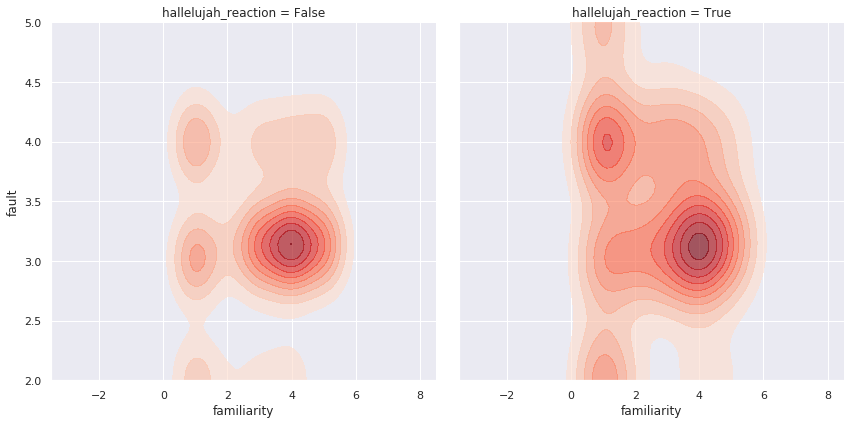

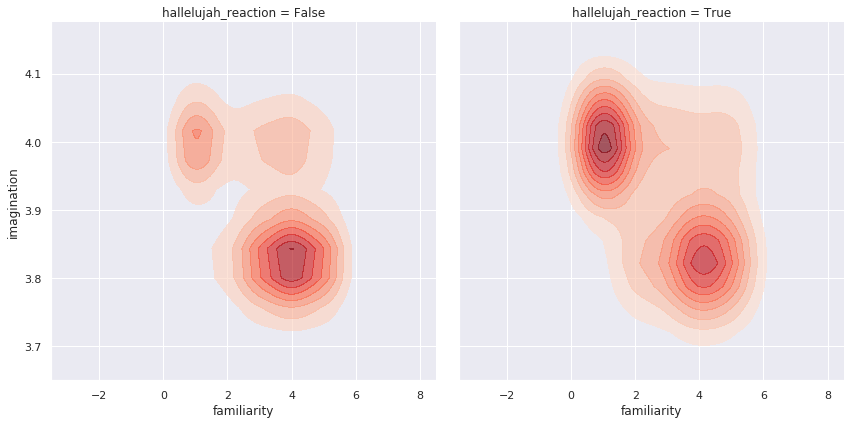

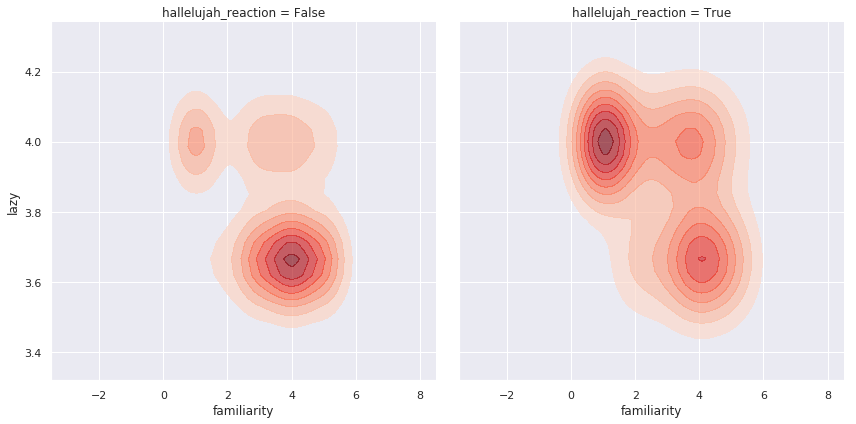

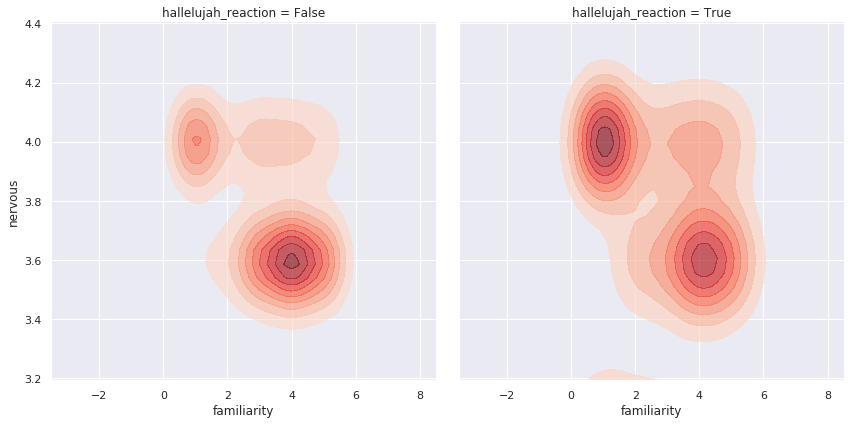

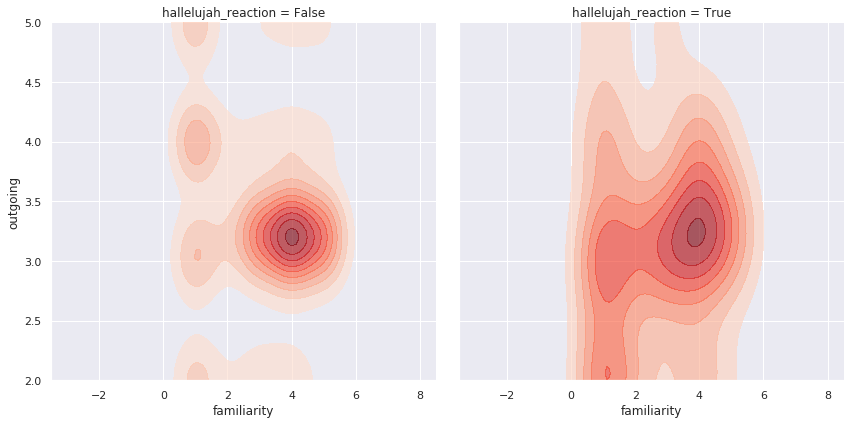

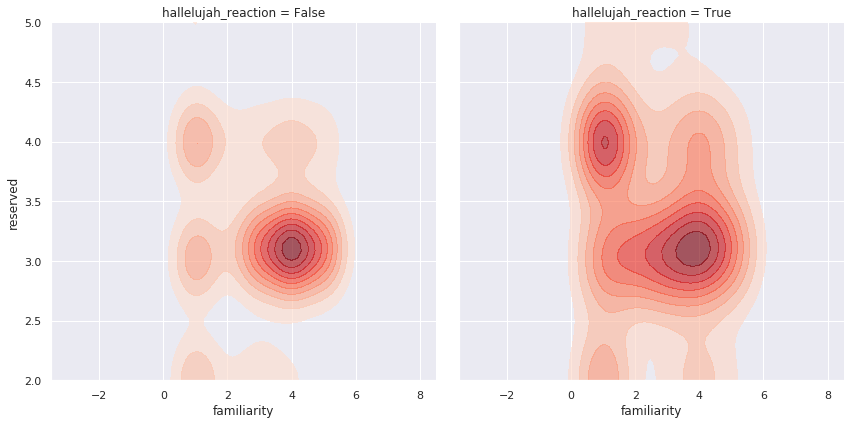

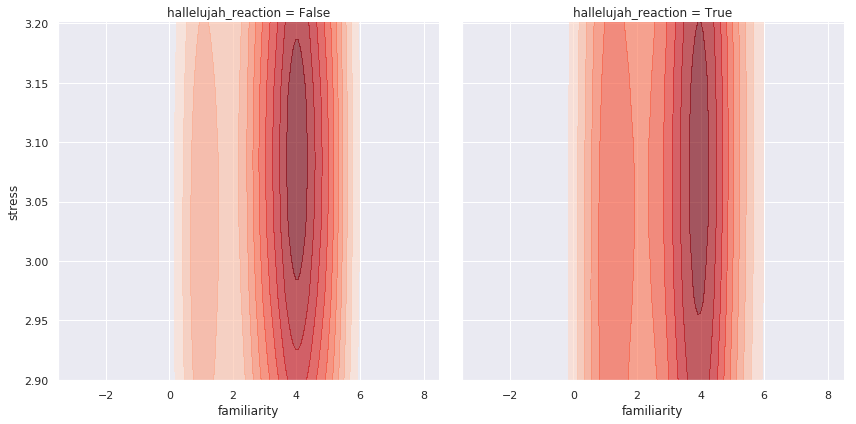

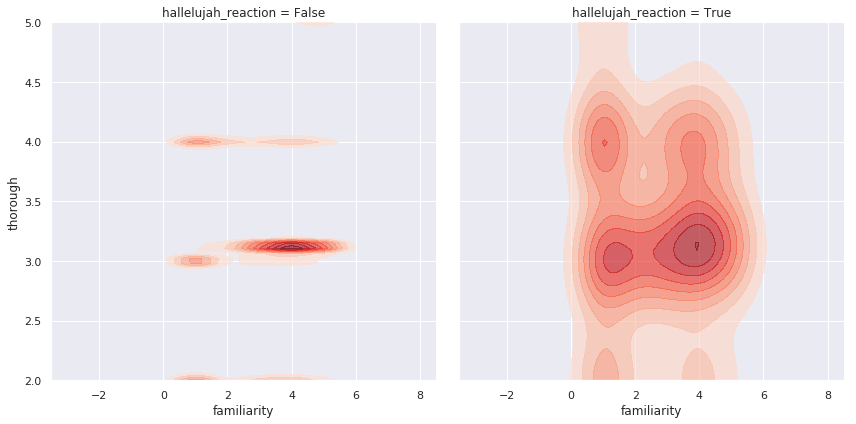

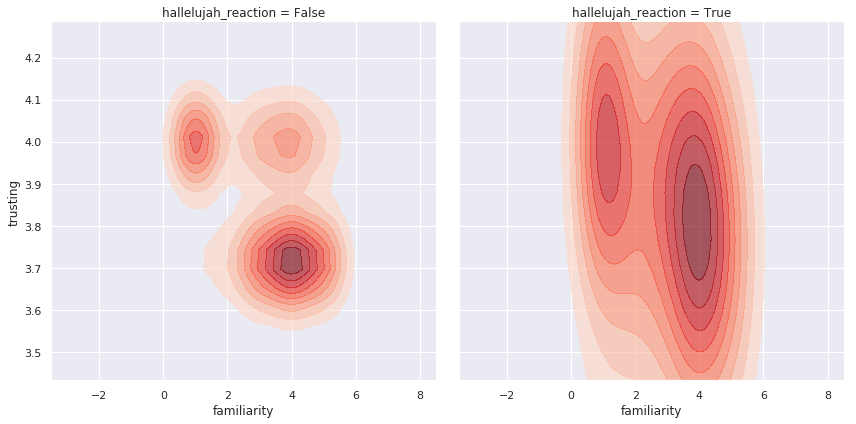

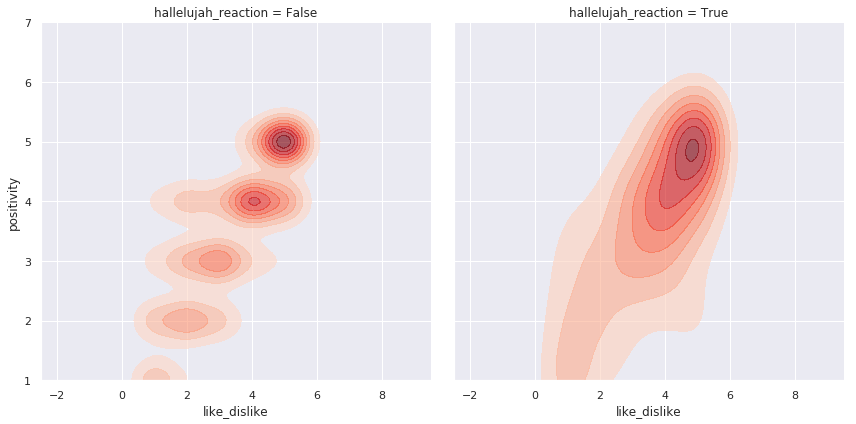

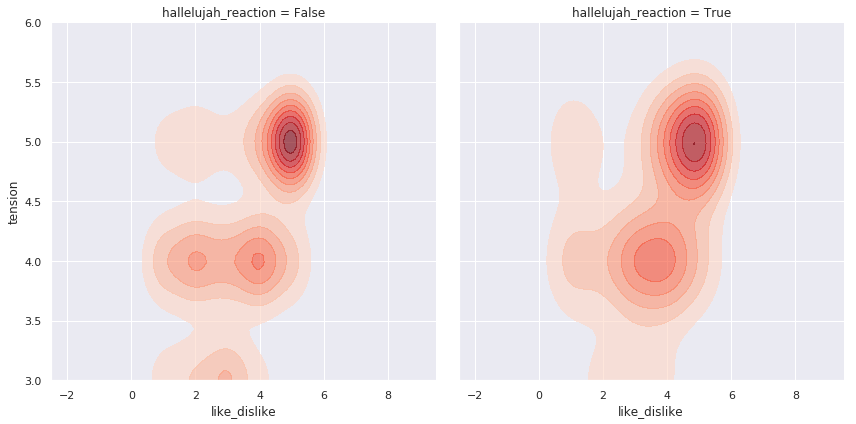

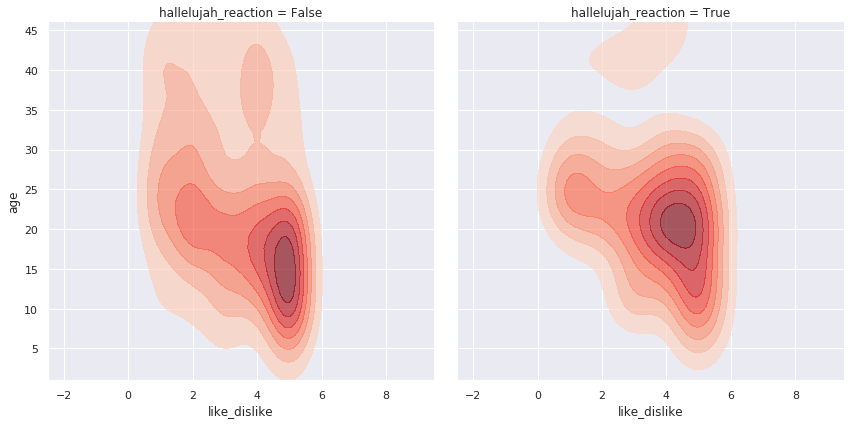

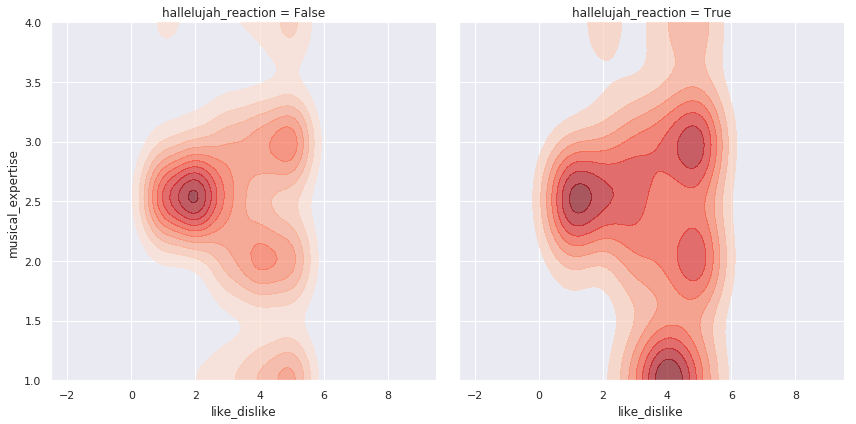

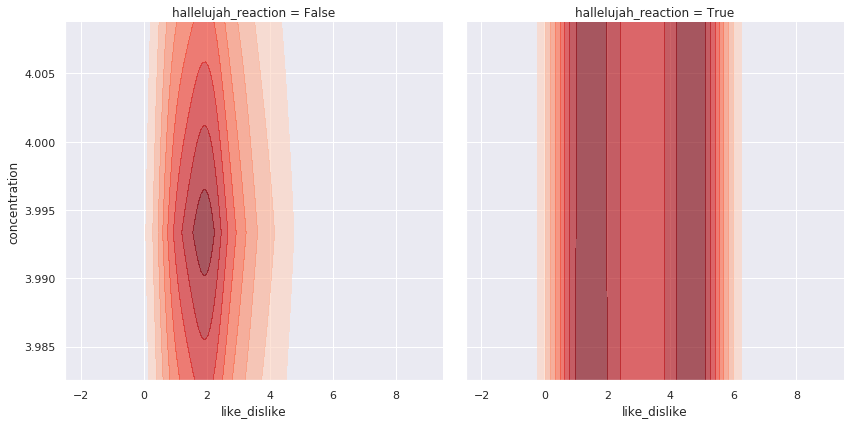

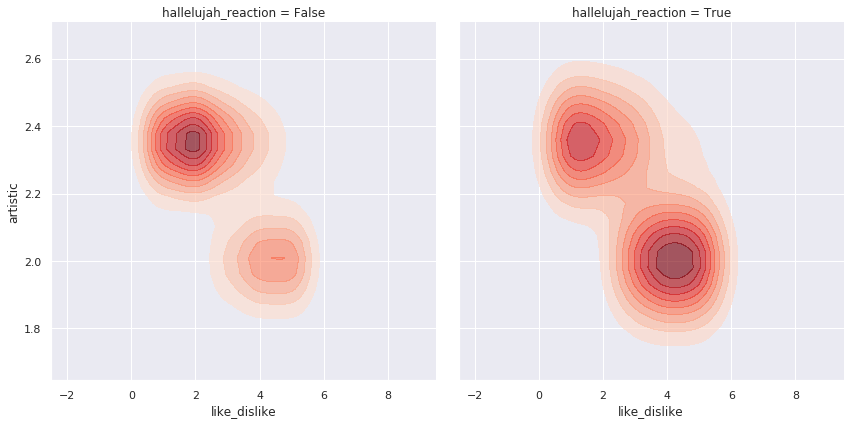

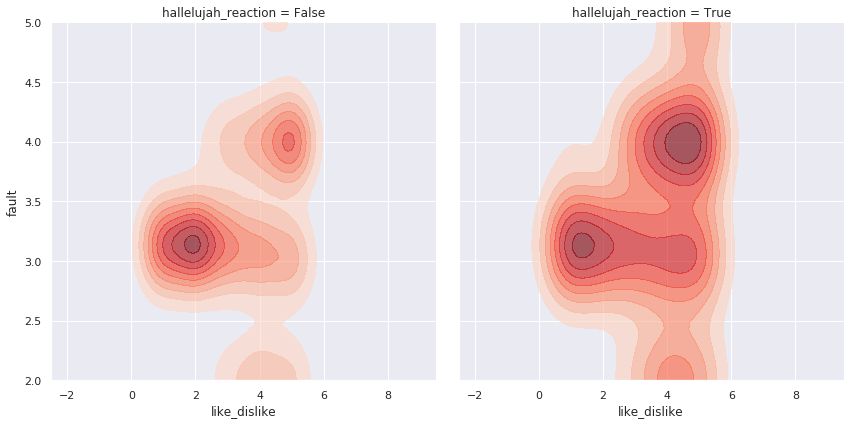

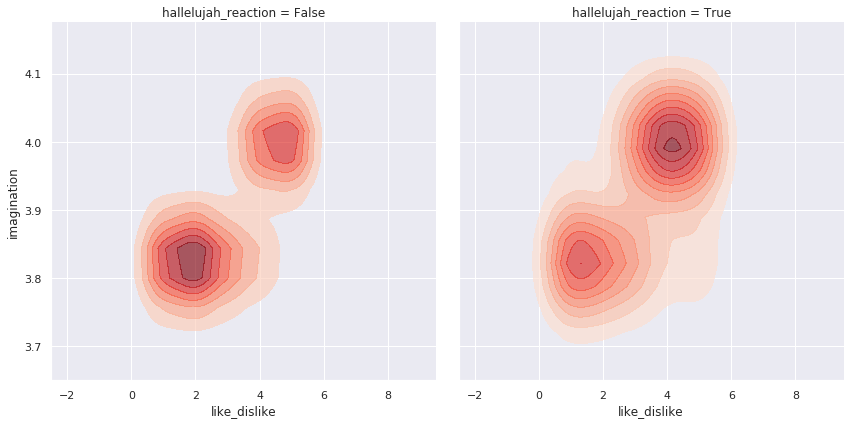

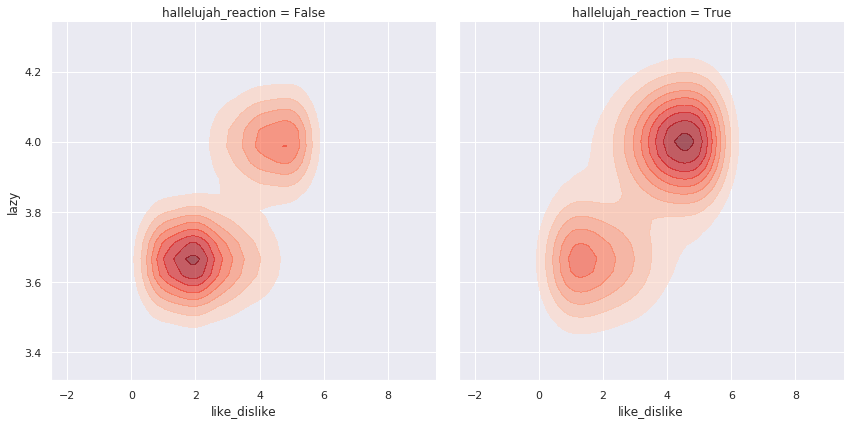

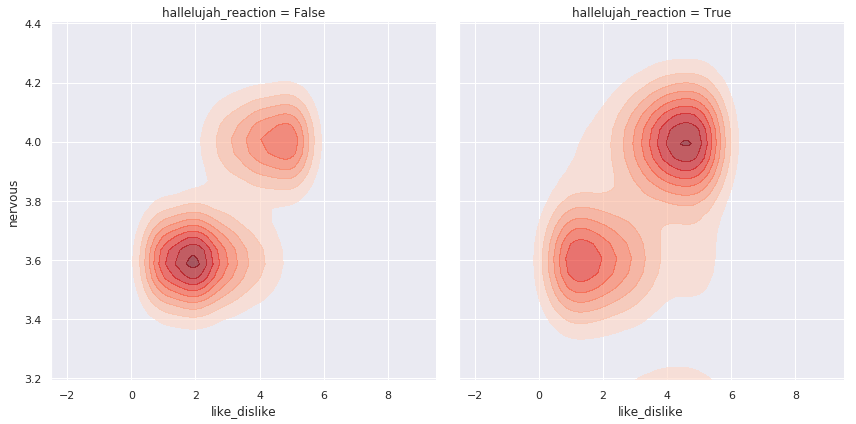

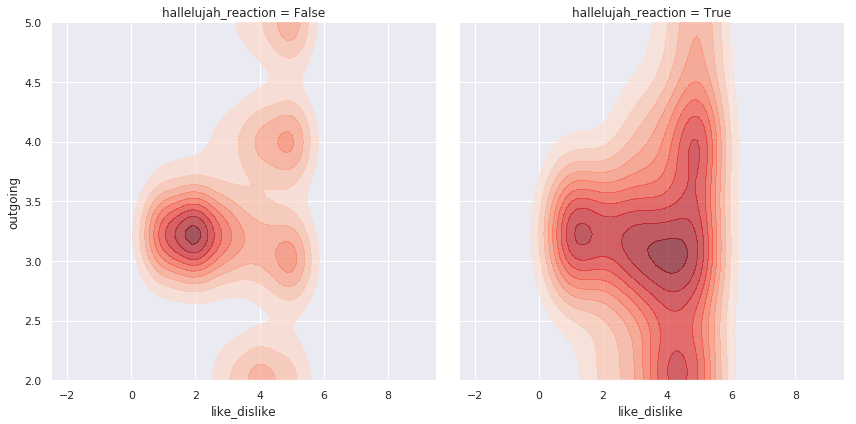

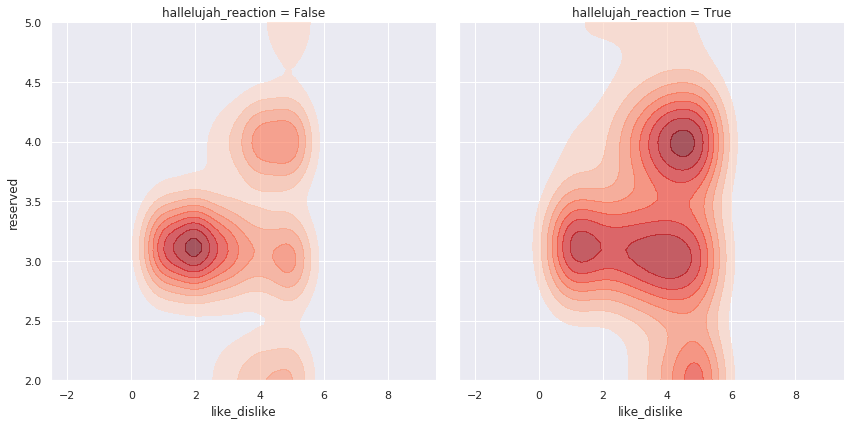

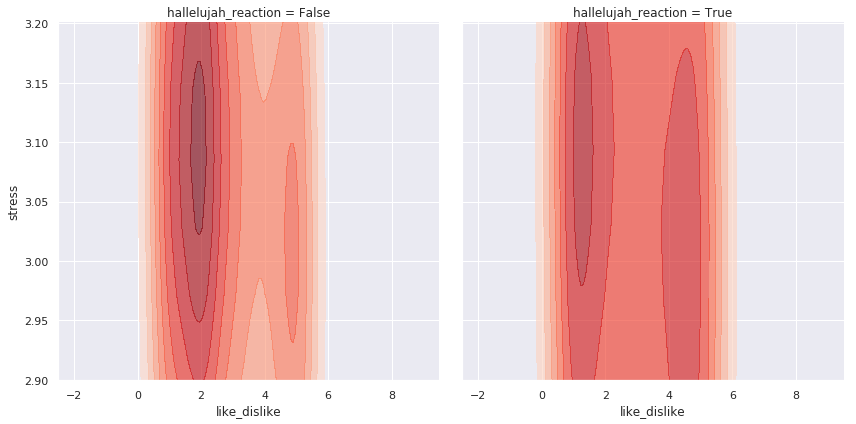

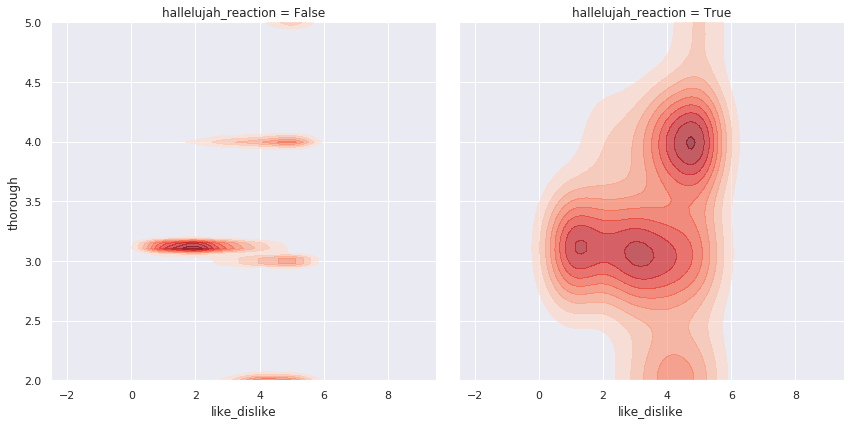

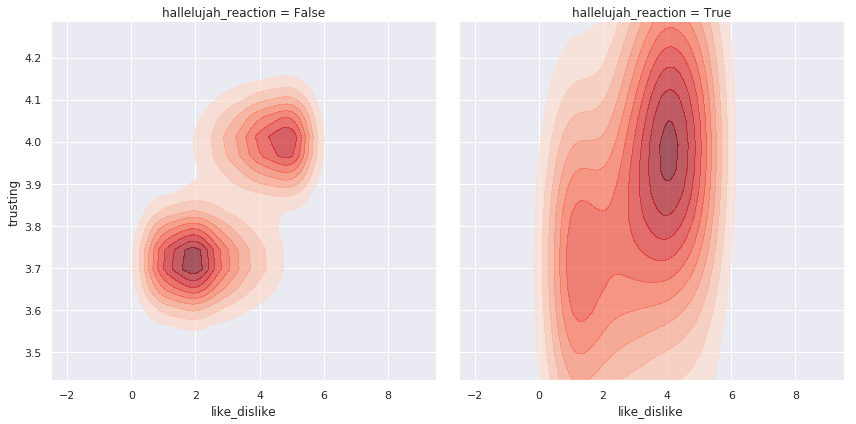

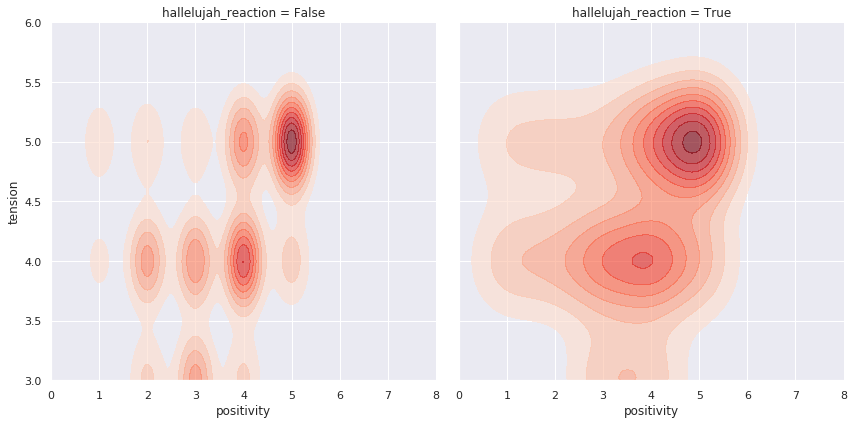

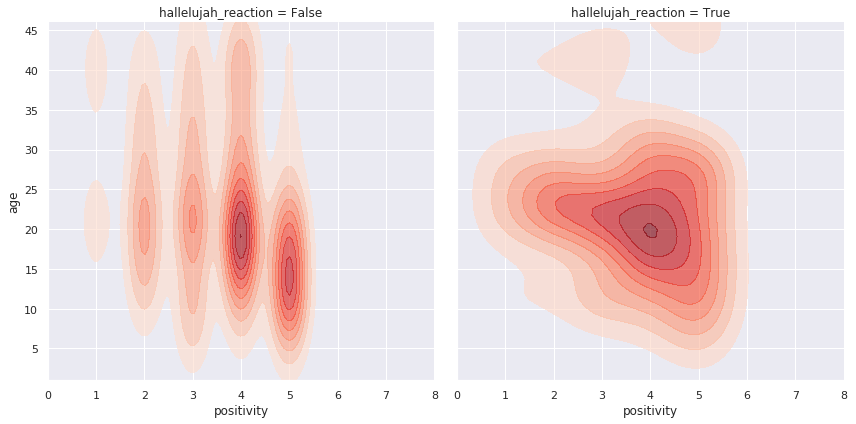

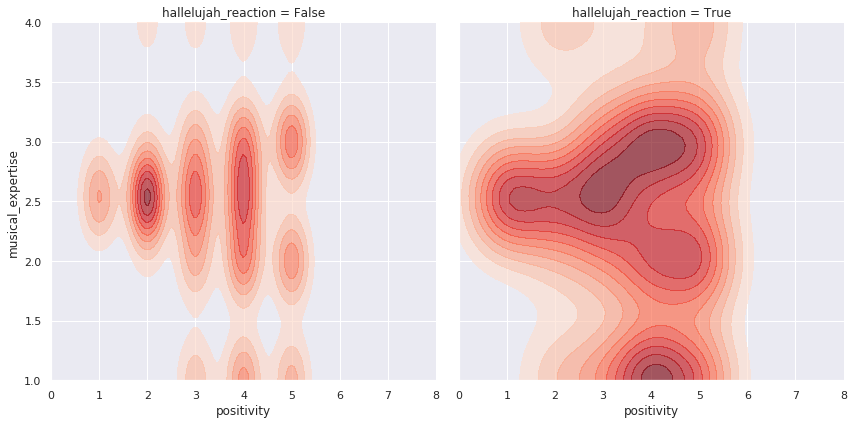

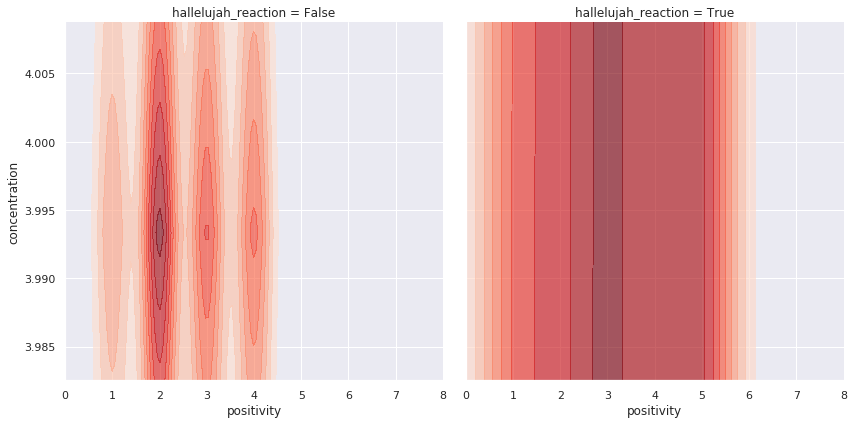

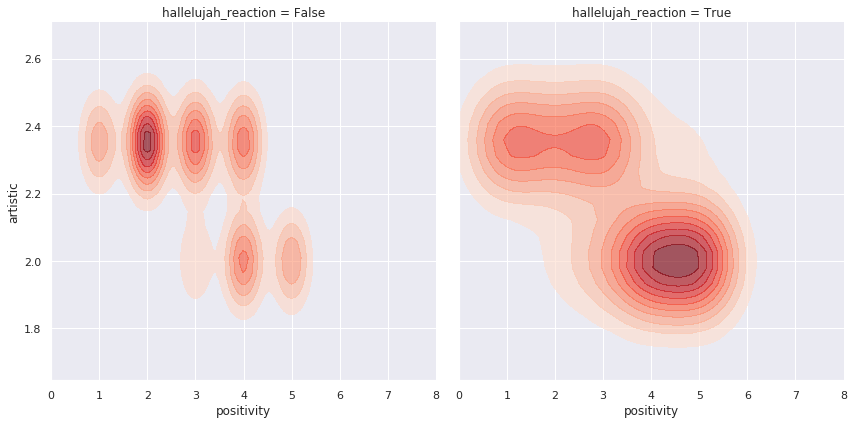

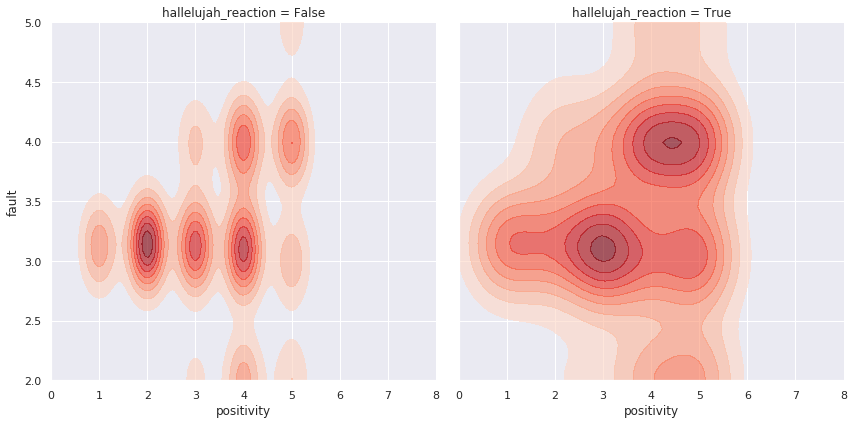

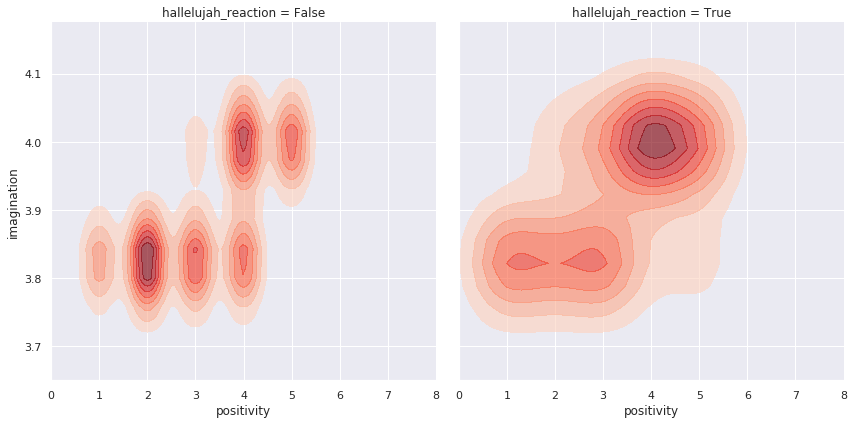

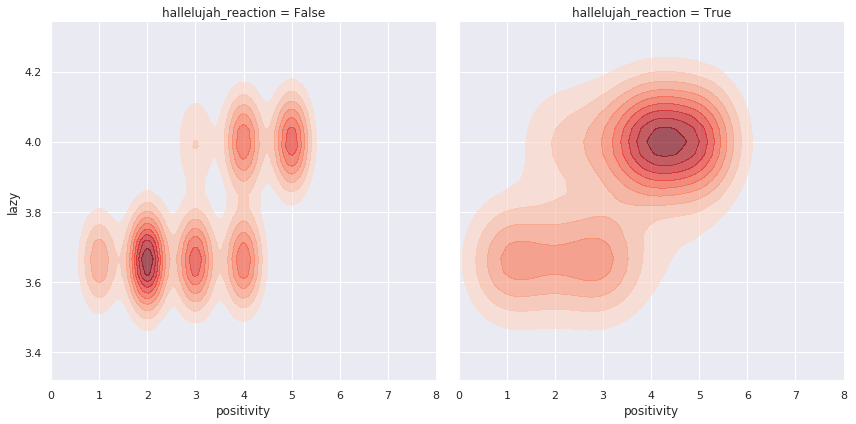

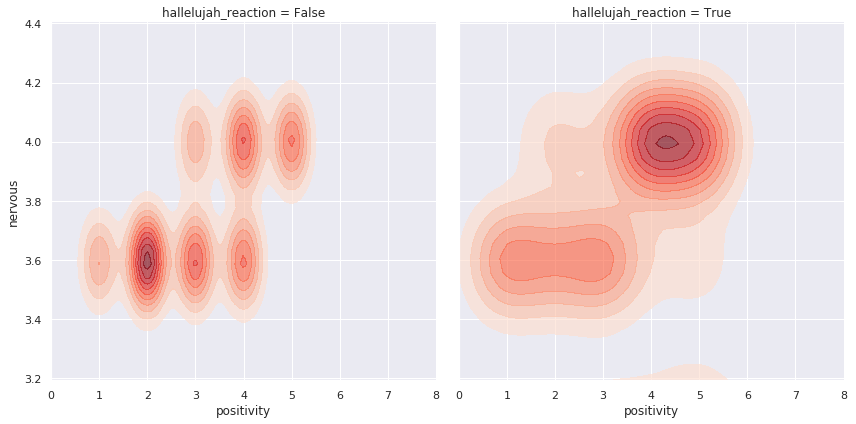

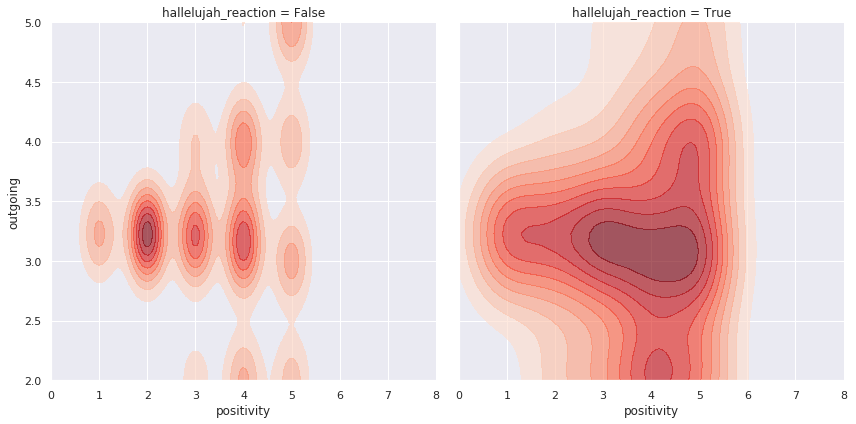

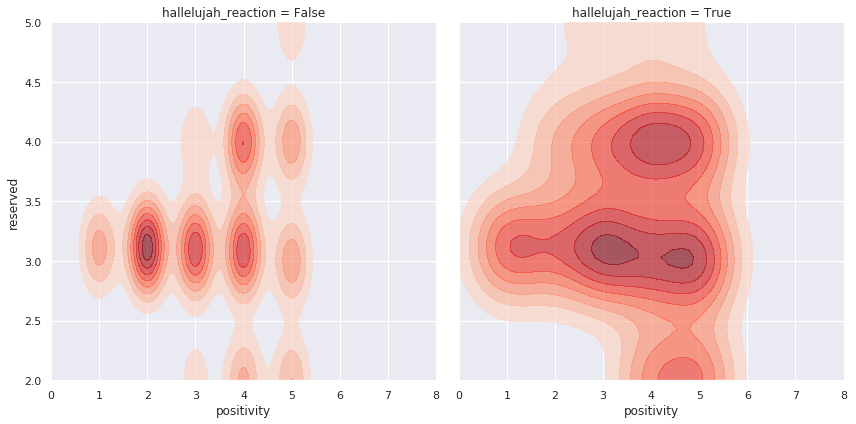

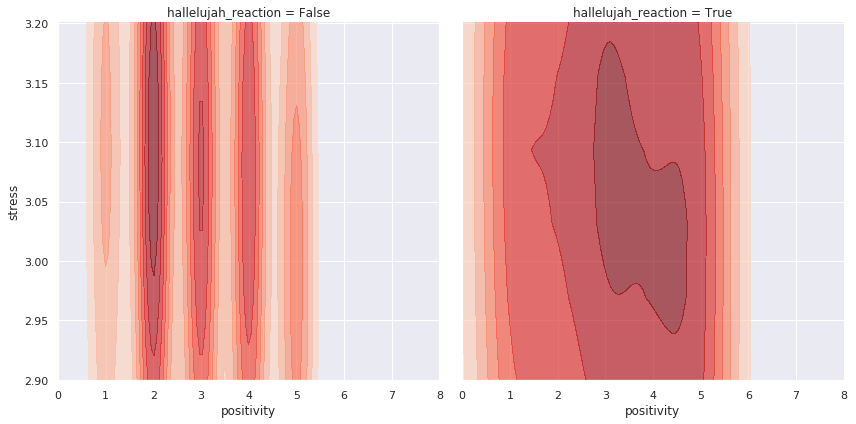

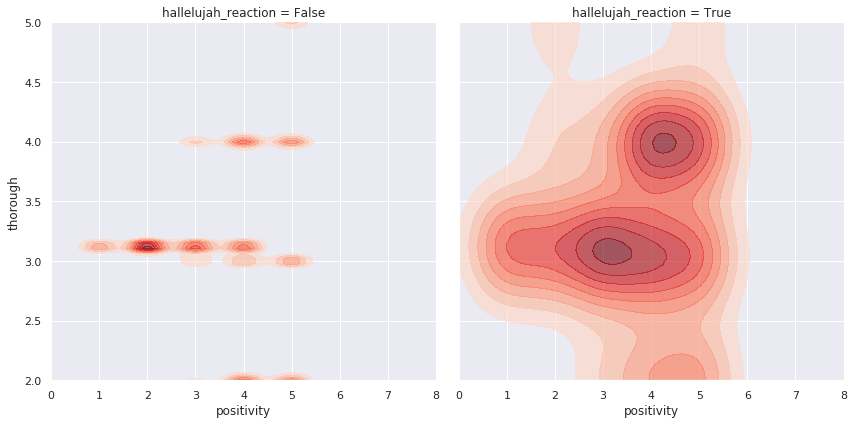

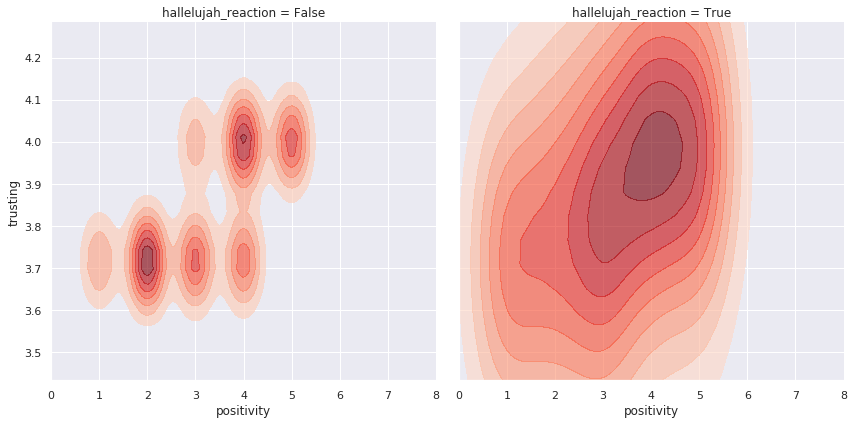

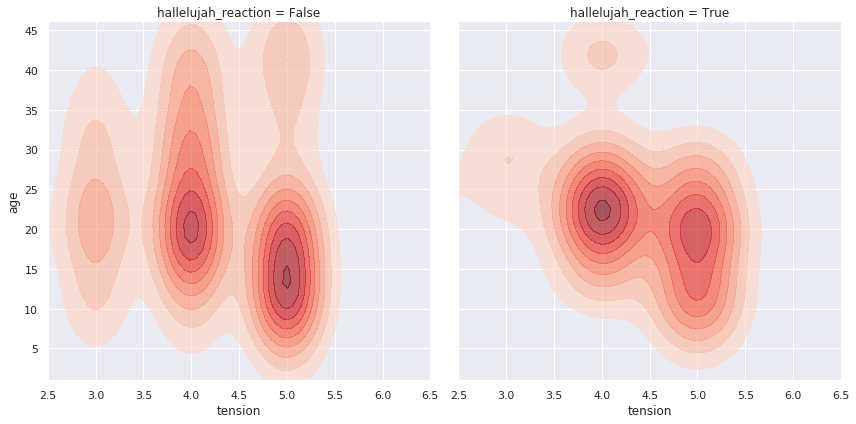

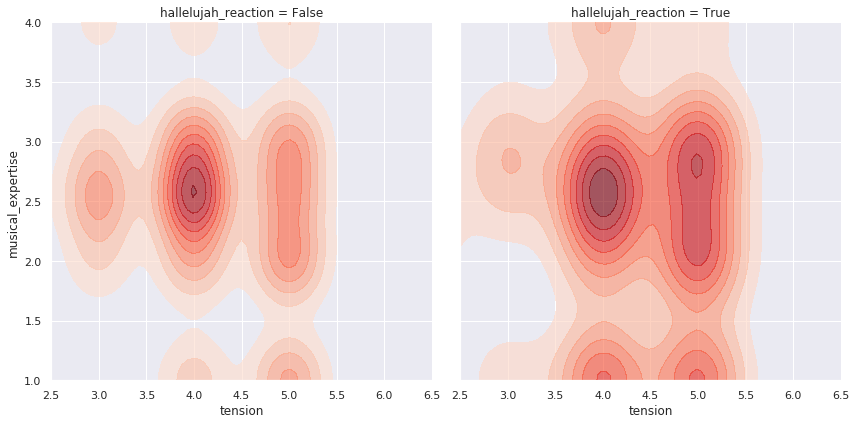

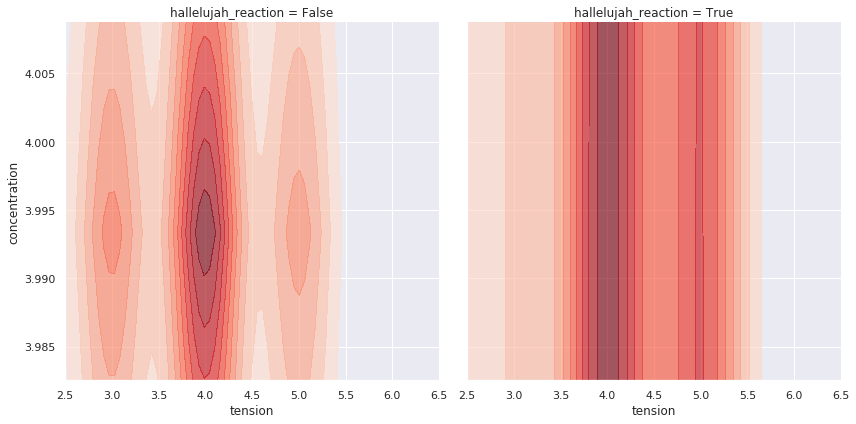

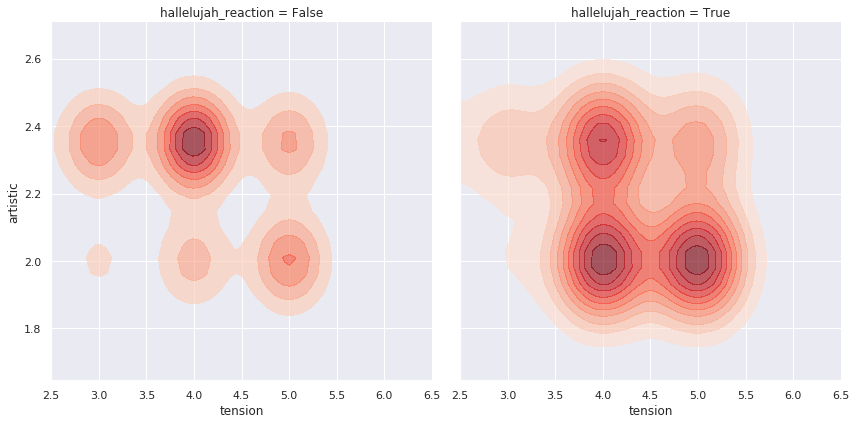

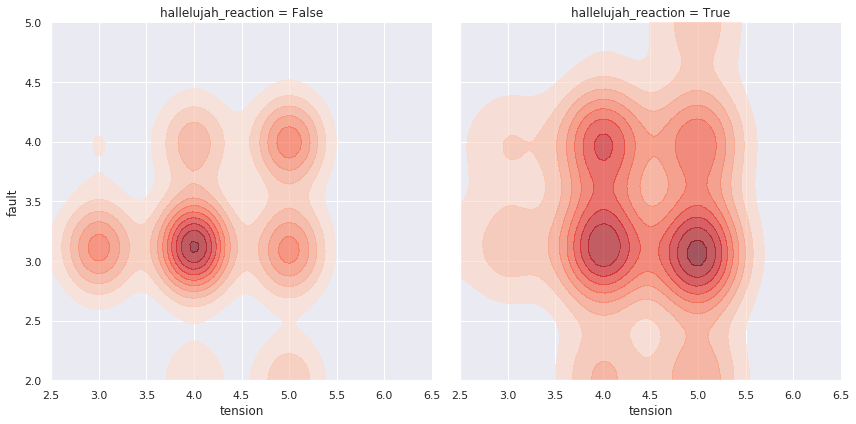

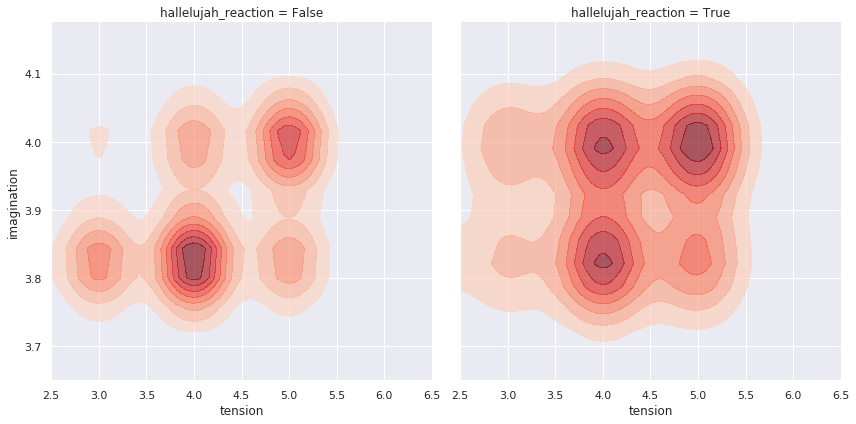

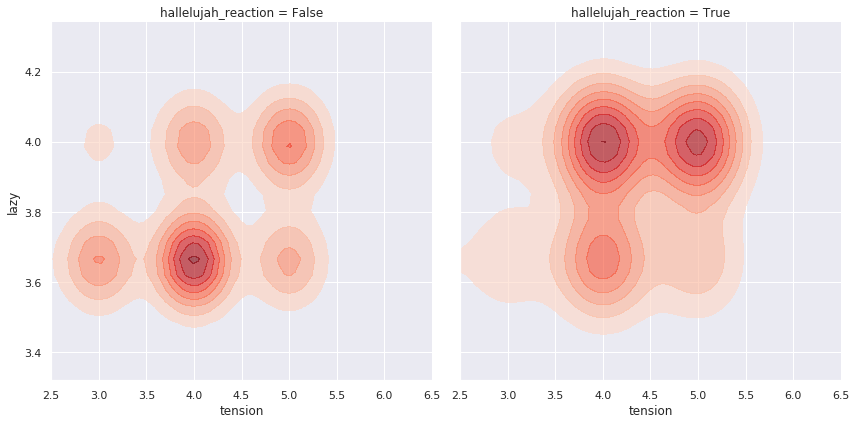

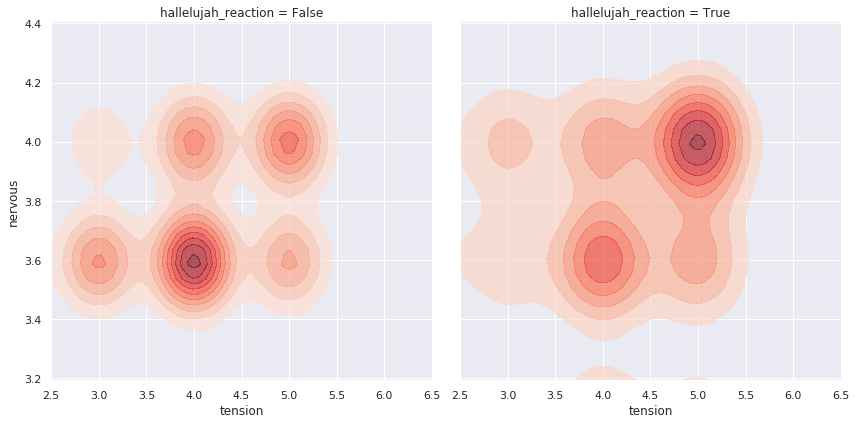

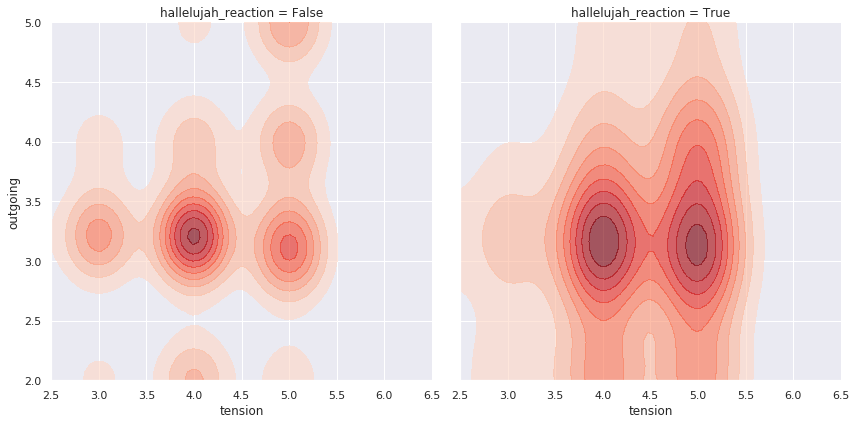

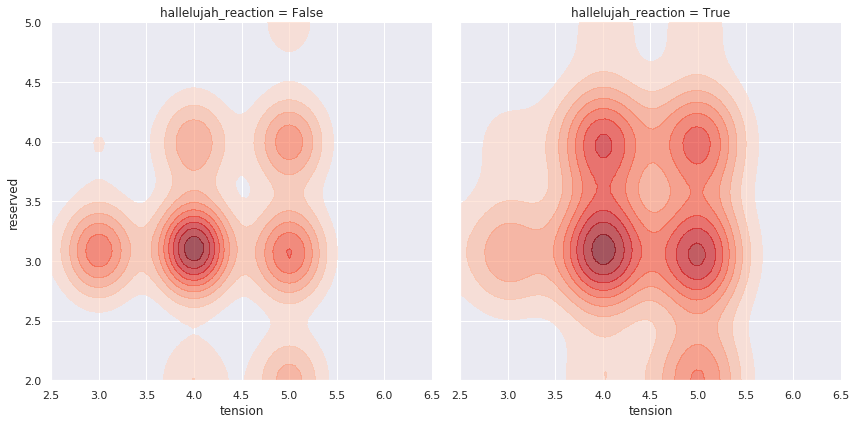

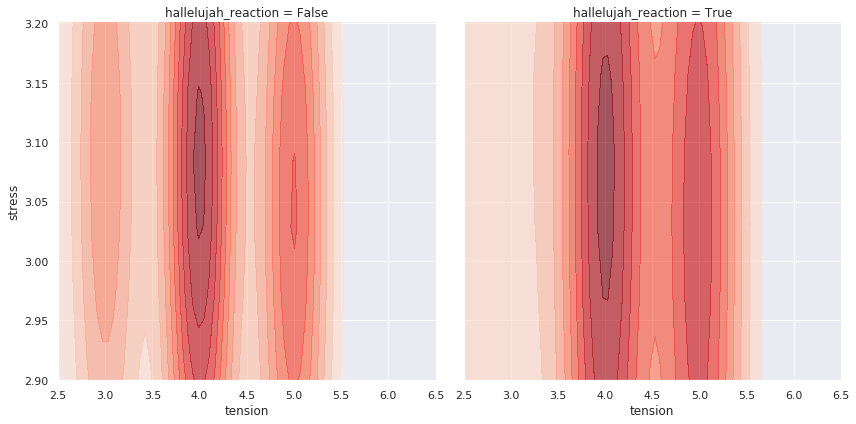

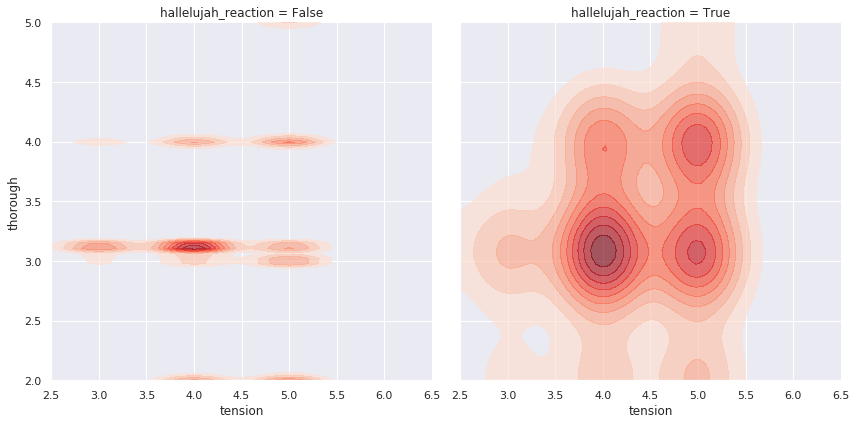

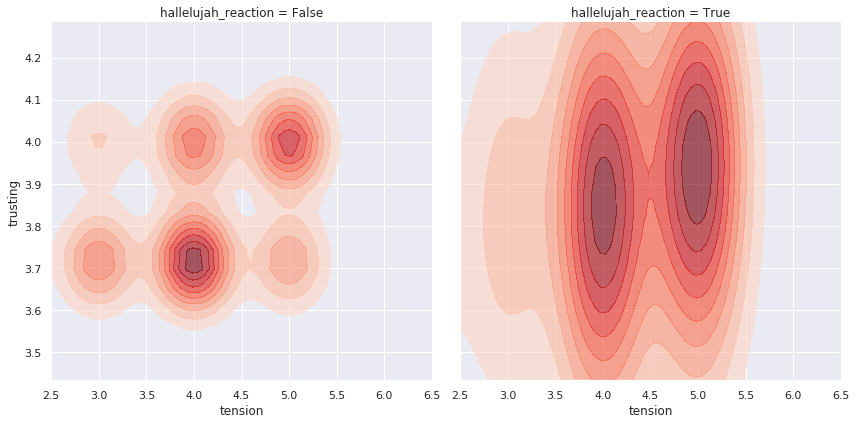

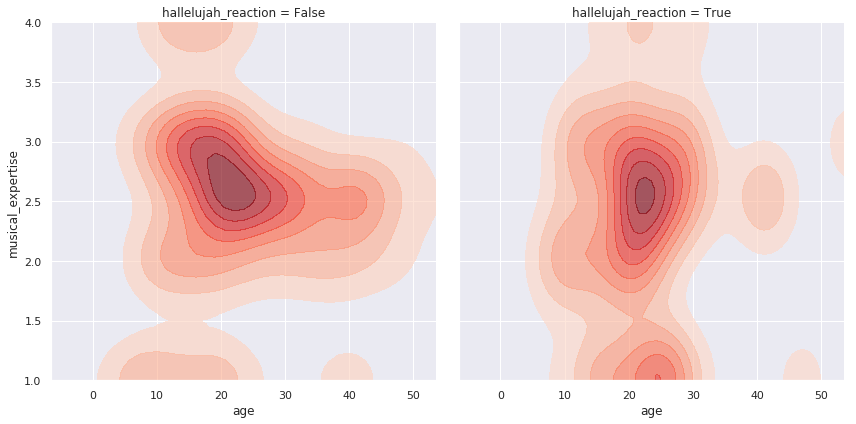

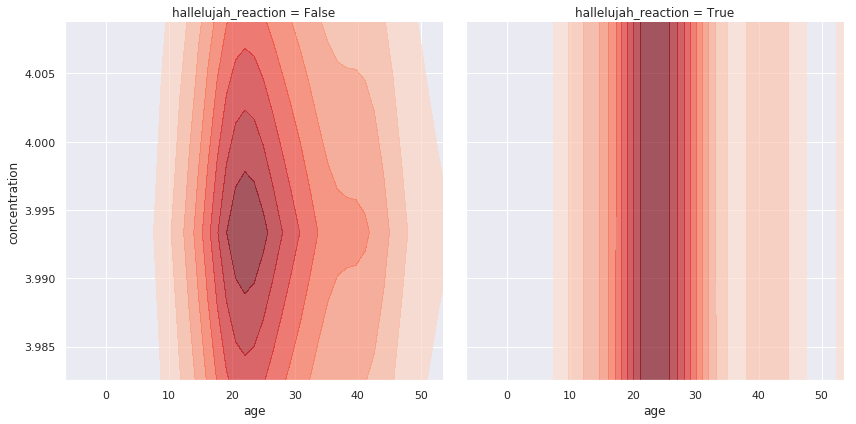

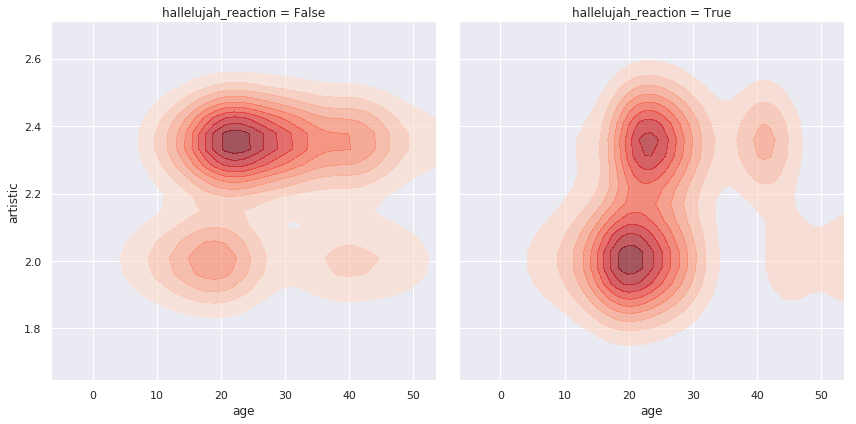

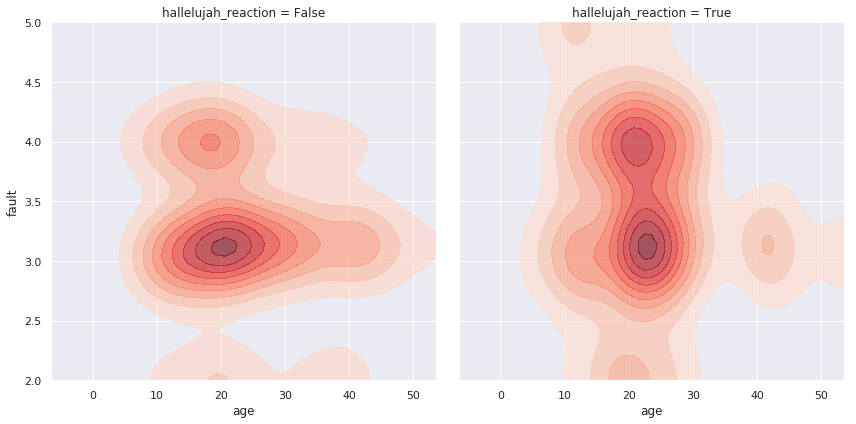

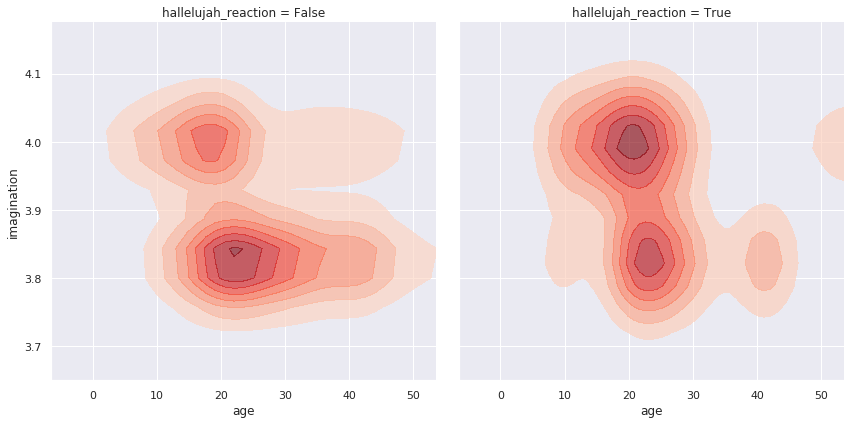

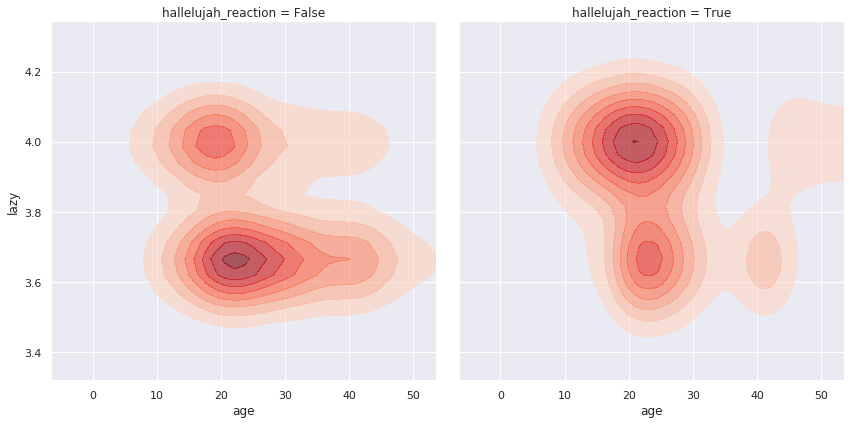

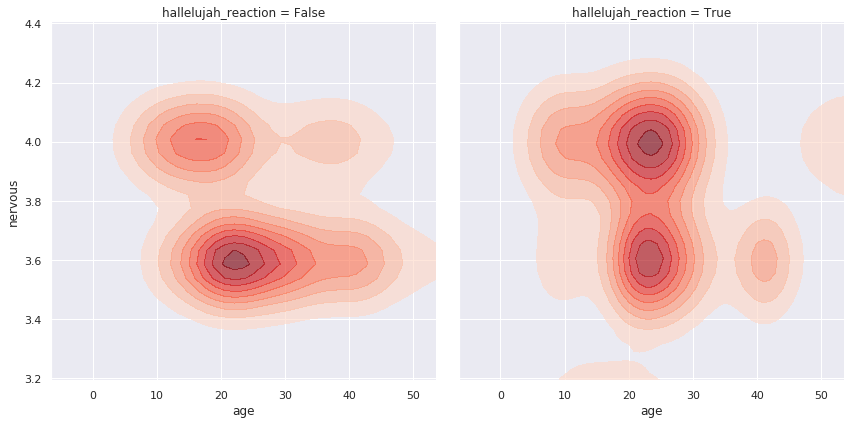

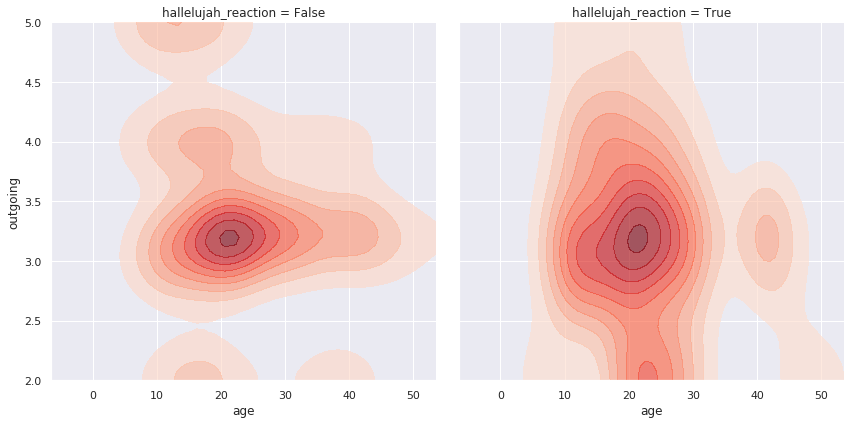

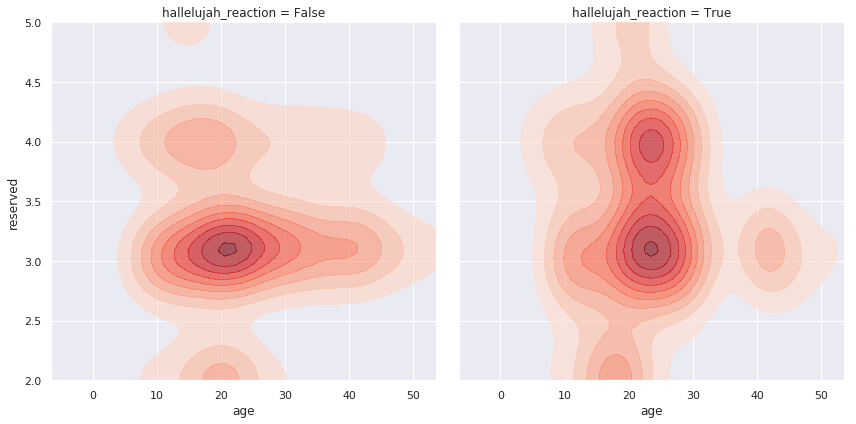

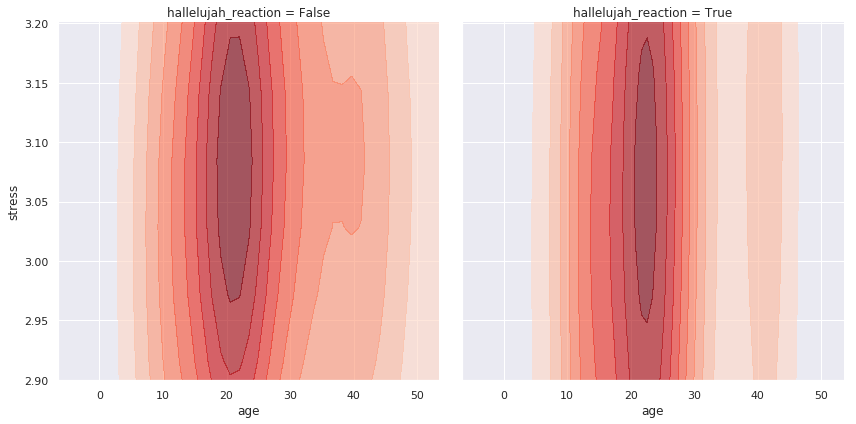

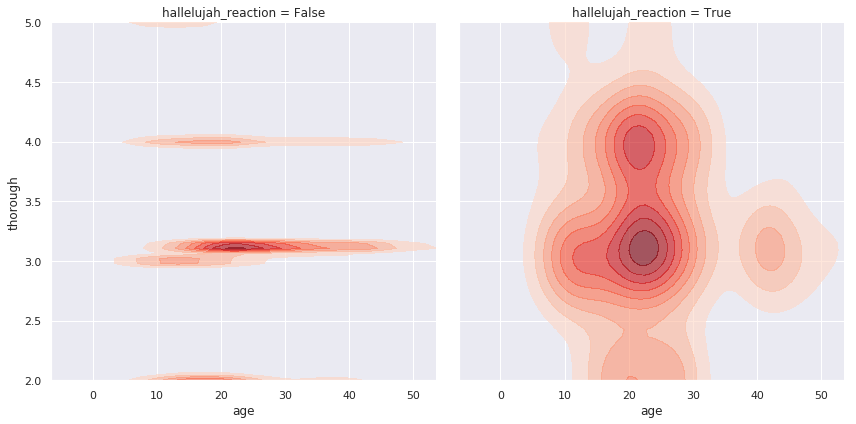

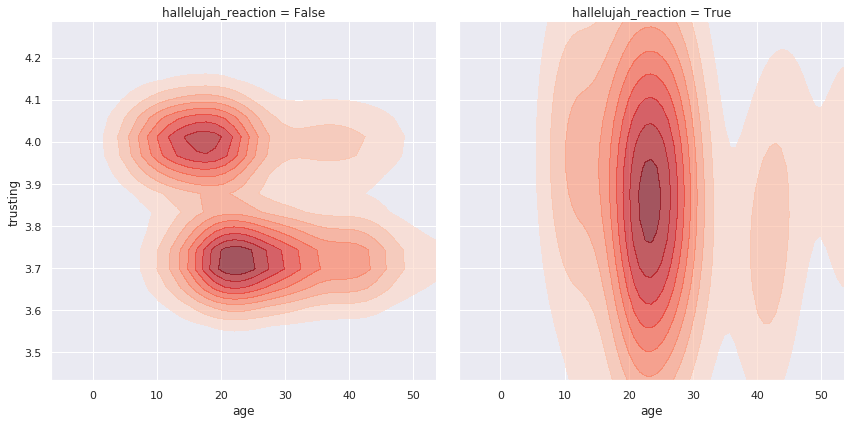

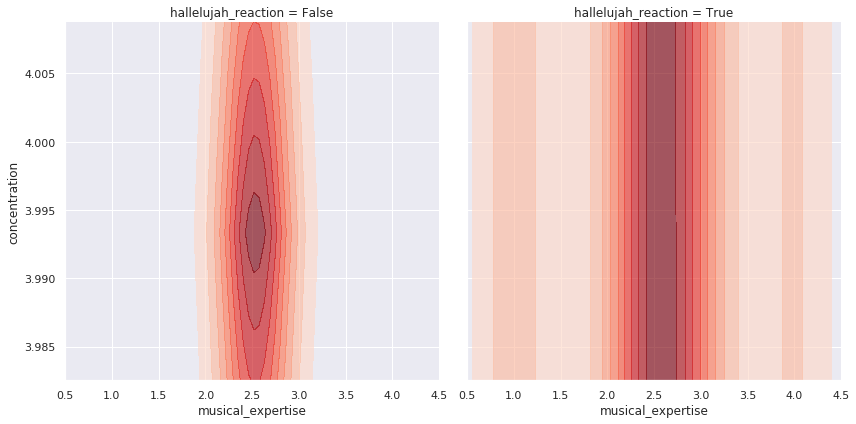

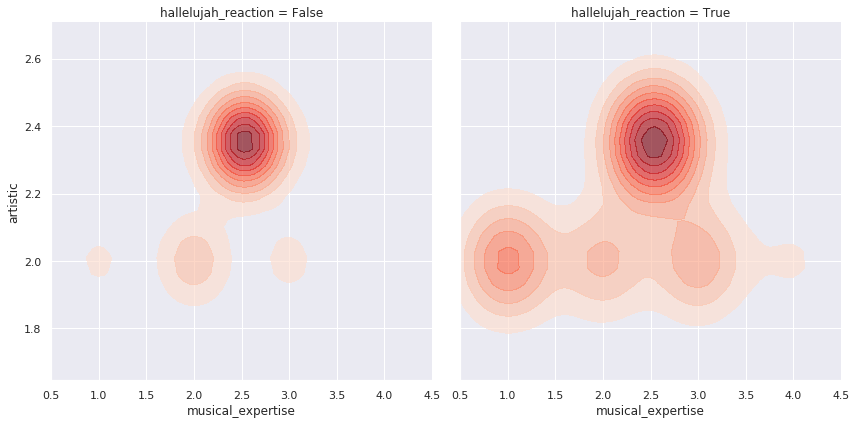

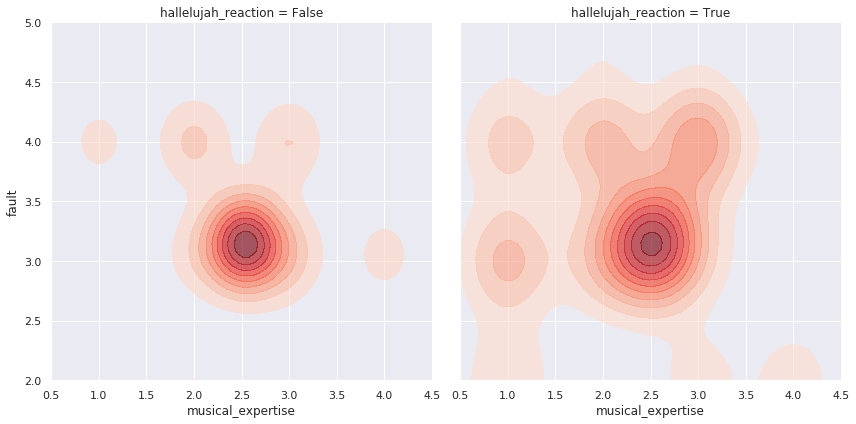

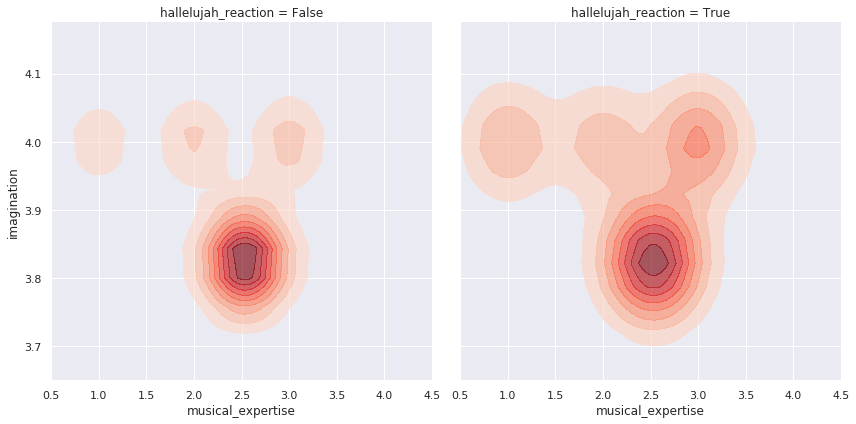

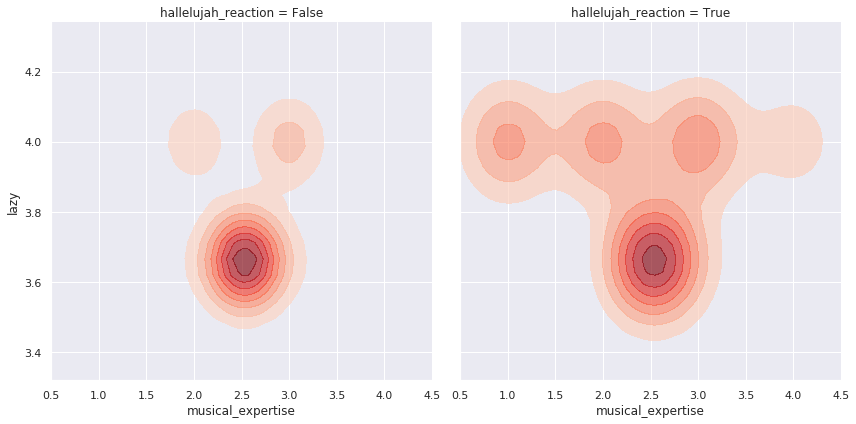

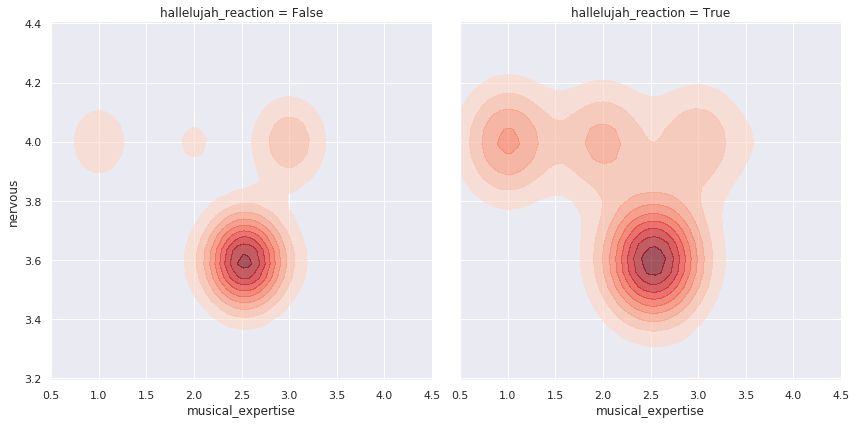

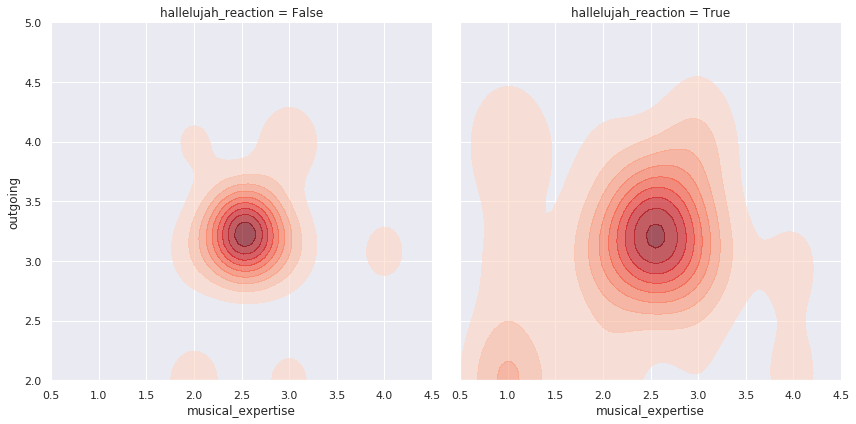

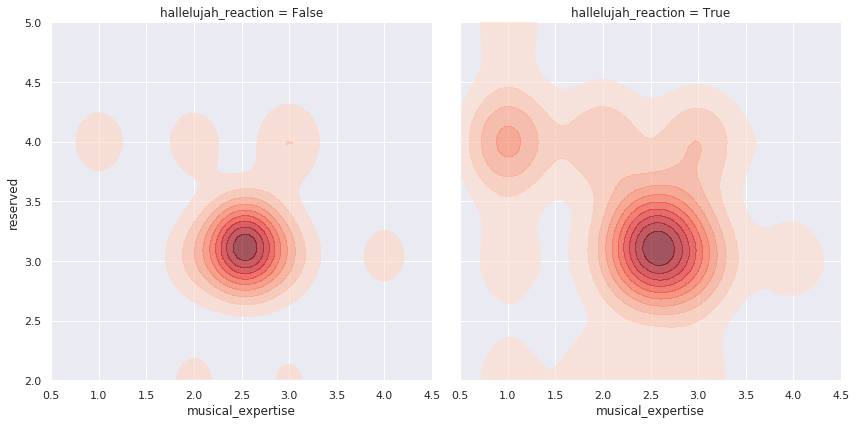

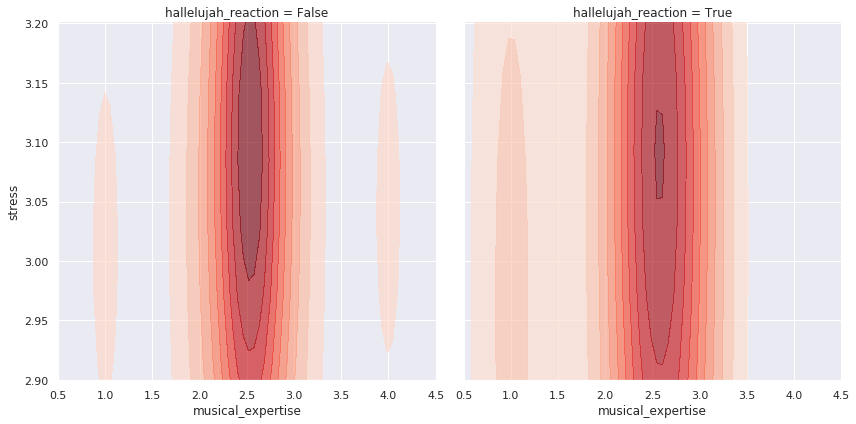

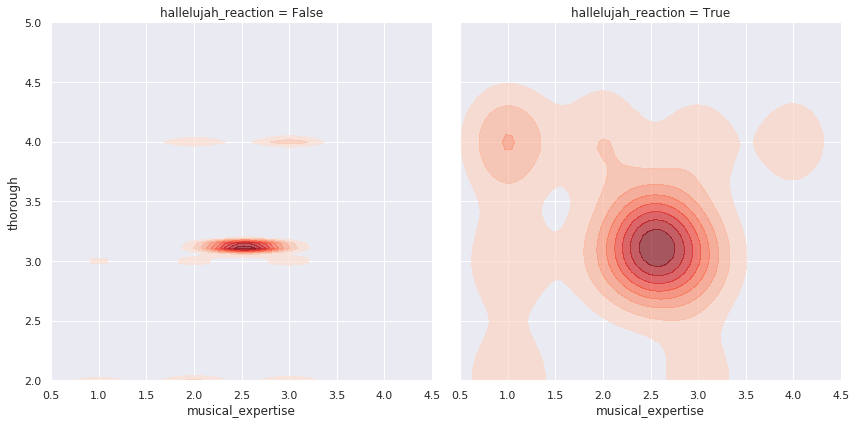

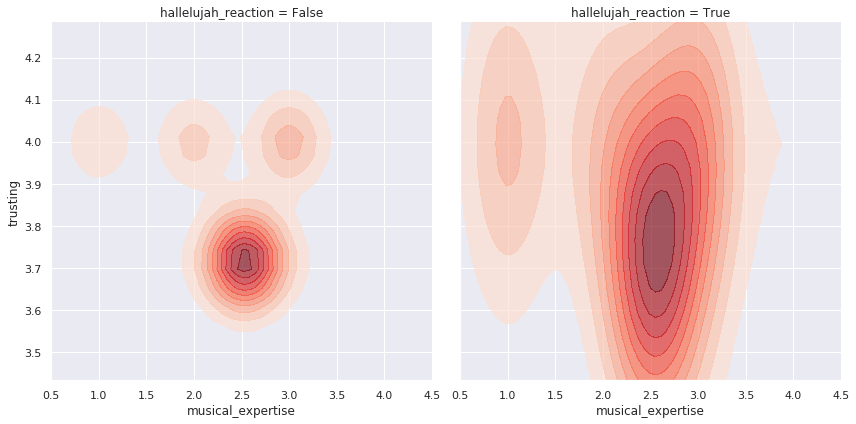

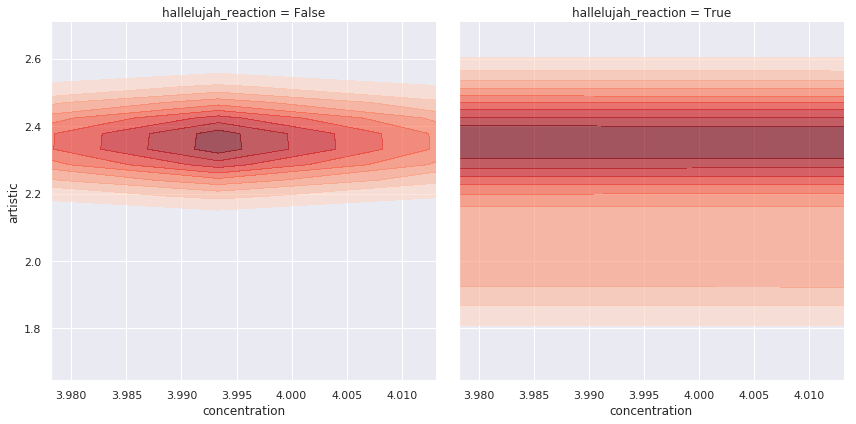

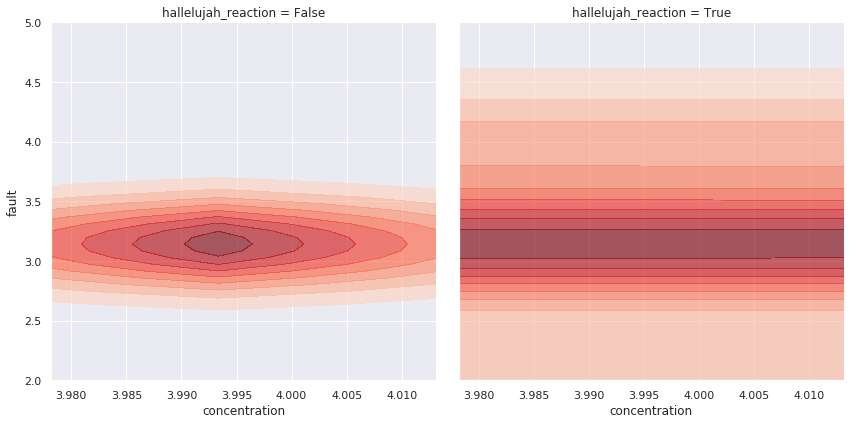

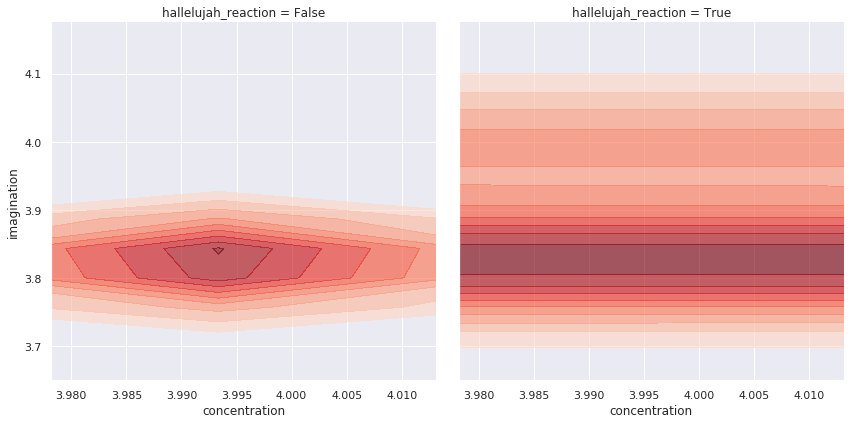

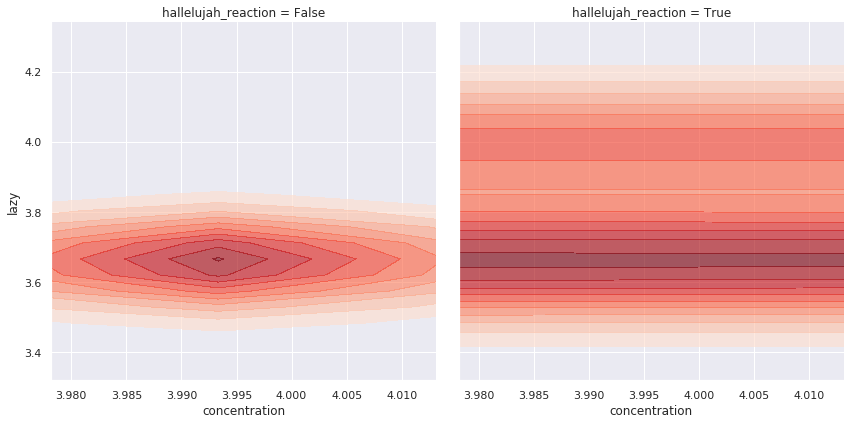

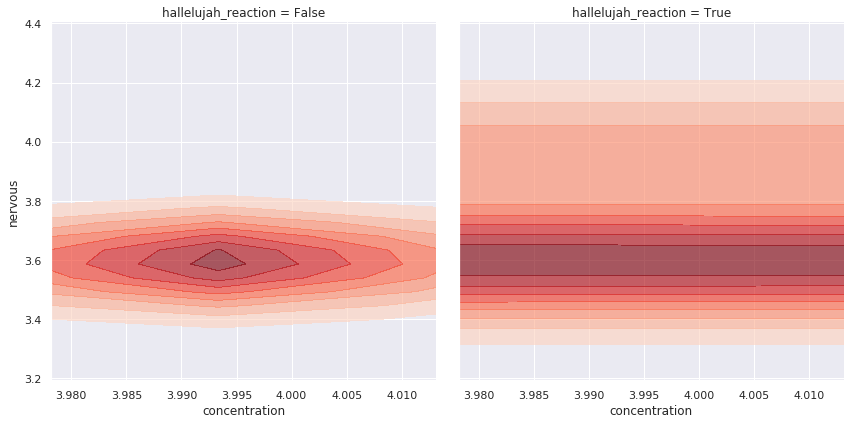

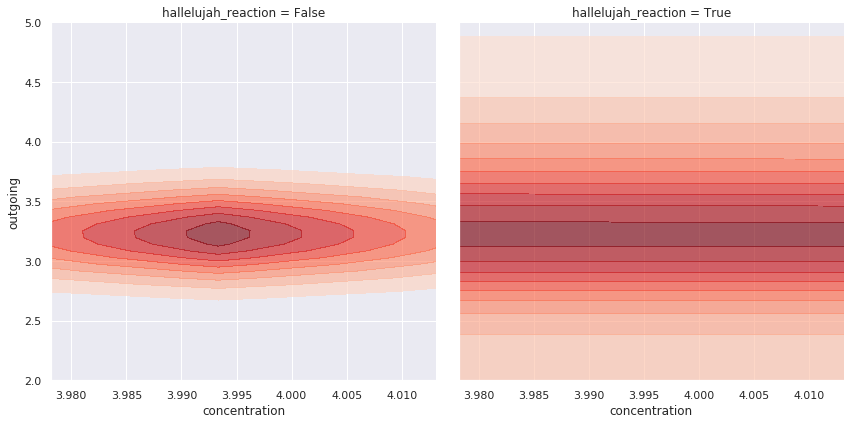

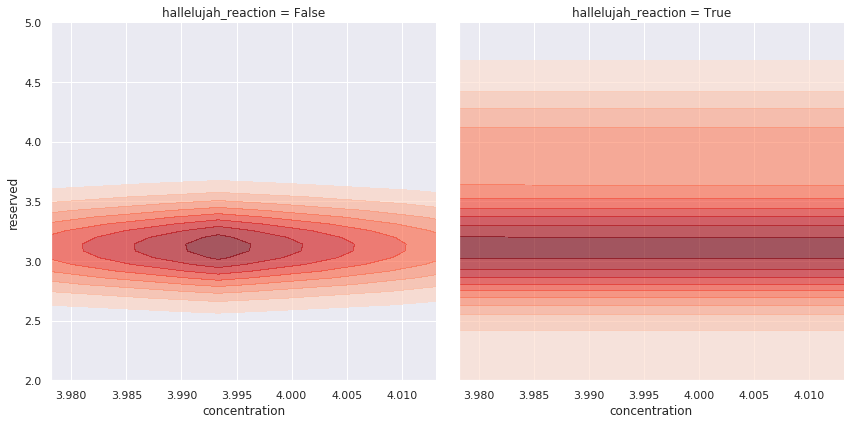

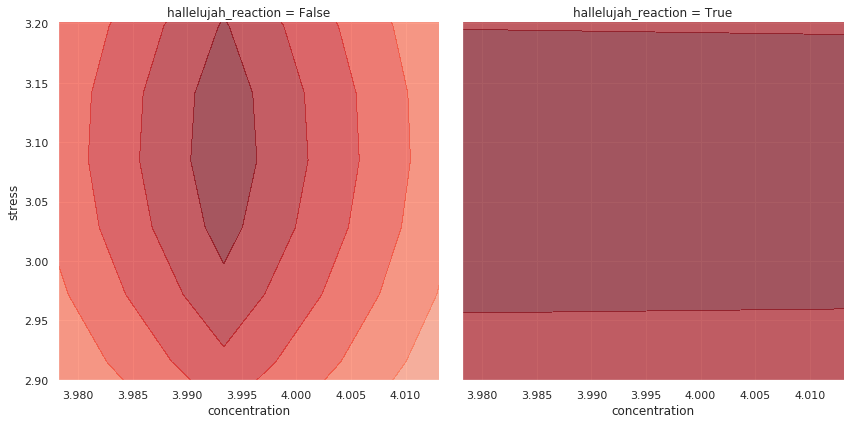

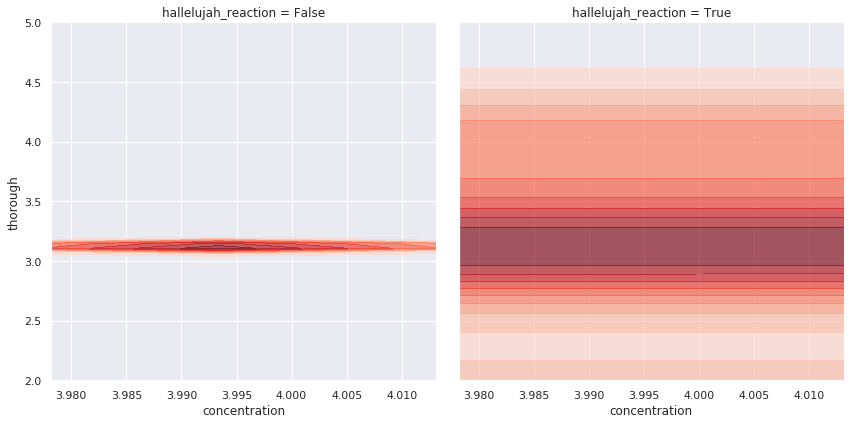

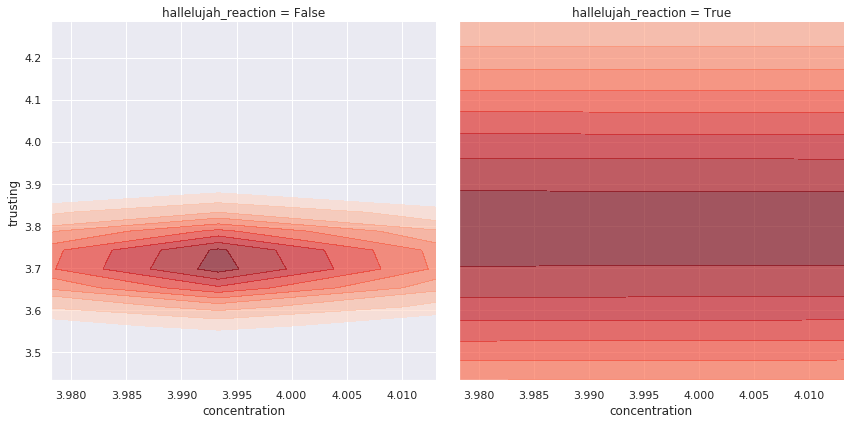

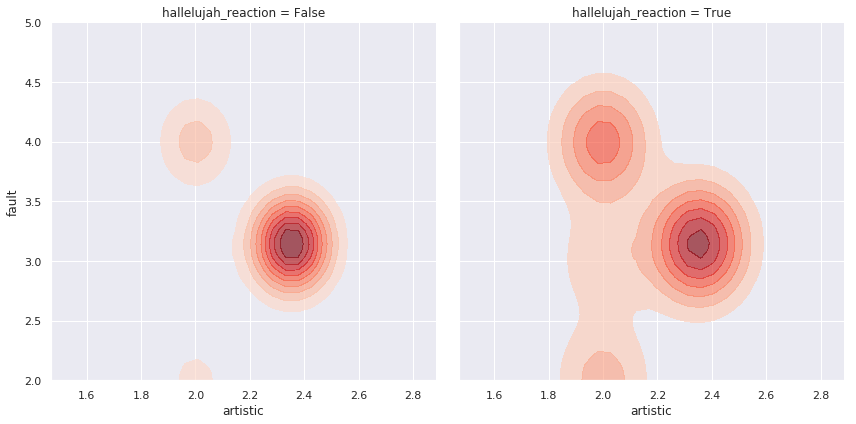

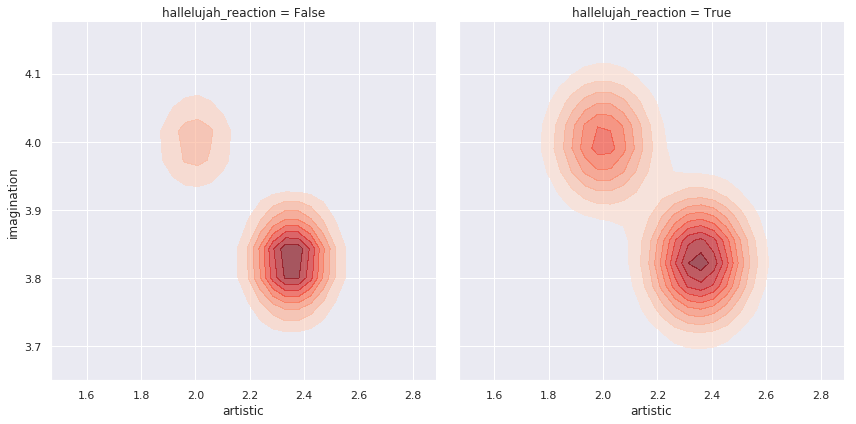

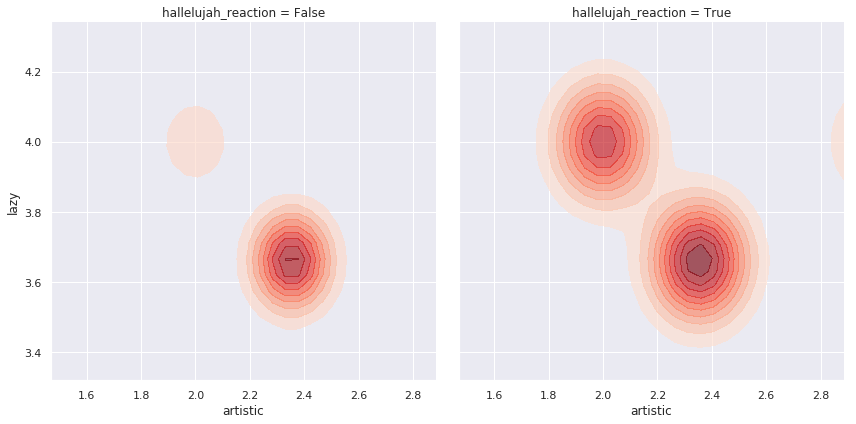

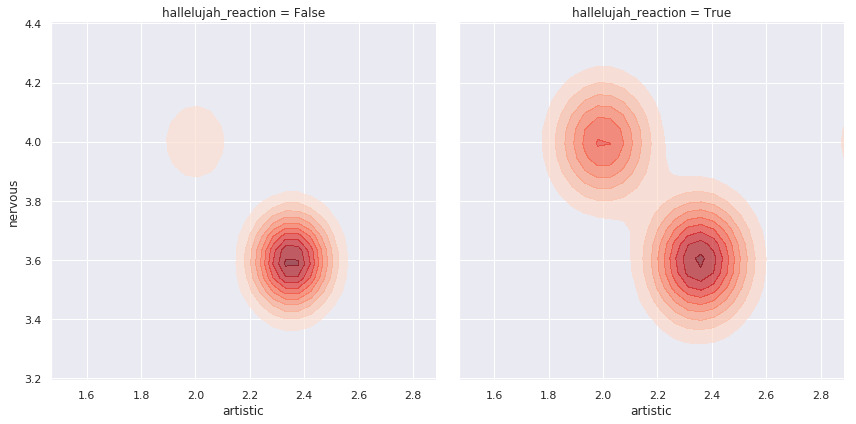

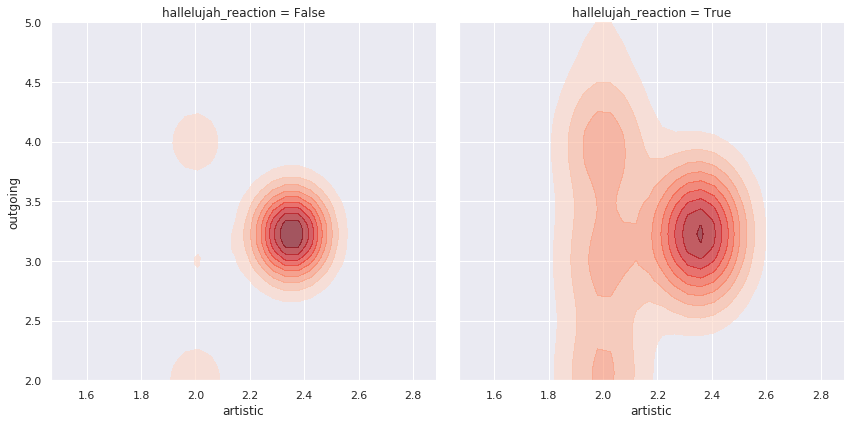

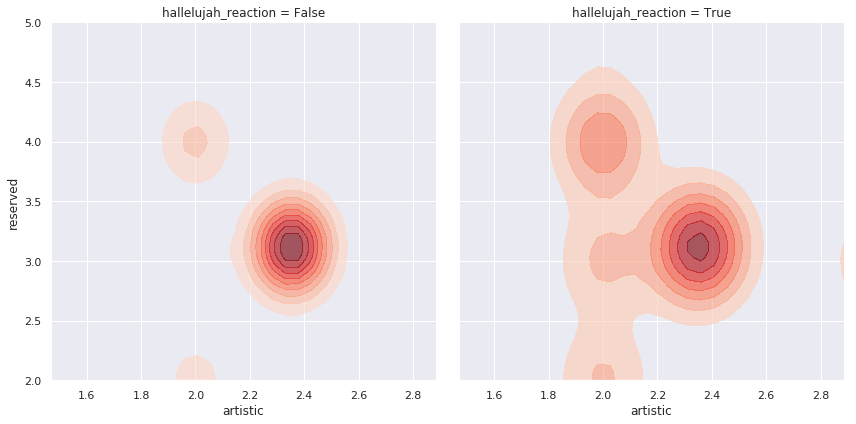

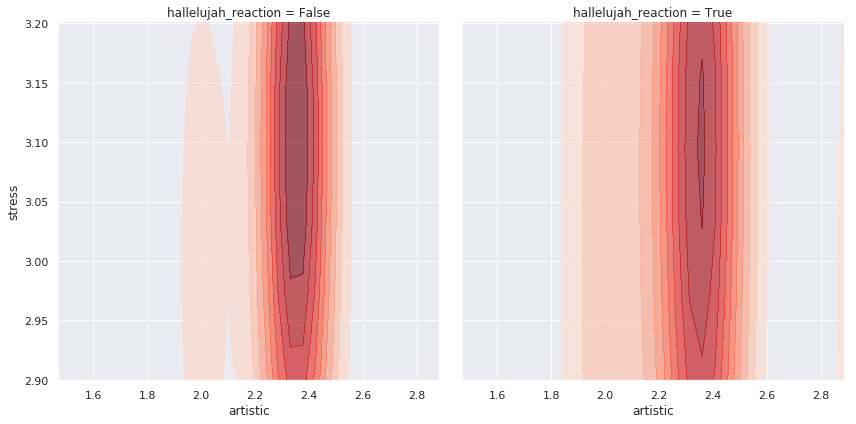

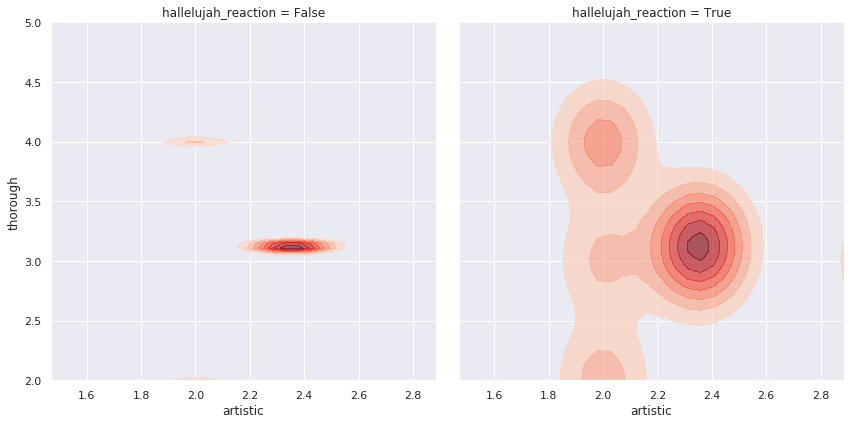

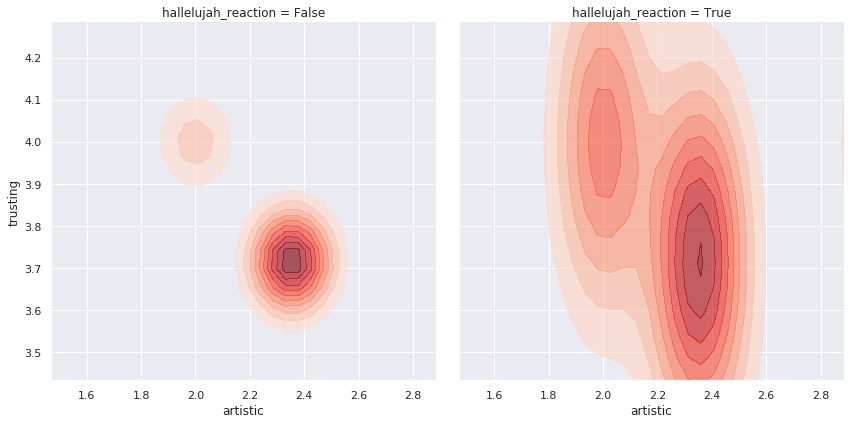

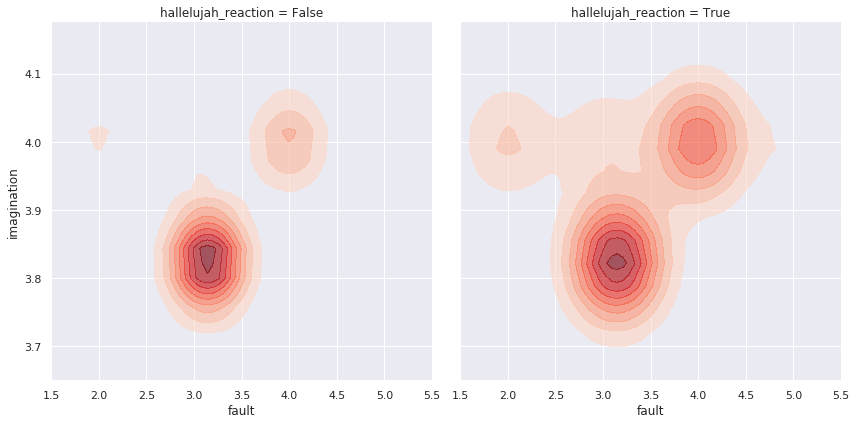

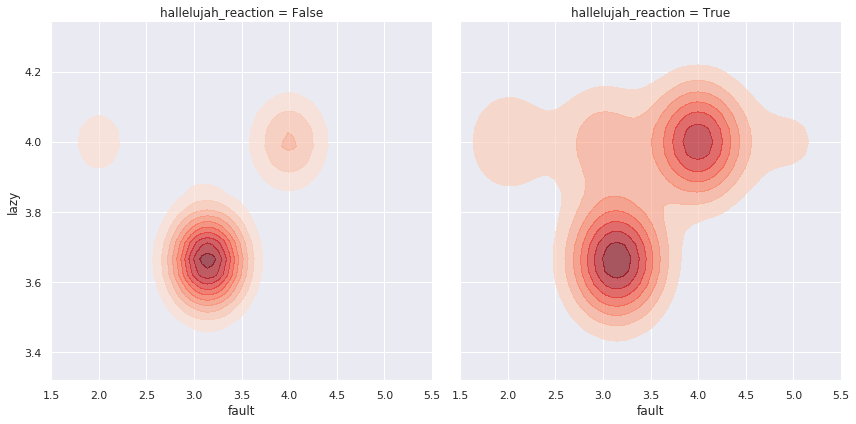

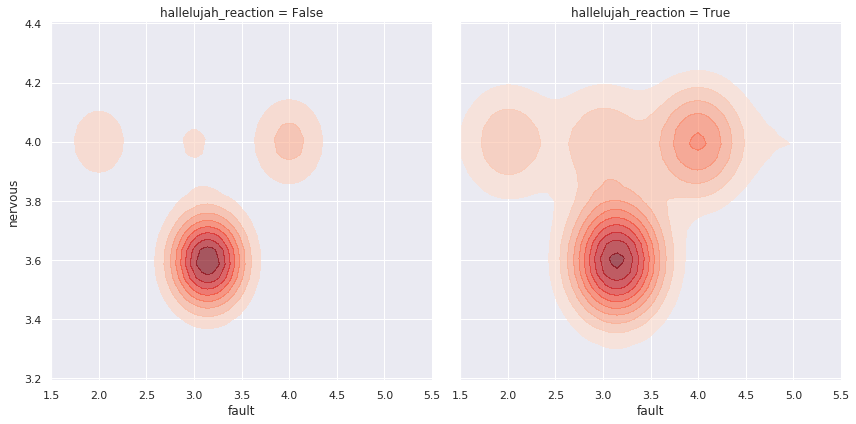

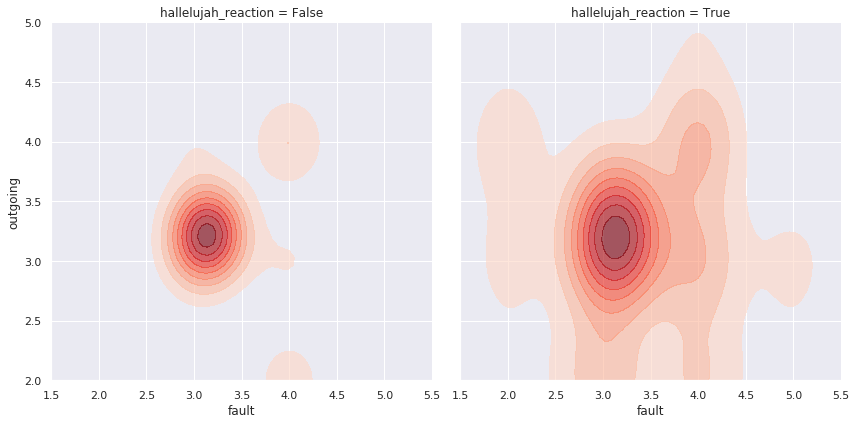

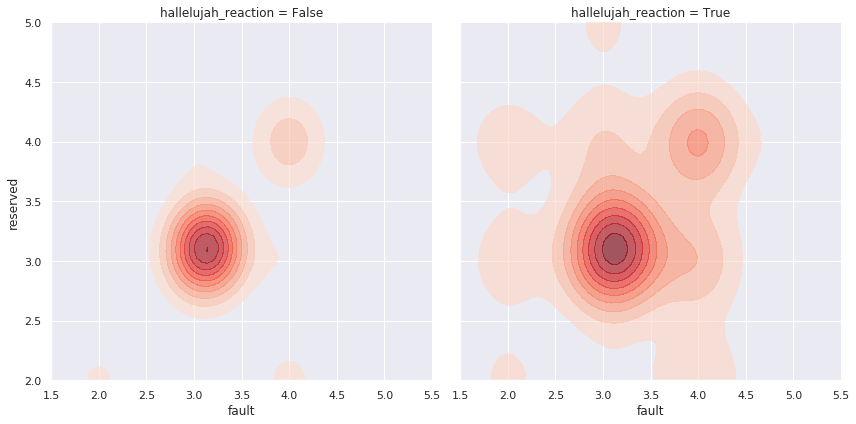

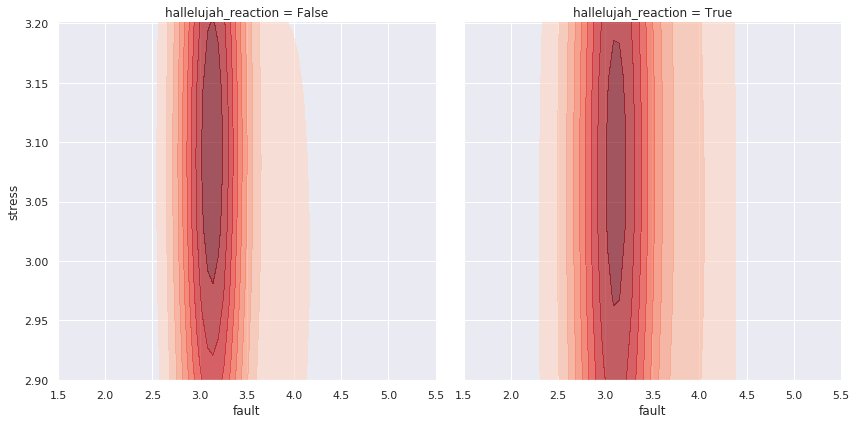

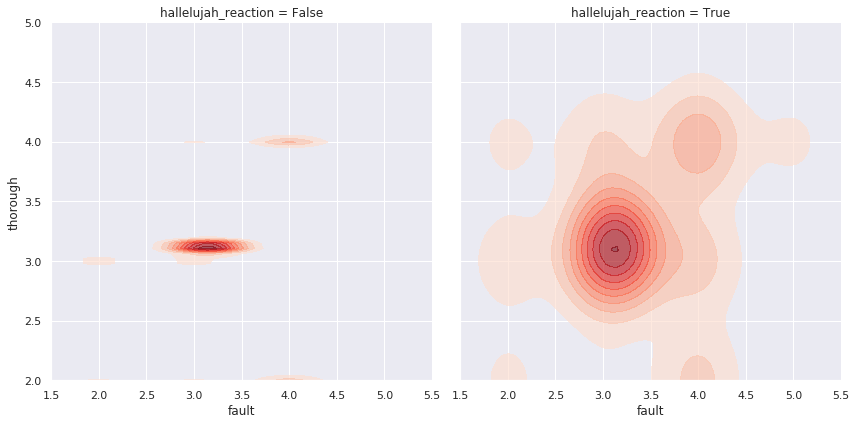

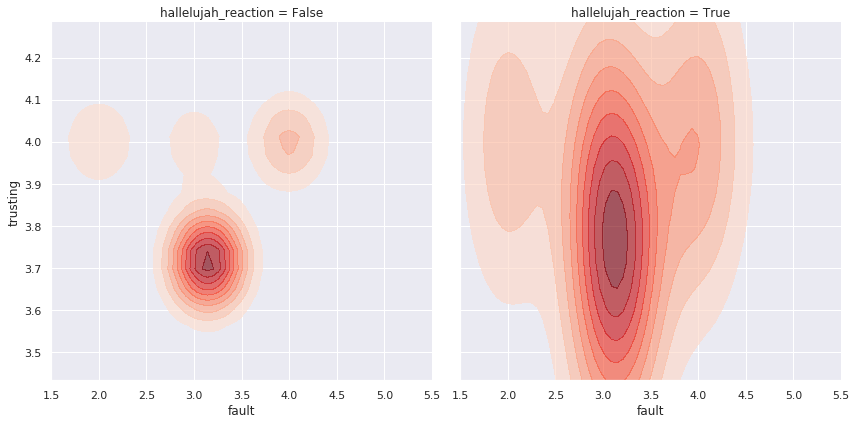

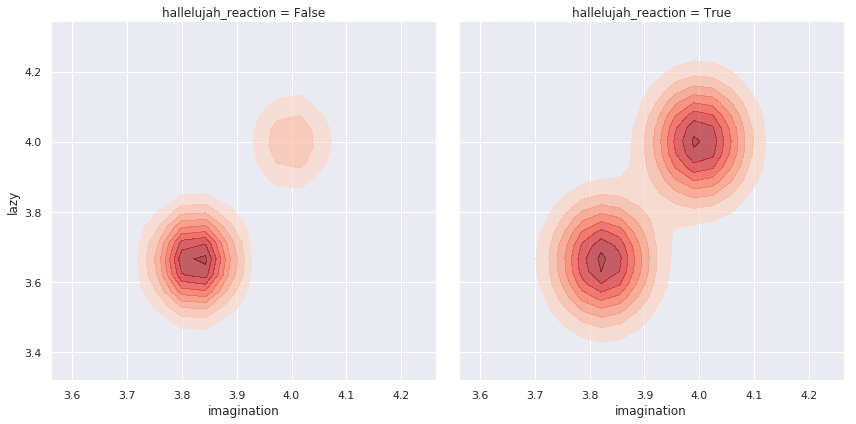

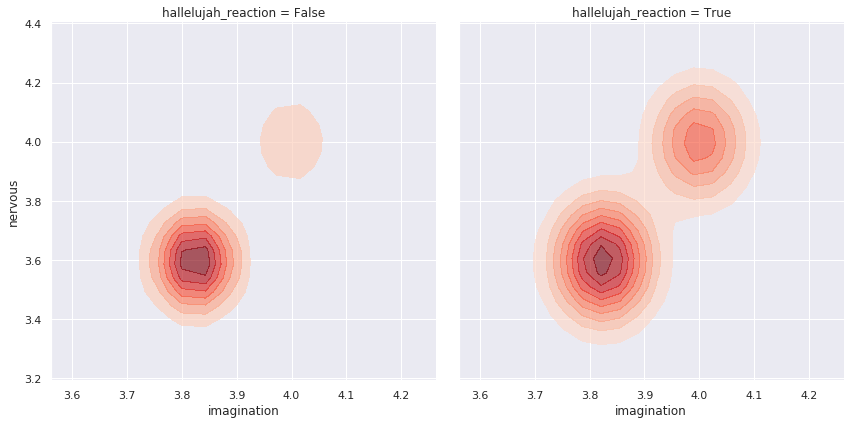

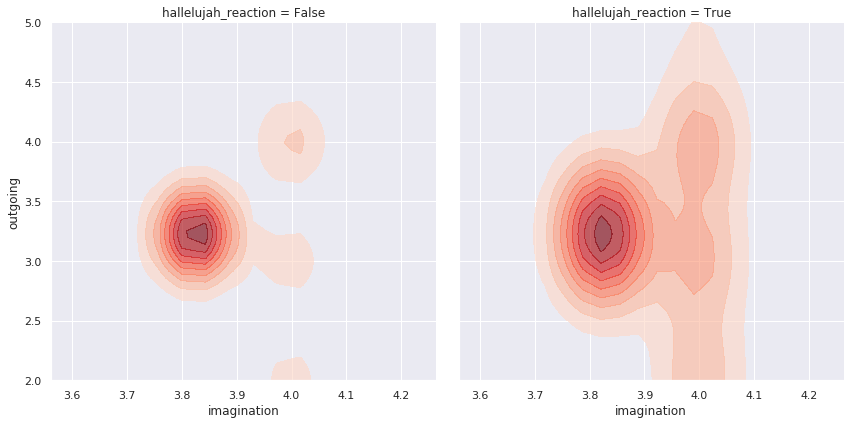

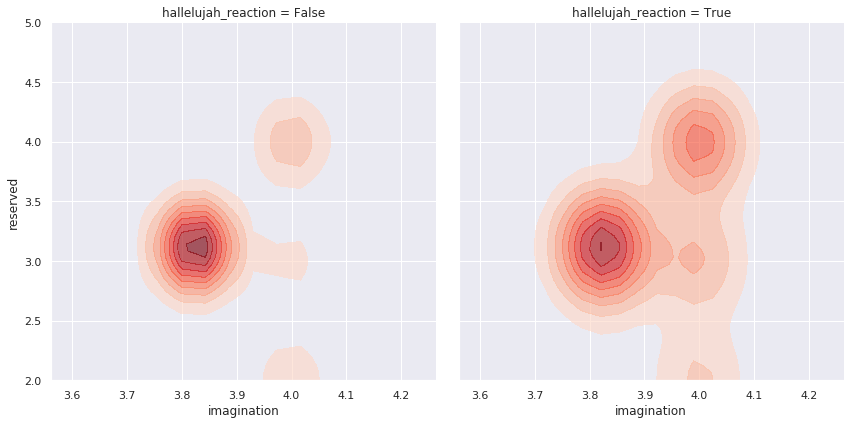

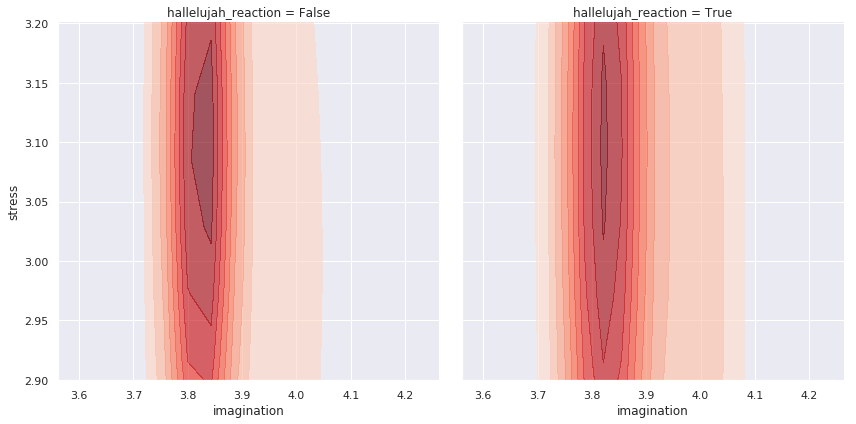

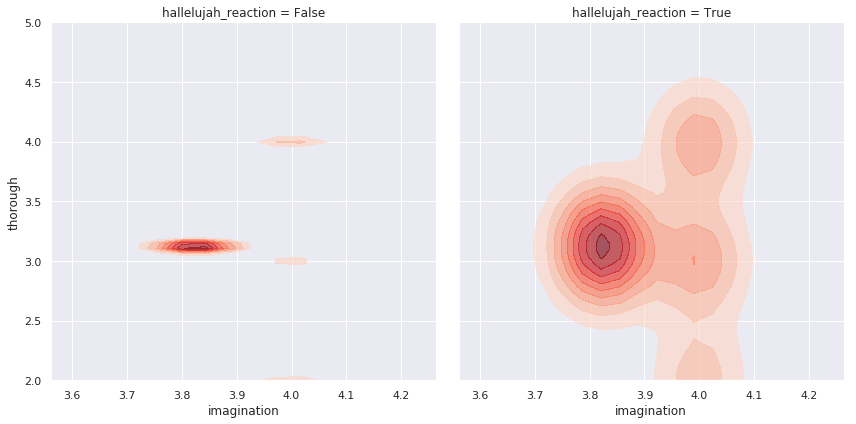

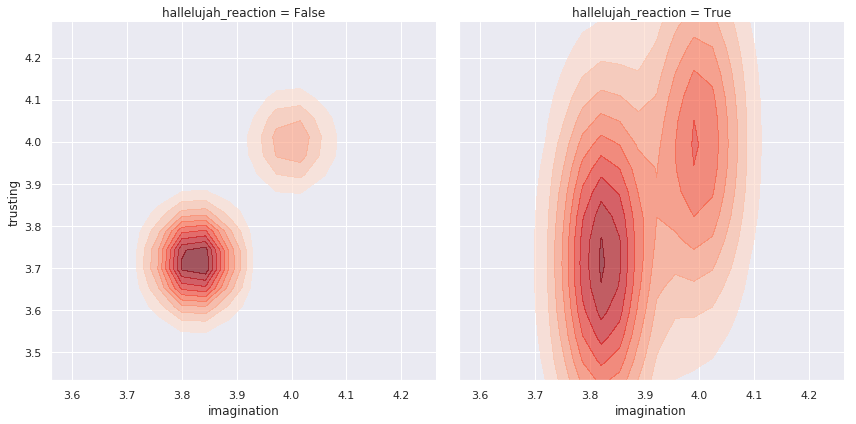

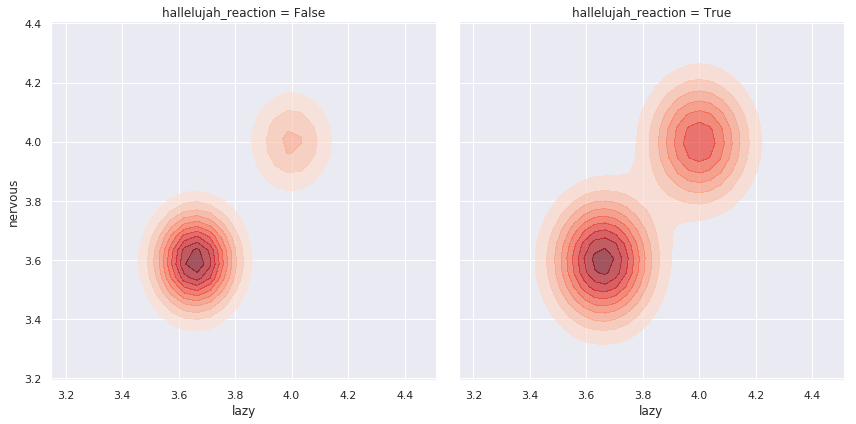

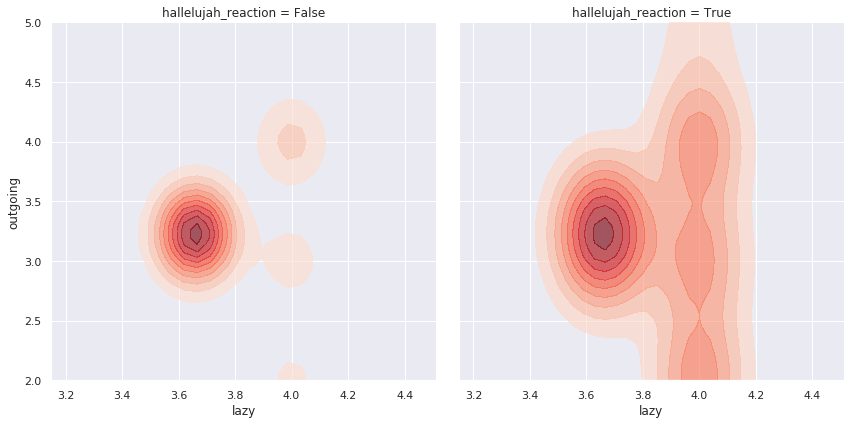

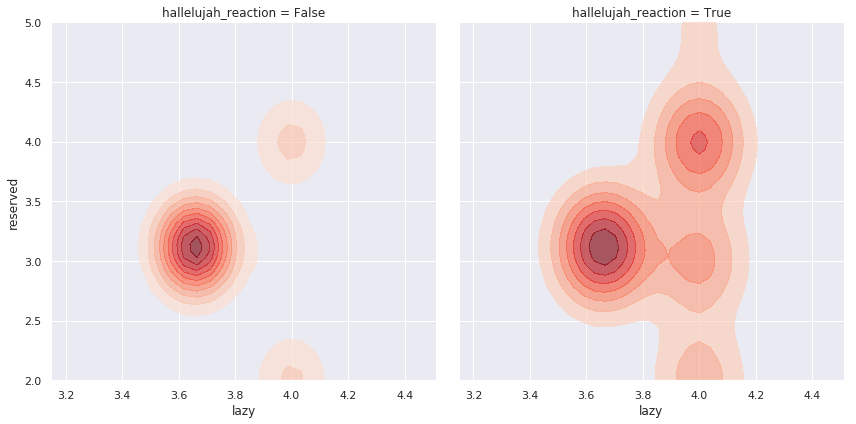

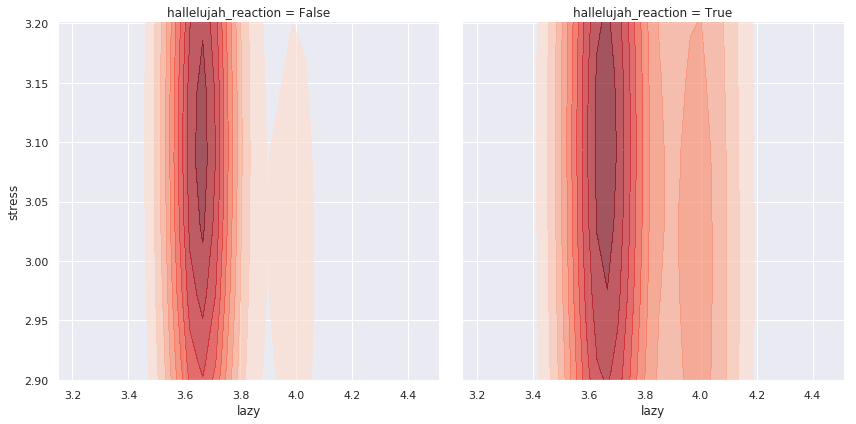

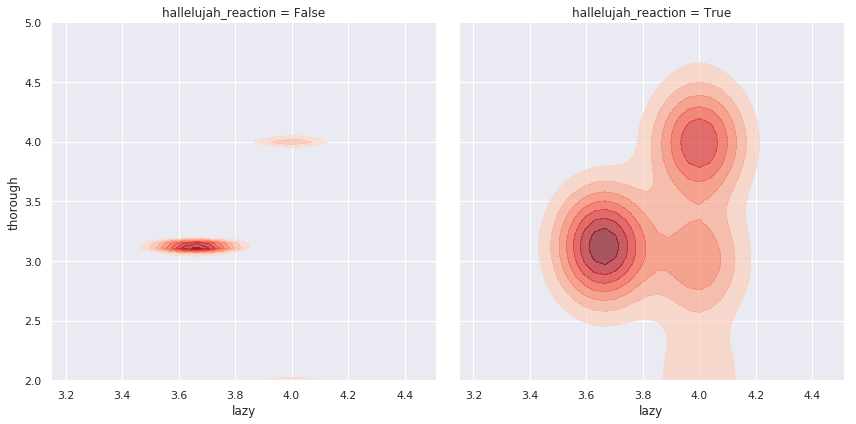

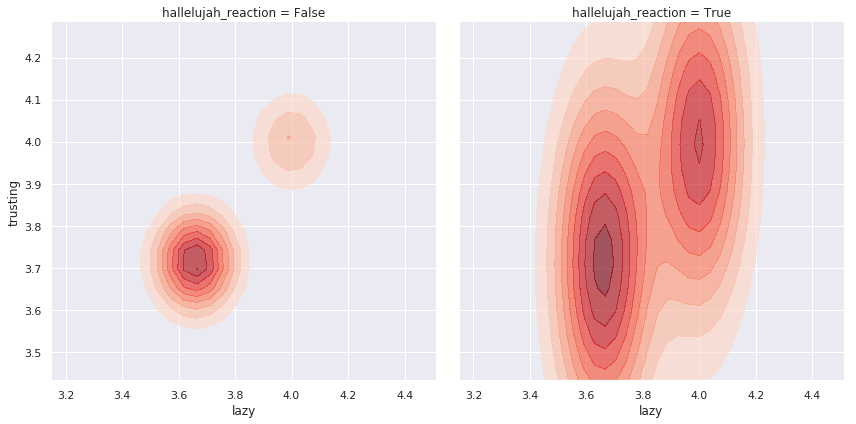

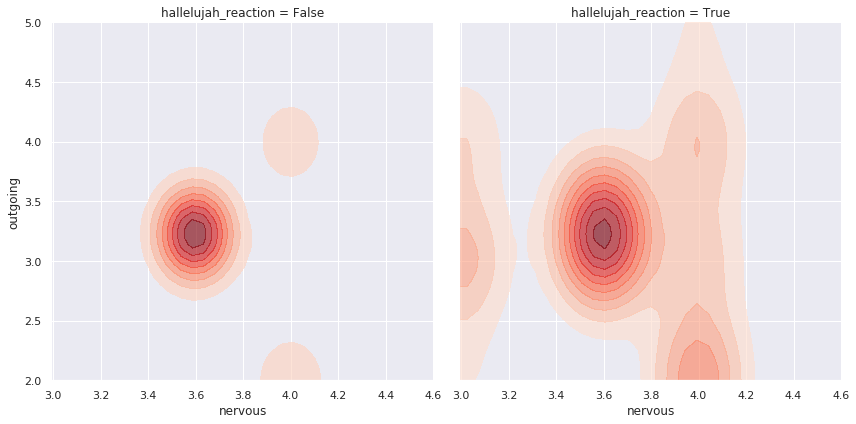

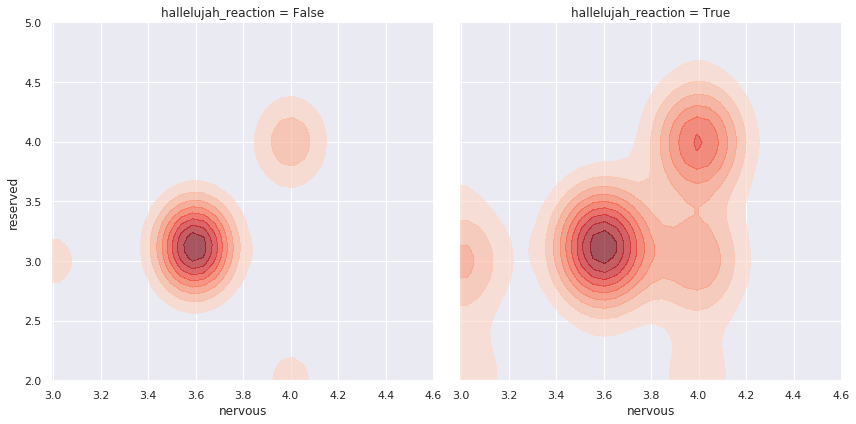

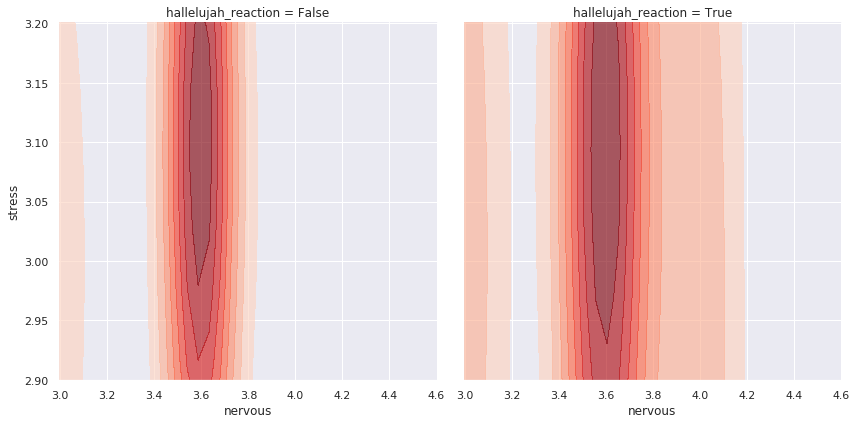

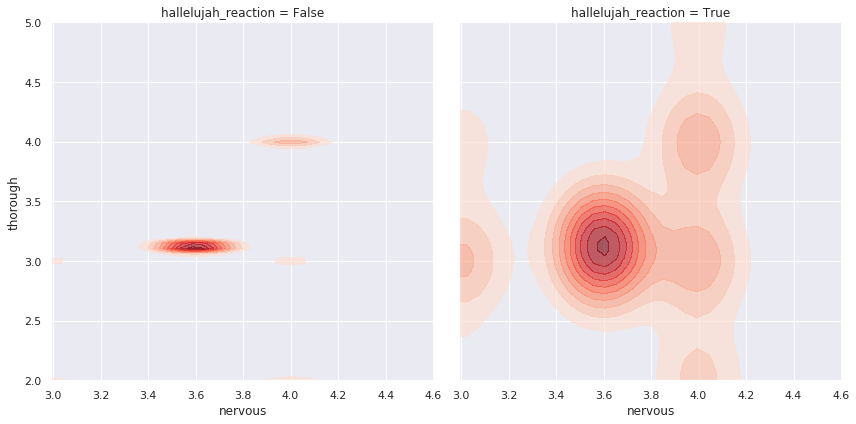

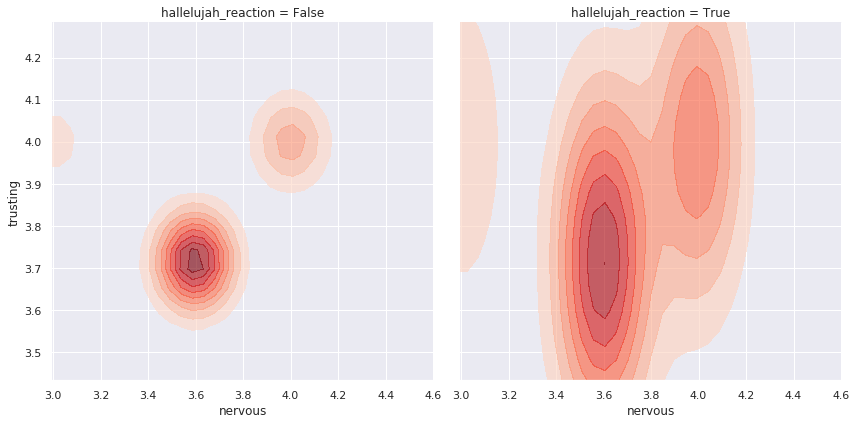

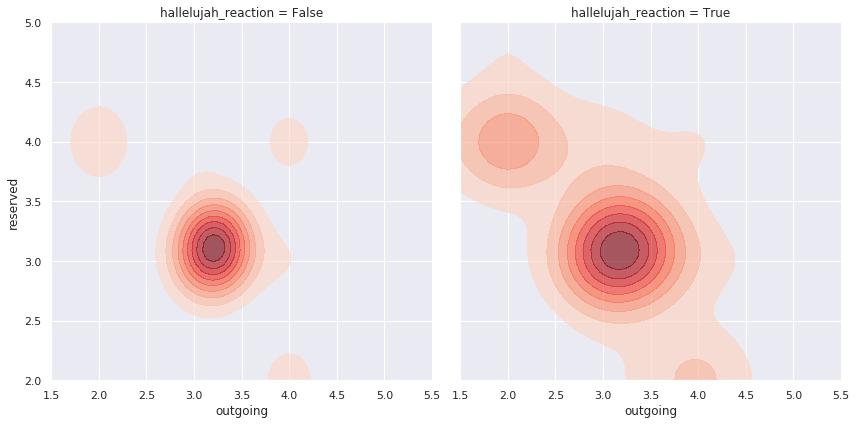

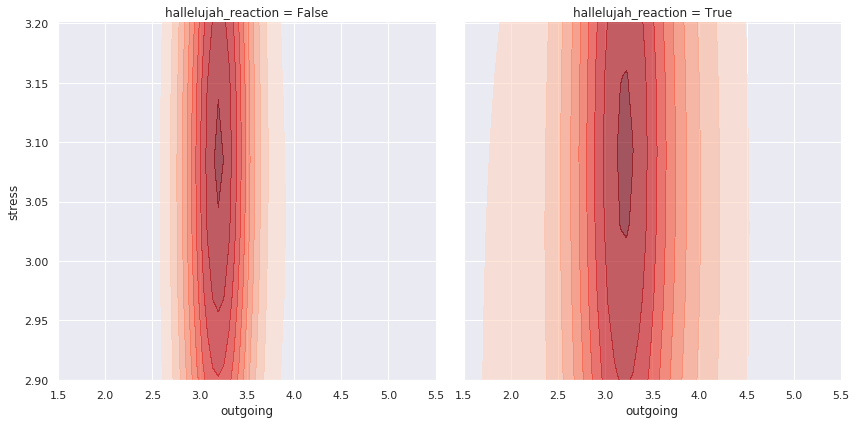

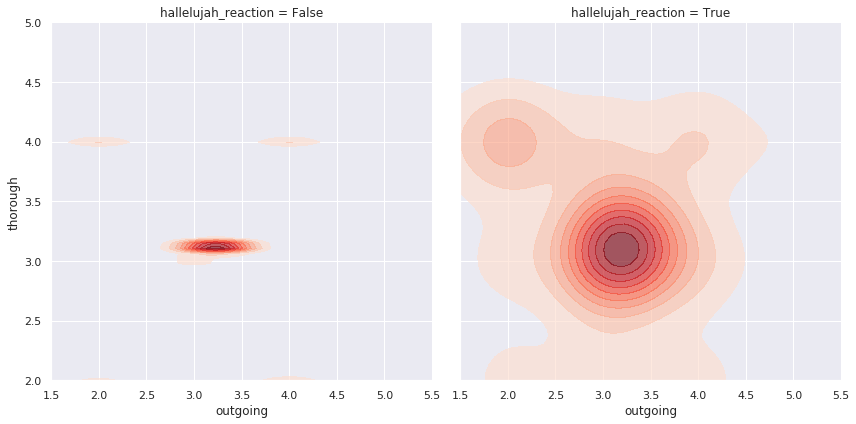

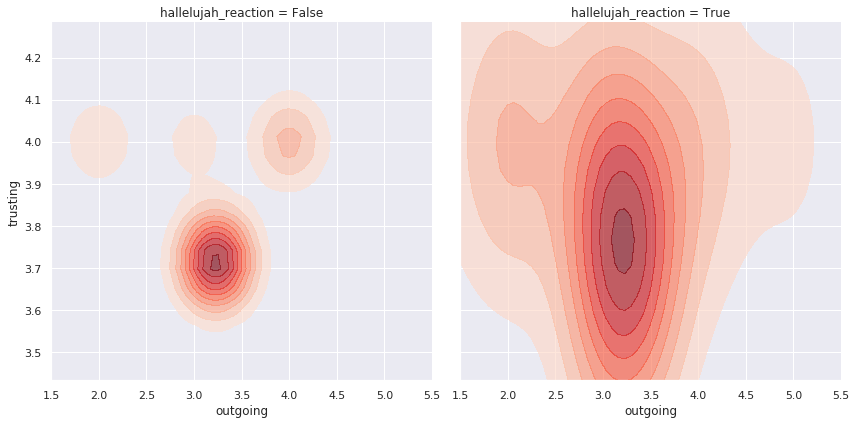

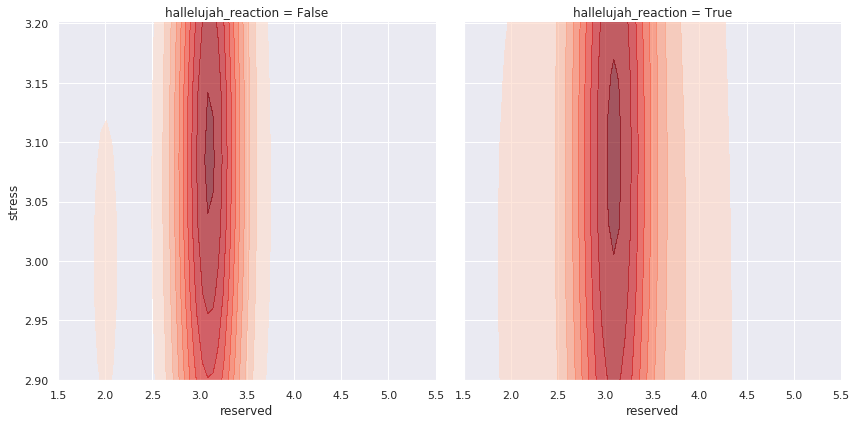

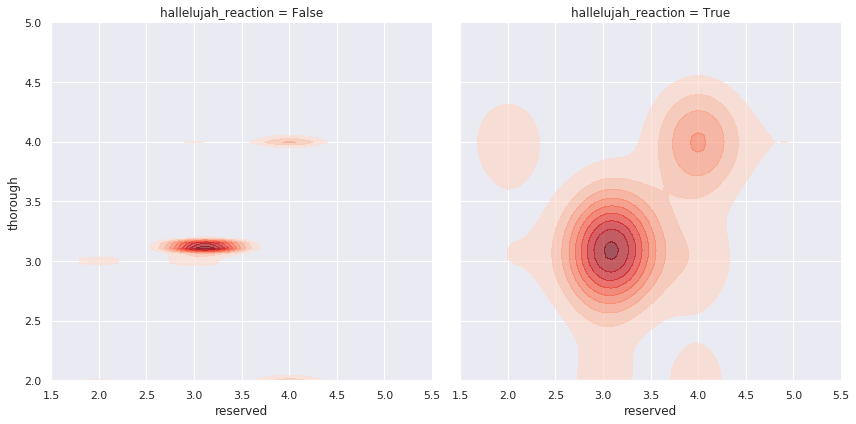

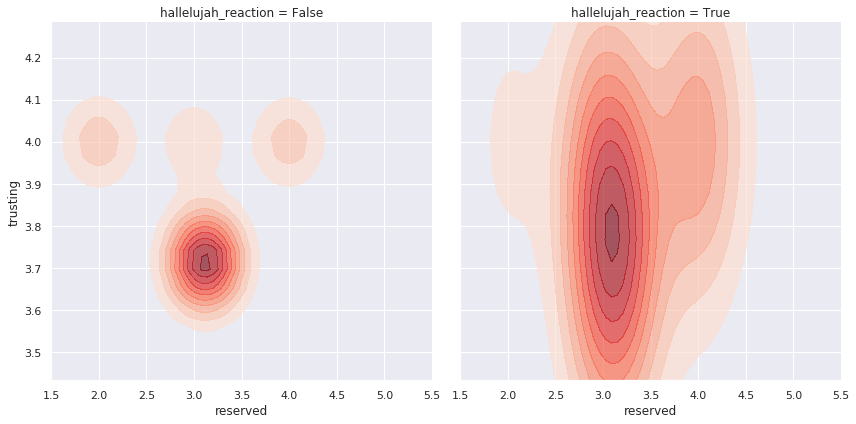

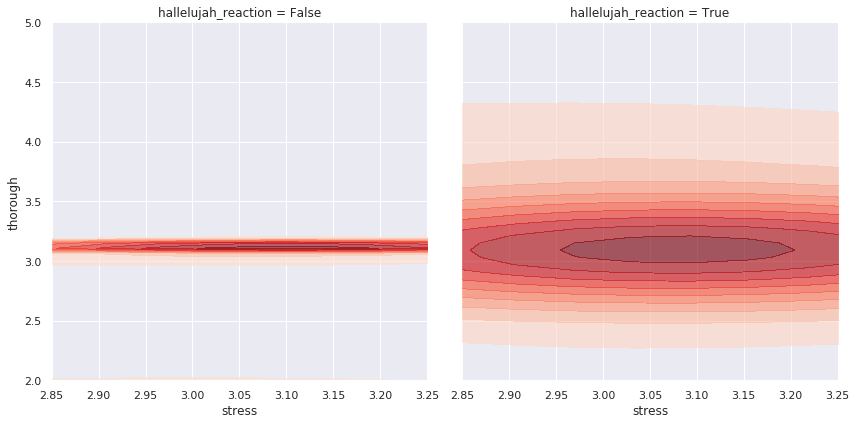

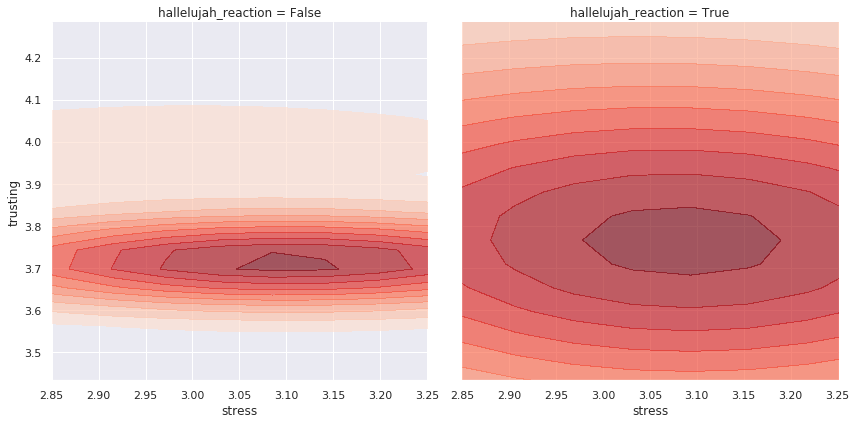

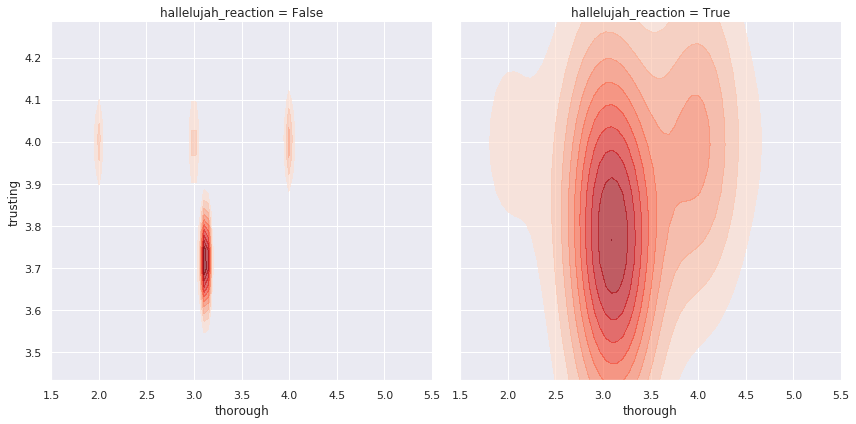

In [627]:
import itertools

plot_vars = ['activity', 
             'engagement', 
             'familiarity', 
             'like_dislike', 
             'positivity', 
             'tension', 
             'age', 
             'musical_expertise', 
             'concentration', 
             'artistic', 
             'fault', 
             'imagination', 
             'lazy', 
             'nervous', 
             'outgoing', 
             'reserved', 
             'stress', 
             'thorough', 
             'trusting']

pairs = list(itertools.combinations(plot_vars, 2))

for pair in pairs:
    
    x_1 = df_all[pair[0]].describe()['25%']
    x_3 = df_all[pair[0]].describe()['75%']
    x_iqr = x_3 - x_1
    x_min = x_1 - 1.5 * x_iqr
    x_max = x_3 + 1.5 * x_iqr

    y_1 = df_all[pair[1]].describe()['25%']
    y_3 = df_all[pair[1]].describe()['75%']
    y_iqr = y_3 - y_1
    y_min = y_1 - 1 * y_iqr
    y_max = y_3 + 1 * y_iqr

    xlim, ylim = (x_min, x_max), (y_min, y_max)

    g = sns.FacetGrid(df_all[[pair[0], pair[1], 'hallelujah_reaction']], col='hallelujah_reaction', height=6, aspect=1, xlim=xlim, ylim=ylim)
    g.map(sns.kdeplot, pair[0], pair[1], cmap='Reds', shade=True, shade_lowest=False, alpha=0.65)

# Pairwise Hotelling's $T^2$

In [681]:
import itertools

plot_vars = ['activity', 
             'engagement', 
             'familiarity', 
             'like_dislike', 
             'positivity', 
             'tension', 
             'age', 
             'musical_expertise', 
             'concentration', 
             'artistic', 
             'fault', 
             'imagination', 
             'lazy', 
             'nervous', 
             'outgoing', 
             'reserved', 
             'stress', 
             'thorough', 
             'trusting']

pairs = list(itertools.combinations(plot_vars, 2))

results = pd.DataFrame(columns=['p', 'F', 'T2', 'df1', 'df2'])

for pair in pairs:
    
    test_vars = list(pair)
    test_vars.append('hallelujah_reaction')
    df_pair = df_all[test_vars]
    df_pair_1 = df_pair[df_pair['hallelujah_reaction'] == False].drop(['hallelujah_reaction'], axis=1)
    df_pair_2 = df_pair[df_pair['hallelujah_reaction'] == True].drop(['hallelujah_reaction'], axis=1)

    t2_results = hotelling_t2(df_pair_1, df_pair_2, 0.05)
    row = pd.DataFrame(
        {
            'p': t2_results['p'], 
            'F': t2_results['F'], 
            'T2': t2_results['T2'], 
            'df1': t2_results['df'][0], 
            'df2': t2_results['df'][1]
        }, 
        index=[pair])

    results = pd.concat([results, row])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display('Tests for difference between combined means of {} and {} between hallelujah reaction groups:'.format(pair[0], pair[1]))
    display(results)

'Tests for difference between combined means of thorough and trusting between hallelujah reaction groups:'

F         T2 df1  df2             p
(activity, engagement)              2.068228   4.150244   2  300  9.998410e-01
(activity, familiarity)             3.276007   6.573853   2  300  1.000000e+00
(activity, like_dislike)            2.156751   4.327879   2  300  9.999334e-01
(activity, positivity)              1.963096   3.939278   2  300  9.995628e-01
(activity, tension)                 2.576314   5.169804   2  300  9.999991e-01
(activity, age)                     1.400976   2.811291   2  300  9.486236e-01
(activity, musical_expertise)       1.995088   4.003477   2  300  9.996777e-01
(activity, concentration)           1.275627   2.559758   2  300  8.810632e-01
(activity, artistic)                1.286187   2.580948   2  300  8.887028e-01
(activity, fault)                   2.755667   5.529705   2  300  9.999999e-01
(activity, imagination)             1.291026   2.590660   2  300  8.920684e-01
(activity, lazy)                    1.914229   3.841220   2  300  9.993070e-01
(activity, nervous)                 2.782586   5.583722   2  300  9.999999e-01
(activity, outgoing)                2.743000   5.504287   2  300  9.999998e-01
(activity, reserved)                2.133805   4.281835   2  300  9.999164e-01
(activity, stress)                  3.732468   7.489819   2  300  1.000000e+00
(activity, thorough)                2.183409   4.381374   2  300  9.999489e-01
(activity, trusting)                2.090324   4.194583   2  300  9.998718e-01
(engagement, familiarity)           2.107166   4.228380   2  300  9.998914e-01
(engagement, like_dislike)          0.552971   1.109628   2  300  7.087123e-03
(engagement, positivity)            0.428713   0.860284   2  300  3.076761e-04
(engagement, tension)               0.876346   1.758535   2  300  2.952817e-01
(engagement, age)                   0.431656   0.866190   2  300  3.376746e-04
(engagement, musical_expertise)     1.411968   2.833350   2  300  9.525092e-01
(engagement, concentration)         0.666382   1.337206   2  300  4.437933e-02
(engagement, artistic)              0.443212   0.889380   2  300  4.815861e-04
(engagement, fault)                 2.167529   4.349508   2  300  9.999402e-01
(engagement, imagination)           0.523576   1.050642   2  300  3.833229e-03
(engagement, lazy)                  1.172328   2.352471   2  300  7.826901e-01
(engagement, nervous)               1.630860   3.272592   2  300  9.913893e-01
(engagement, outgoing)              2.254159   4.523346   2  300  9.999749e-01
(engagement, reserved)              1.331793   2.672464   2  300  9.172324e-01
(engagement, stress)                3.460641   6.944353   2  300  1.000000e+00
(engagement, thorough)              1.039897   2.086726   2  300  5.899392e-01
(engagement, trusting)              1.473640   2.957103   2  300  9.698645e-01
(familiarity, like_dislike)         2.206466   4.427642   2  300  9.999594e-01
(familiarity, positivity)           2.101419   4.216848   2  300  9.998850e-01
(familiarity, tension)              2.830556   5.679982   2  300  9.999999e-01
(familiarity, age)                  2.061981   4.137709   2  300  9.998310e-01
(familiarity, musical_expertise)    2.861699   5.742477   2  300  1.000000e+00
(familiarity, concentration)        2.102949   4.219918   2  300  9.998868e-01
(familiarity, artistic)             2.097112   4.208205   2  300  9.998801e-01
(familiarity, fault)                3.917306   7.860728   2  300  1.000000e+00
(familiarity, imagination)          2.093016   4.199985   2  300  9.998752e-01
(familiarity, lazy)                 3.349047   6.720421   2  300  1.000000e+00
(familiarity, nervous)              3.255114   6.531928   2  300  1.000000e+00
(familiarity, outgoing)             3.790864   7.607000   2  300  1.000000e+00
(familiarity, reserved)             3.081493   6.183529   2  300  1.000000e+00
(familiarity, stress)               4.660081   9.351230   2  300  1.000000e+00
(familiarity, thorough)             2.806042   5.630791   2  300  9.999999e-01
(familiarity, 

In [444]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 5.0, 50)},
                    cv=100) # 20-fold cross-validation
grid.fit(df_all[['tension', 'age']])
print(grid.best_params_)

{'bandwidth': 2.6535306122448978}


In [375]:
this_col.describe()

count    303.000000
mean       2.344099
std        0.988361
min        1.000000
25%        2.000000
50%        2.353712
75%        2.353712
max        5.000000
Name: artistic, dtype: float64

- Ordinal
  - Demographic
    - age
    - musical_expertise
    - concentration
  - Personality
    - artistic
    - fault
    - imagination
    - lazy
    - nervous
    - outgoing
    - reserved
    - stress
    - thorough
    - trusting
  - Musical Response
    - activity
    - engagement
    - familiarity
    - like_dislike
    - positivity
    - tension
- Categorical
  - Demographic
    - hearing_impairments
    - nationality
    - location
    - language
    - sex
  - Musical Response
    - hallelujah_reaction

# Hotelling's Two-Sample $T^2$

In [484]:
hotelling_vars = [
    'age',
    'concentration',
    'hearing_impairments',
    'musical_expertise',
#     'nationality',
    'artistic',
    'fault',
    'imagination',
    'lazy',
    'nervous',
    'outgoing',
    'reserved',
    'stress',
    'thorough',
    'trusting',
    'activity',
    'engagement',
    'familiarity',
    'like_dislike',
    'positivity',
    'tension',
#     'sex',
    'hallelujah_reaction',
#     'location',
#     'language',
    'music_pref_none',
    'music_pref_hiphop',
    'music_pref_dance',
    'music_pref_world',
    'music_pref_rock',
    'music_pref_pop',
    'music_pref_classical',
    'music_pref_jazz',
    'music_pref_folk',
    'music_pref_traditional_irish'
]

In [485]:
nationality_cols = pd.get_dummies(df_all['nationality'], prefix='nationality')
sex_cols = pd.get_dummies(df_all['sex'], prefix='sex')
location_cols = pd.get_dummies(df_all['location'], prefix='location')
language_cols = pd.get_dummies(df_all['language'], prefix='language')

In [486]:
df_hotelling = df_all[hotelling_vars]
df_hotelling = pd.concat([df_hotelling, 
                          nationality_cols, 
                          sex_cols, 
                          location_cols, 
                          language_cols], axis=1)

In [653]:
df_hotelling_1 = df_hotelling[df_hotelling['hallelujah_reaction'] == False].drop(['hallelujah_reaction'], axis=1)
df_hotelling_2 = df_hotelling[df_hotelling['hallelujah_reaction'] == True].drop(['hallelujah_reaction'], axis=1)

print('Test for difference between combined means of hallelujah reaction groups')
hotelling_t2(df_hotelling_1, df_hotelling_2, 0.05)

Test for difference between combined means of hallelujah reaction groups


{'F': 0.99110374871375451,
 'T2': array(56.37585417880443),
 'df': (48, 254),
 'p': 0.50375934411737811}